# Plots for Paper

Here we summarize the most relevant results achieved during the project. We provide teh code and the plot in order to be as clear as possible.

In [1]:
from typing import Optional, List, Tuple, Union, Any

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statsmodels.tsa.stattools import acf

from src.utils.utils import plot_hist, block_mean, block_std, get_energy
from src.utils.pltutils import plt_betas_ar # plt_eng_step, plt_acf
from src.utils.montecarlo import neural_mcmc, hybrid_mcmc, seq_hybrid_mcmc, single_spin_flip


## Model

$$
H(\sigma) = \sum_{i=1}^{N} J_{ij}\sigma_i\sigma_j
$$
with $J_{ij}\in[-1,1]$ uniformly distributed and $\sigma_i \in \{\pm1\}$.


## Correlation and thermalization

We focused on the system with 484 spins and 1NN couplings, in this scenario we observe a significative boosting when using the neural network inside the Monte Carlo methods as a smart proposal.
We called this  procedure *Neural Markov Chain Monte Carlo (Neural MCMC)*. In this method the Metropolis-Hastings acceptance rate becomes
$$
A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{p(\mathbf{\sigma}')\omega_{\mathbf{\sigma}\mathbf{\sigma}'}}{p(\mathbf{\sigma})\omega_{\mathbf{\sigma}'\mathbf{\sigma}}}\right).
$$

Then we compare with the data generated by the neural network, an autoregressive model called **MADE** (**M**asked **A**utoregressive **D**ensity **E**stimator), in this case. Since our goal is to use [D-Wave](https://www.dwavesys.com/) dataset we need to understand at which temperature, let's say *effective* $\beta$ (we indicate it as $\beta_{eff}$), the dataset are more efficient.

In the following, we compare some dataset, including a classic one obtained by a Markov Chain Monte Carlo with single spin moves, used as a benchmark.

In [2]:
datasets = [
        "data/generated/sample-1000000_size-484_2022-01-28_15-48-44.npz", # 1mus 1nn
        "data/generated/sample-1000000_size-484_2022-01-28_15-50-01.npz", # 10mus 1nn
        "data/generated/sample-1000000_size-484_2022-02-10_11-48-45.npz", # 100mus 1nn
        "data/generated/sample-1000000_size-484_2022-05-10_23-59-33.npz", # 1-10-100mus 1nn
        "data/generated/sample-1000000_size-484_2022-02-10_15-28-37.npz", # 1<beta<2.5 1nn
        "data/generated/sample-1000000_size-484_2022-02-10_17-00-33.npz" # 100mus and 1<beta<2.5 1nn
        ]

labels = [r"1 $\mu$s",r"10 $\mu$s", r"100 $\mu$s", r"1-10-100 $\mu$s", 
          r"$1\leq\beta\leq2.5$", r"$100 \mu$s and $1\leq\beta\leq2.5$"
        ]

betas = np.linspace(1, 4, num=31)
couplings_path = "data/couplings/484spins-uniform-1nn.txt"
ground_state = -0.7550297905

In [ ]:
acc_rates = []
for i, dataset in enumerate(datasets):
    acc_rate = []
    if i > 3:
        continue
    for beta in betas:
        _, eng_neural, ar = neural_mcmc(beta, 10000, dataset, couplings_path, "made", disable_bar=False)
        acc_rate.append(ar)
    acc_rates.append(acc_rate)

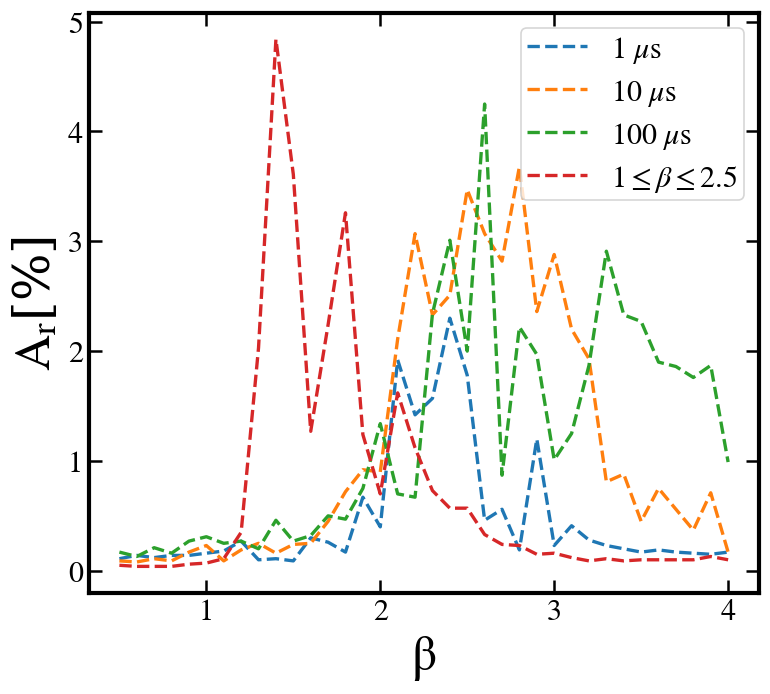

In [9]:
# remove the labels of the dataset  
# that we didn't use
labels_ar = []
for i, label in enumerate(labels):
    if i>3:
        continue
    labels_ar.append(label)

plt_betas_ar(acc_rates, labels_ar, betas)

From the plot above, it seems that the dataset obtain with an annealing time = $100\mu s$ has a better $A_r$ at every temperatures, especially at low temperatures (high $\beta$).

So we collected some Single Spin Flip MCMC at $\beta \in \{2, 2.5,3\}$, starting from 5 different initial configurations, in order to show the performace of the Hybrid approach.

In [7]:
spin_side = 22
spins = spin_side**2

seeds = [12345, 23451, 34512, 45123, 51234] # seed for starting point of mcmc simulations
betas = [2.0, 2.5, 3.0] # we use some significant temperatures only

In [8]:
single_engs = []
for seed in seeds:
    paths = []
    for beta in betas:
        paths.append(f"1nn-forpaper/484spins-seed{seed}-sample1000000-beta{str(beta)}.npy")
    single_engs.append(get_energy(22, paths, couplings_path))

single_engs = np.asarray(single_engs)
single_engs.shape

(5, 3, 1000000)

Nad we load the data of the Hybrid simulation, made using the 1 MCMC step (1 step = 1 sweep, i.e., 484 single spin flip attemps) followed by 1 Neural-MCMC step. 

In [4]:
# WARNING: This dataset is not the correct one for all the beta
# you should use only beta={2, 2.5, 3} 

seq_hybrid = ["data/hybrid/1nn_100mus_betas10-40/484spins_beta1.0_500000hybrid-mcmc_single_len484.npz",
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta1.1_500000hybrid-mcmc_single_len484.npz",
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta1.2_500000hybrid-mcmc_single_len484.npz",
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta1.3_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta1.4_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta1.5_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta1.6_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta1.7_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta1.8_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta1.9_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta2.0_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta2.1_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta2.2_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta2.3_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta2.4_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta2.5_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta2.6_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta2.7_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta2.8_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta2.9_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta3.0_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta3.1_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta3.2_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta3.3_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta3.4_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta3.5_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta3.6_500000hybrid-mcmc_single_len484.npz",
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta3.7_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta3.8_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta3.9_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/1nn_100mus_betas10-40/484spins_beta4.0_500000hybrid-mcmc_single_len484.npz", 
]

eng_seq_hybrid = [np.load(eng)['energy'] / 484 for eng in seq_hybrid]

First of all, we plot the energy w.r.t the steps of the Markov Chain. For the Single Spin Flip simulations we plot the mean of 5 chains and the shadow of the minimum and the maximum value. 

In [5]:
# definition of some functions for print

def plt_eng_step(
    eng1: np.ndarray,
    eng2: np.ndarray,
    label1: str,
    label2: str,
    ground_state: Optional[float] = None,
    xlim: Tuple[int, int] = (1, 1000000),
    title: Optional[str] = None,
    log_scale: bool = True,
    save: bool = False,
):
    fig, ax = plt.subplots(figsize=(8.6, 8.6), dpi=300, facecolor="white")

    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["axes.linewidth"] = 2.5

    stringfont = "serif"

    ax.tick_params(
        axis="y",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=2,
        length=10,
        direction="in",
        labelsize=22,
    )
    ax.tick_params(
        axis="x",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=2,
        length=10,
        direction="in",
        labelsize=22,
    )
    ax.tick_params(
        which="minor",
        top=True,
        right=False,
        labeltop=False,
        labelright=False,
        width=2,
        length=7,
        direction="in",
        labelsize=22,
    )
    if len(eng1.shape) > 1: 
        plt.fill_between(
            np.arange(eng1.shape[-1]),
            eng1.mean(axis=0) + eng1.std(axis=0),
            eng1.mean(axis=0) - eng1.std(axis=0),
            alpha=0.1,
            color="b",
        )
        plt.plot(eng1.mean(axis=0), label=label1, color="b", linewidth=2.5)
    else:
        plt.plot(eng1, label=label1, color="b", linewidth=2.5)

    if len(eng2.shape) > 1:
        plt.fill_between(
            np.arange(eng2.shape[-1]),
            eng2.mean(axis=0) + eng2.std(axis=0),
            eng2.mean(axis=0) - eng2.std(axis=0),
            alpha=0.1,
            color="tab:olive",
        )
        plt.plot(eng2.mean(0), "--", label=label2, color="tab:olive", alpha=0.7)
    else:
        plt.plot(eng2, "--", label=label2, color="tab:olive", alpha=0.7)

    if log_scale:
        ax.set_xscale("log")

    if ground_state is not None:
        plt.hlines(
            ground_state,
            xmin=0,
            xmax=xlim[1] + 100000,
            colors="red",
            linestyles="dashed",
            label="Ground State",
            linewidth=3.0,
        )
    
    plt.xlim(xlim)

    plt.ylabel(r"$E/N$", fontsize=30, fontfamily=stringfont, fontweight="bold")
    plt.xlabel(
        r"$\mathrm{\tau}$", fontsize=30, fontfamily=stringfont, fontweight="bold"
    )

    if title is not None:
        plt.title(rf"{title}", fontsize=20, fontfamily=stringfont)

    plt.legend(loc="best", fontsize=18, labelspacing=0.4, borderpad=0.2, fancybox=True)

    if save:
        plt.savefig(
            "images/energy-steps.png",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            bbox_inches="tight",
            transparent=False,
        )
        plt.savefig(
            "images/energy-steps.eps",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            # transparent=True,
            bbox_inches="tight",
            format="eps",
        )
        
    plt.show()


def plt_acf_nofit(
    acs1: Union[np.ndarray, List[np.ndarray]],
    label1: Union[str, List[str]],
    acs2: Optional[np.ndarray] = None,
    label2: Optional[str] = None,
    xlim: Tuple[int, int] = (1, 1000000),
    ylim: Tuple[int, int] = (0.01, 1),
    title: Optional[str] = None,
    fit: bool = False,
    log_scale: bool = True,
    save: bool = False,
):
    
    from scipy.optimize import curve_fit
    #fig, ax = plt.subplots(figsize=(7.2, 6.4), dpi=120)
    fig, ax = plt.subplots(figsize=(8.6, 8.6), dpi=300, facecolor="white")

    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"

    stringfont = "serif"

    ax.tick_params(
        axis="y",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=2,
        length=10,
        direction="in",
        labelsize=22,
    )
    ax.tick_params(
        axis="x",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=2,
        length=10,
        direction="in",
        labelsize=22,
    )
    ax.tick_params(
        which="minor",
        top=True,
        right=False,
        labeltop=False,
        labelright=False,
        width=2,
        length=7,
        direction="in",
        labelsize=22,
    )

    plt.rcParams["axes.linewidth"] = 2.5


    # if isinstance(acs1, list):
    #     assert len(acs1) == len(label1)
    color_acs1 = ["gold", "red", "darkred"] 

    for i, acs in enumerate(acs1):
        plt.plot(np.insert(acs, 0, 1., axis=0), label=label1[i], linewidth=2.5, color=color_acs1[i])
        ax.set_yscale("log")

    color_acs2 = ["skyblue","steelblue","blue"] 
    if acs2 is not None:
        for i, acs in enumerate(acs2):
            plt.plot(np.insert(acs, 0, 1., axis=0), "--", label=label2[i], linewidth=2.5, color=color_acs2[i])

    if log_scale:
        ax.set_xscale("log")

    plt.ylabel(
        r"$\mathrm{c(\tau)}$", fontsize=30, fontfamily=stringfont, fontweight="bold"
    )
    plt.xlabel(
        r"$\mathrm{\tau}$", fontsize=30, fontfamily=stringfont, fontweight="bold"
    )

    plt.ylim(ylim)
    plt.xlim(xlim)

    if title is not None:
        plt.title(title, fontsize=18, fontfamily=stringfont)

    plt.legend(loc="best", fontsize=18, labelspacing=0.4, borderpad=0.2, fancybox=True)

    if save:
        plt.savefig(
            "images/correlation.png",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            bbox_inches="tight",
            transparent=False,
        )
        plt.savefig(
            "images/correlation.eps",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            # transparent=True,
            bbox_inches="tight",
            format="eps",
        )

    plt.show()

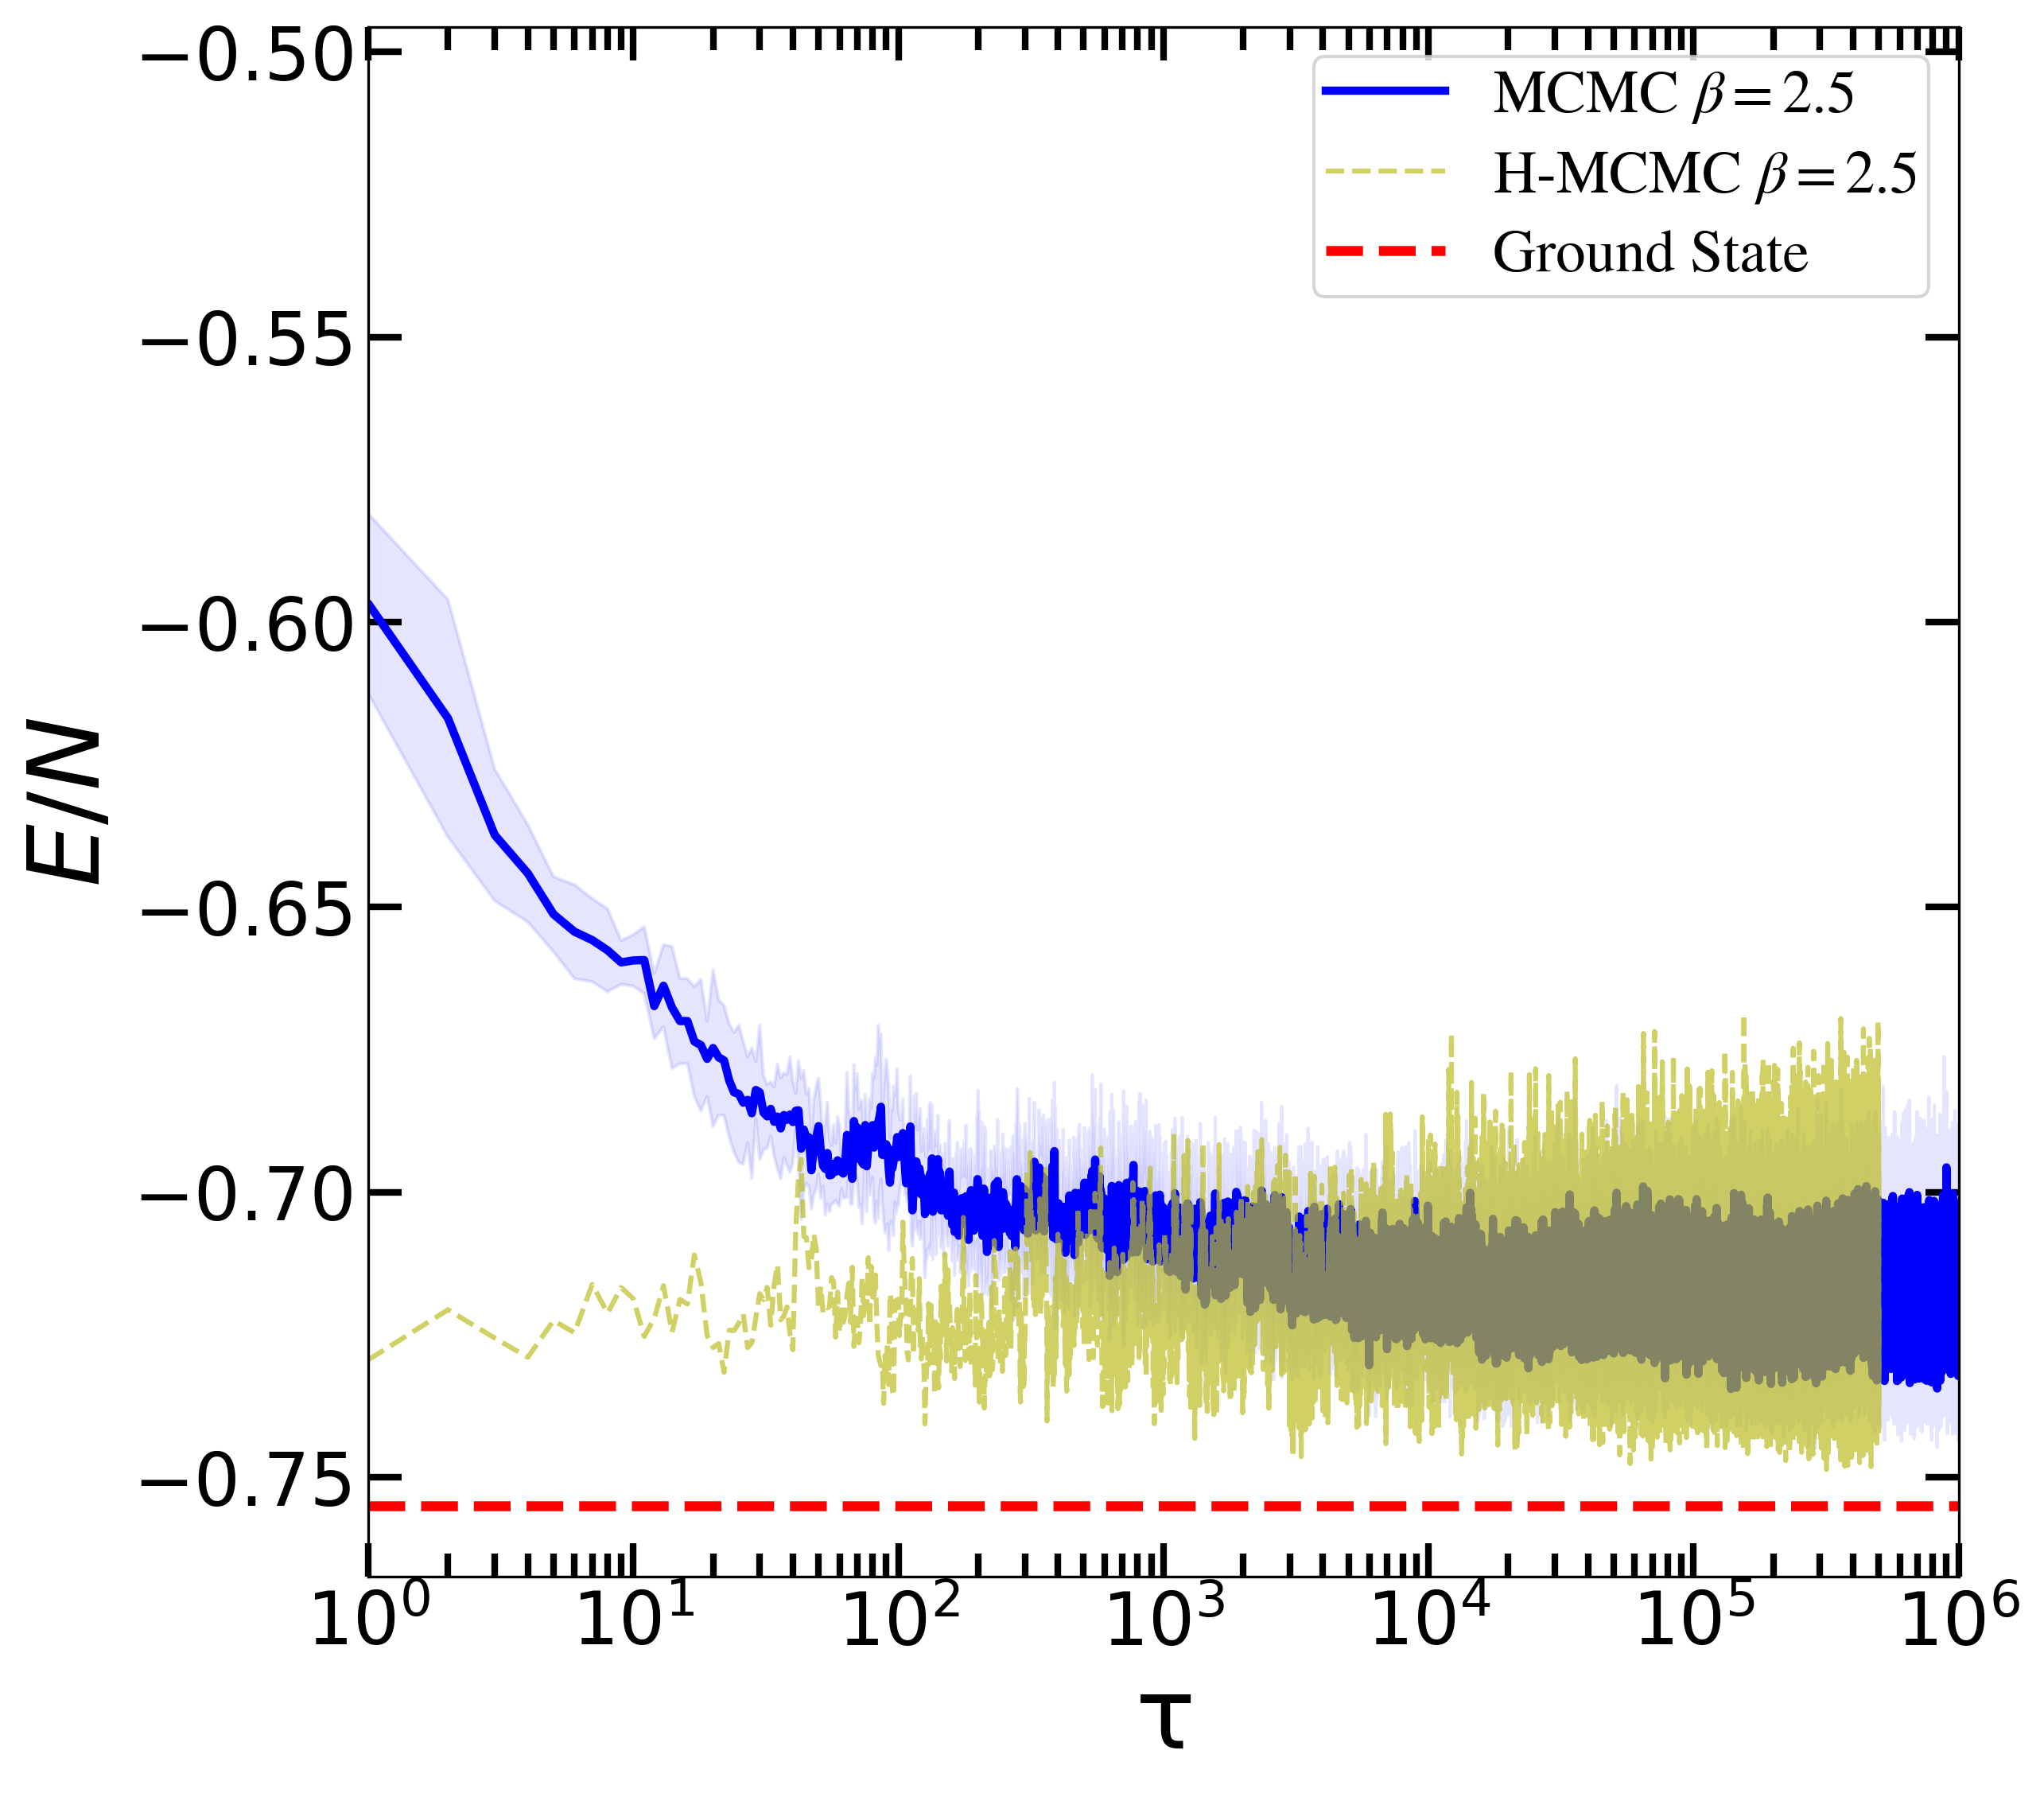

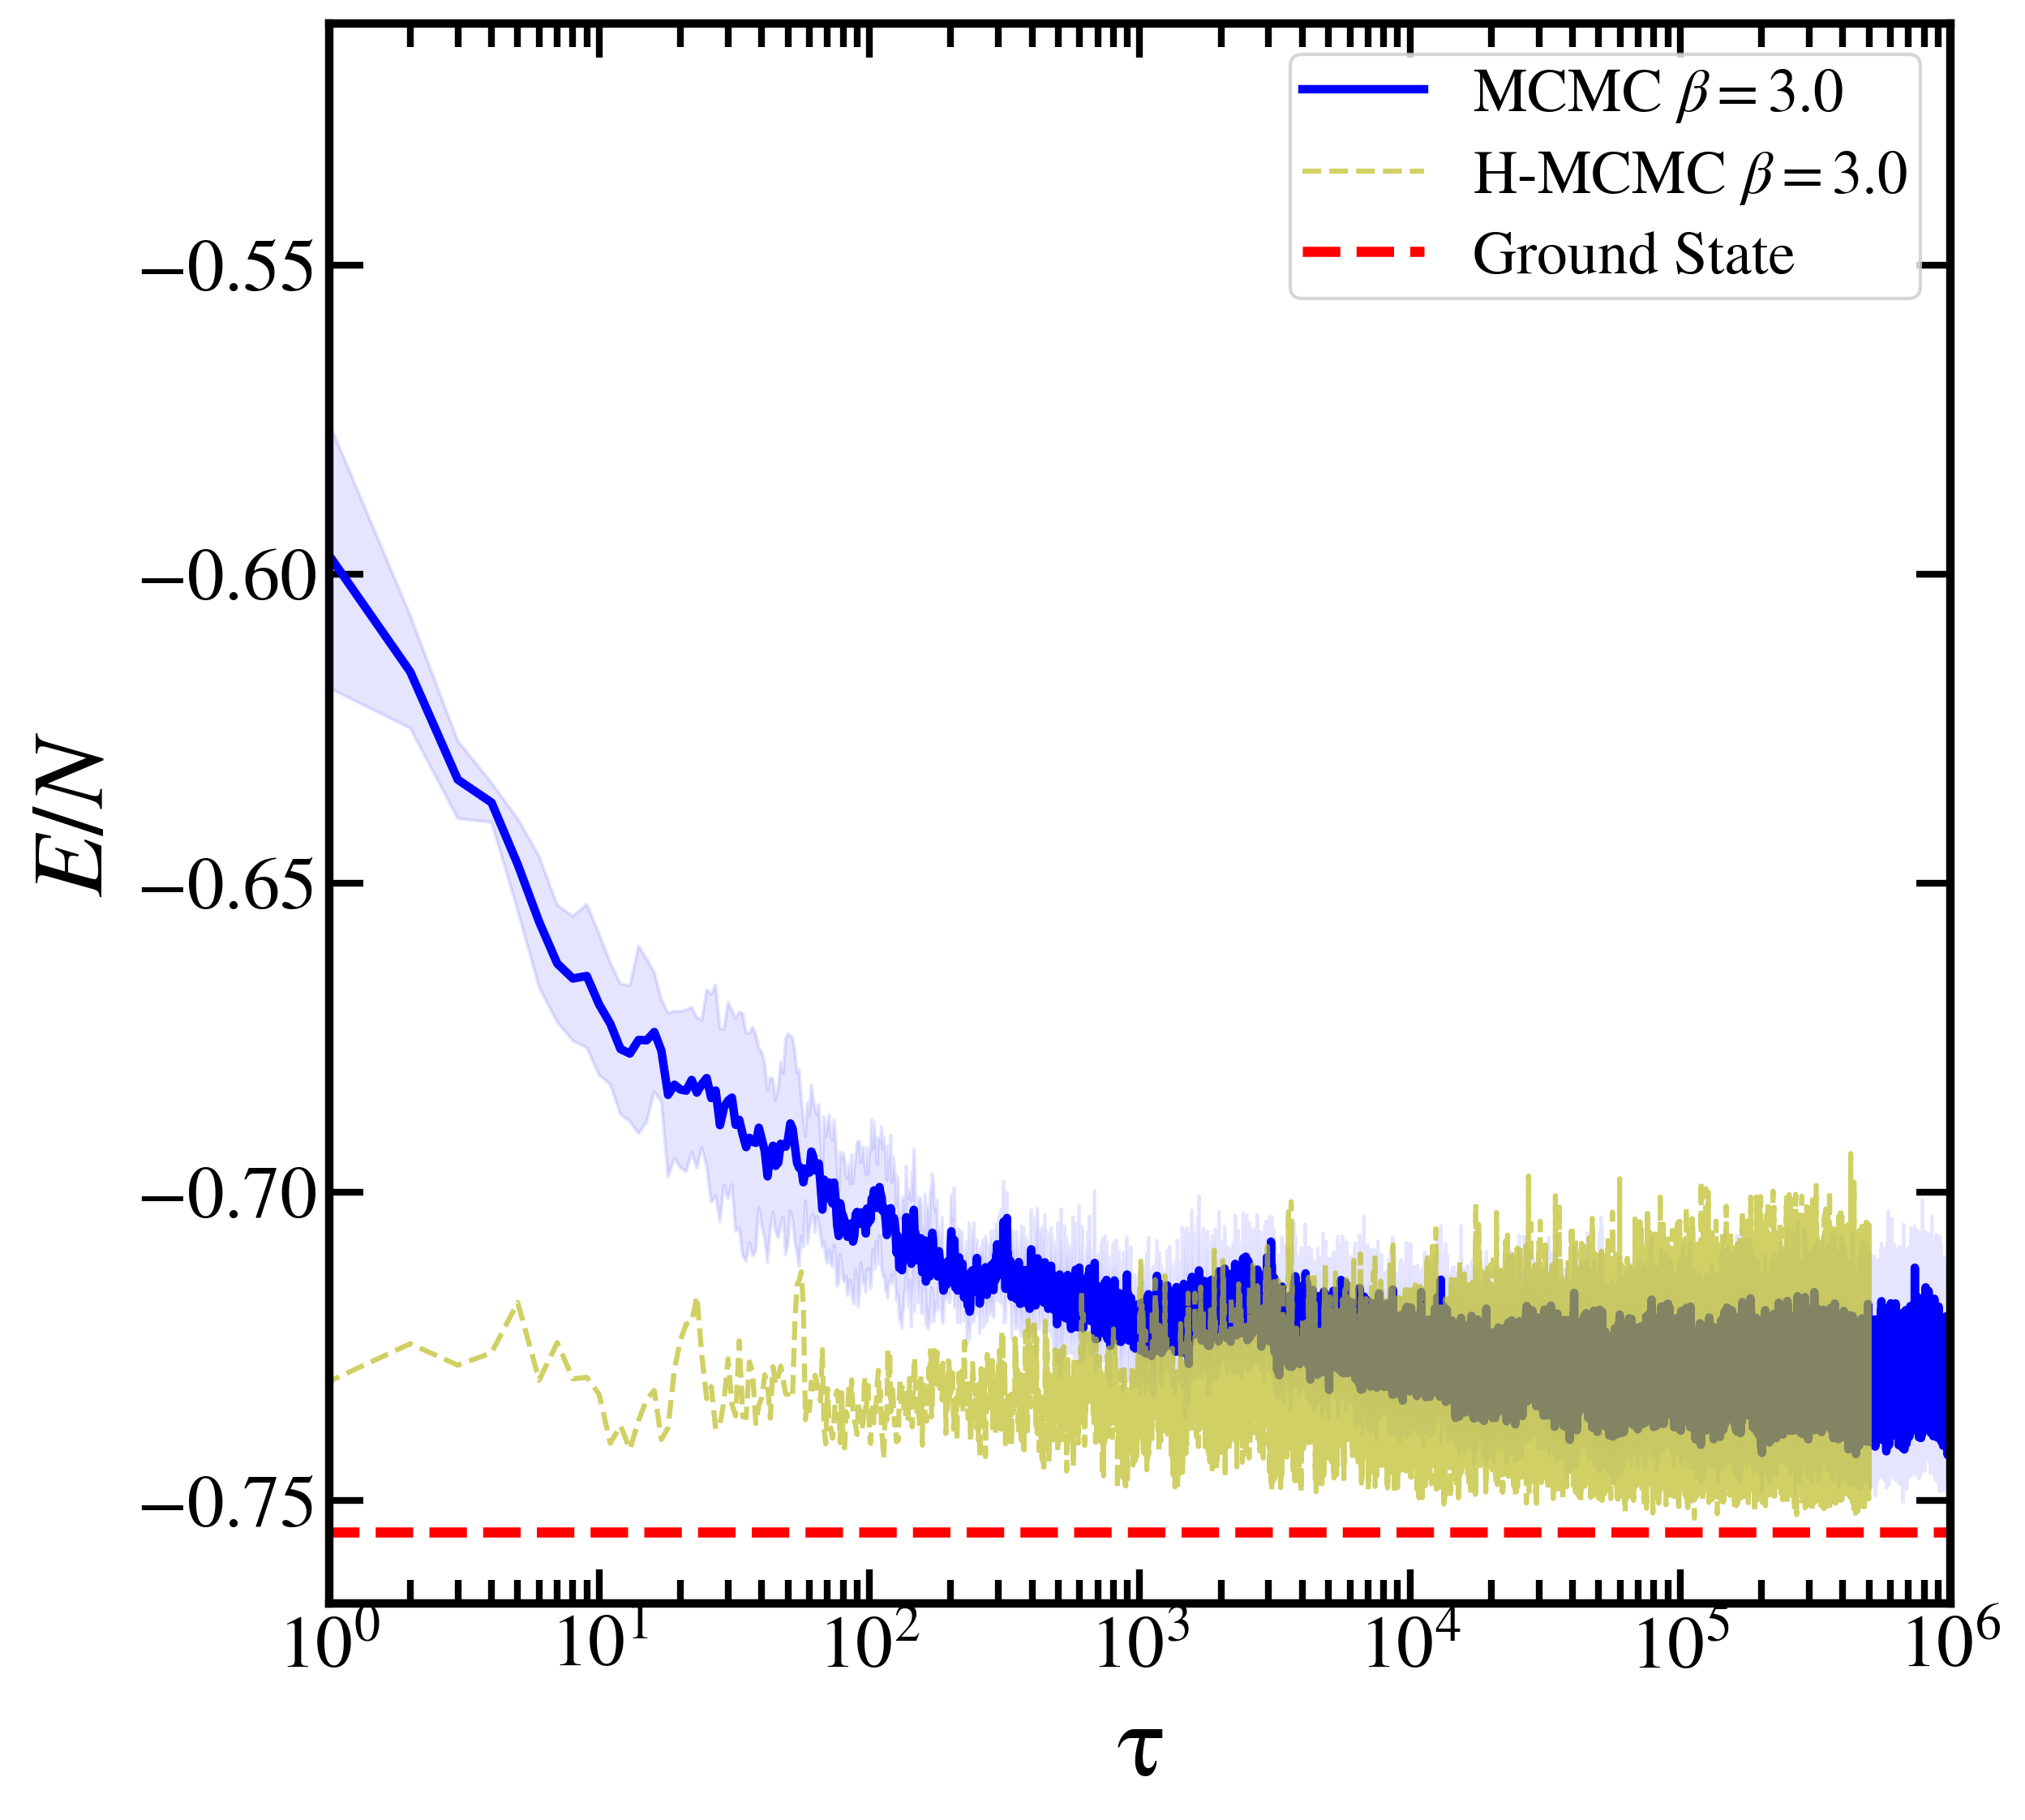

In [9]:
idxs = [10, 15, 20] #valid index in hybrid-MCMC

for i, idx in enumerate(idxs):
    if i==0:
        # gives error for the fist image
        continue
    plt_eng_step(single_engs[:,i,1:], eng_seq_hybrid[idx], rf"MCMC $\beta={betas[i]}$", rf"H-MCMC $\beta={betas[i]}$", ground_state=ground_state, save=False)

Moreover, we can compute the autocorrelation function, after removing the first samples for thermalization. The following plot in log scale shows that the autocorrelation lenght decays at least $10^2$ times faster in the neural than in the single spin flip simulation. The two simulation are run for $4 \cdot 10^5$ and $10^6$ steps, for the neural and the single spin flip. The plot is log scale and the shadow is the $\sigma$ obtained from 5 different simulations (only for single spin flip).
Autocorrelation is computed by
$$
c(\tau) = \frac{\langle H(t+\tau)H(t) \rangle - \langle H(t) \rangle^2}{\langle H(t)H(t) \rangle - \langle H(t) \rangle^2}
$$

Moreover, different $\beta$ lead to different autocorrelation lengths. In the following we give a visual representation of it.

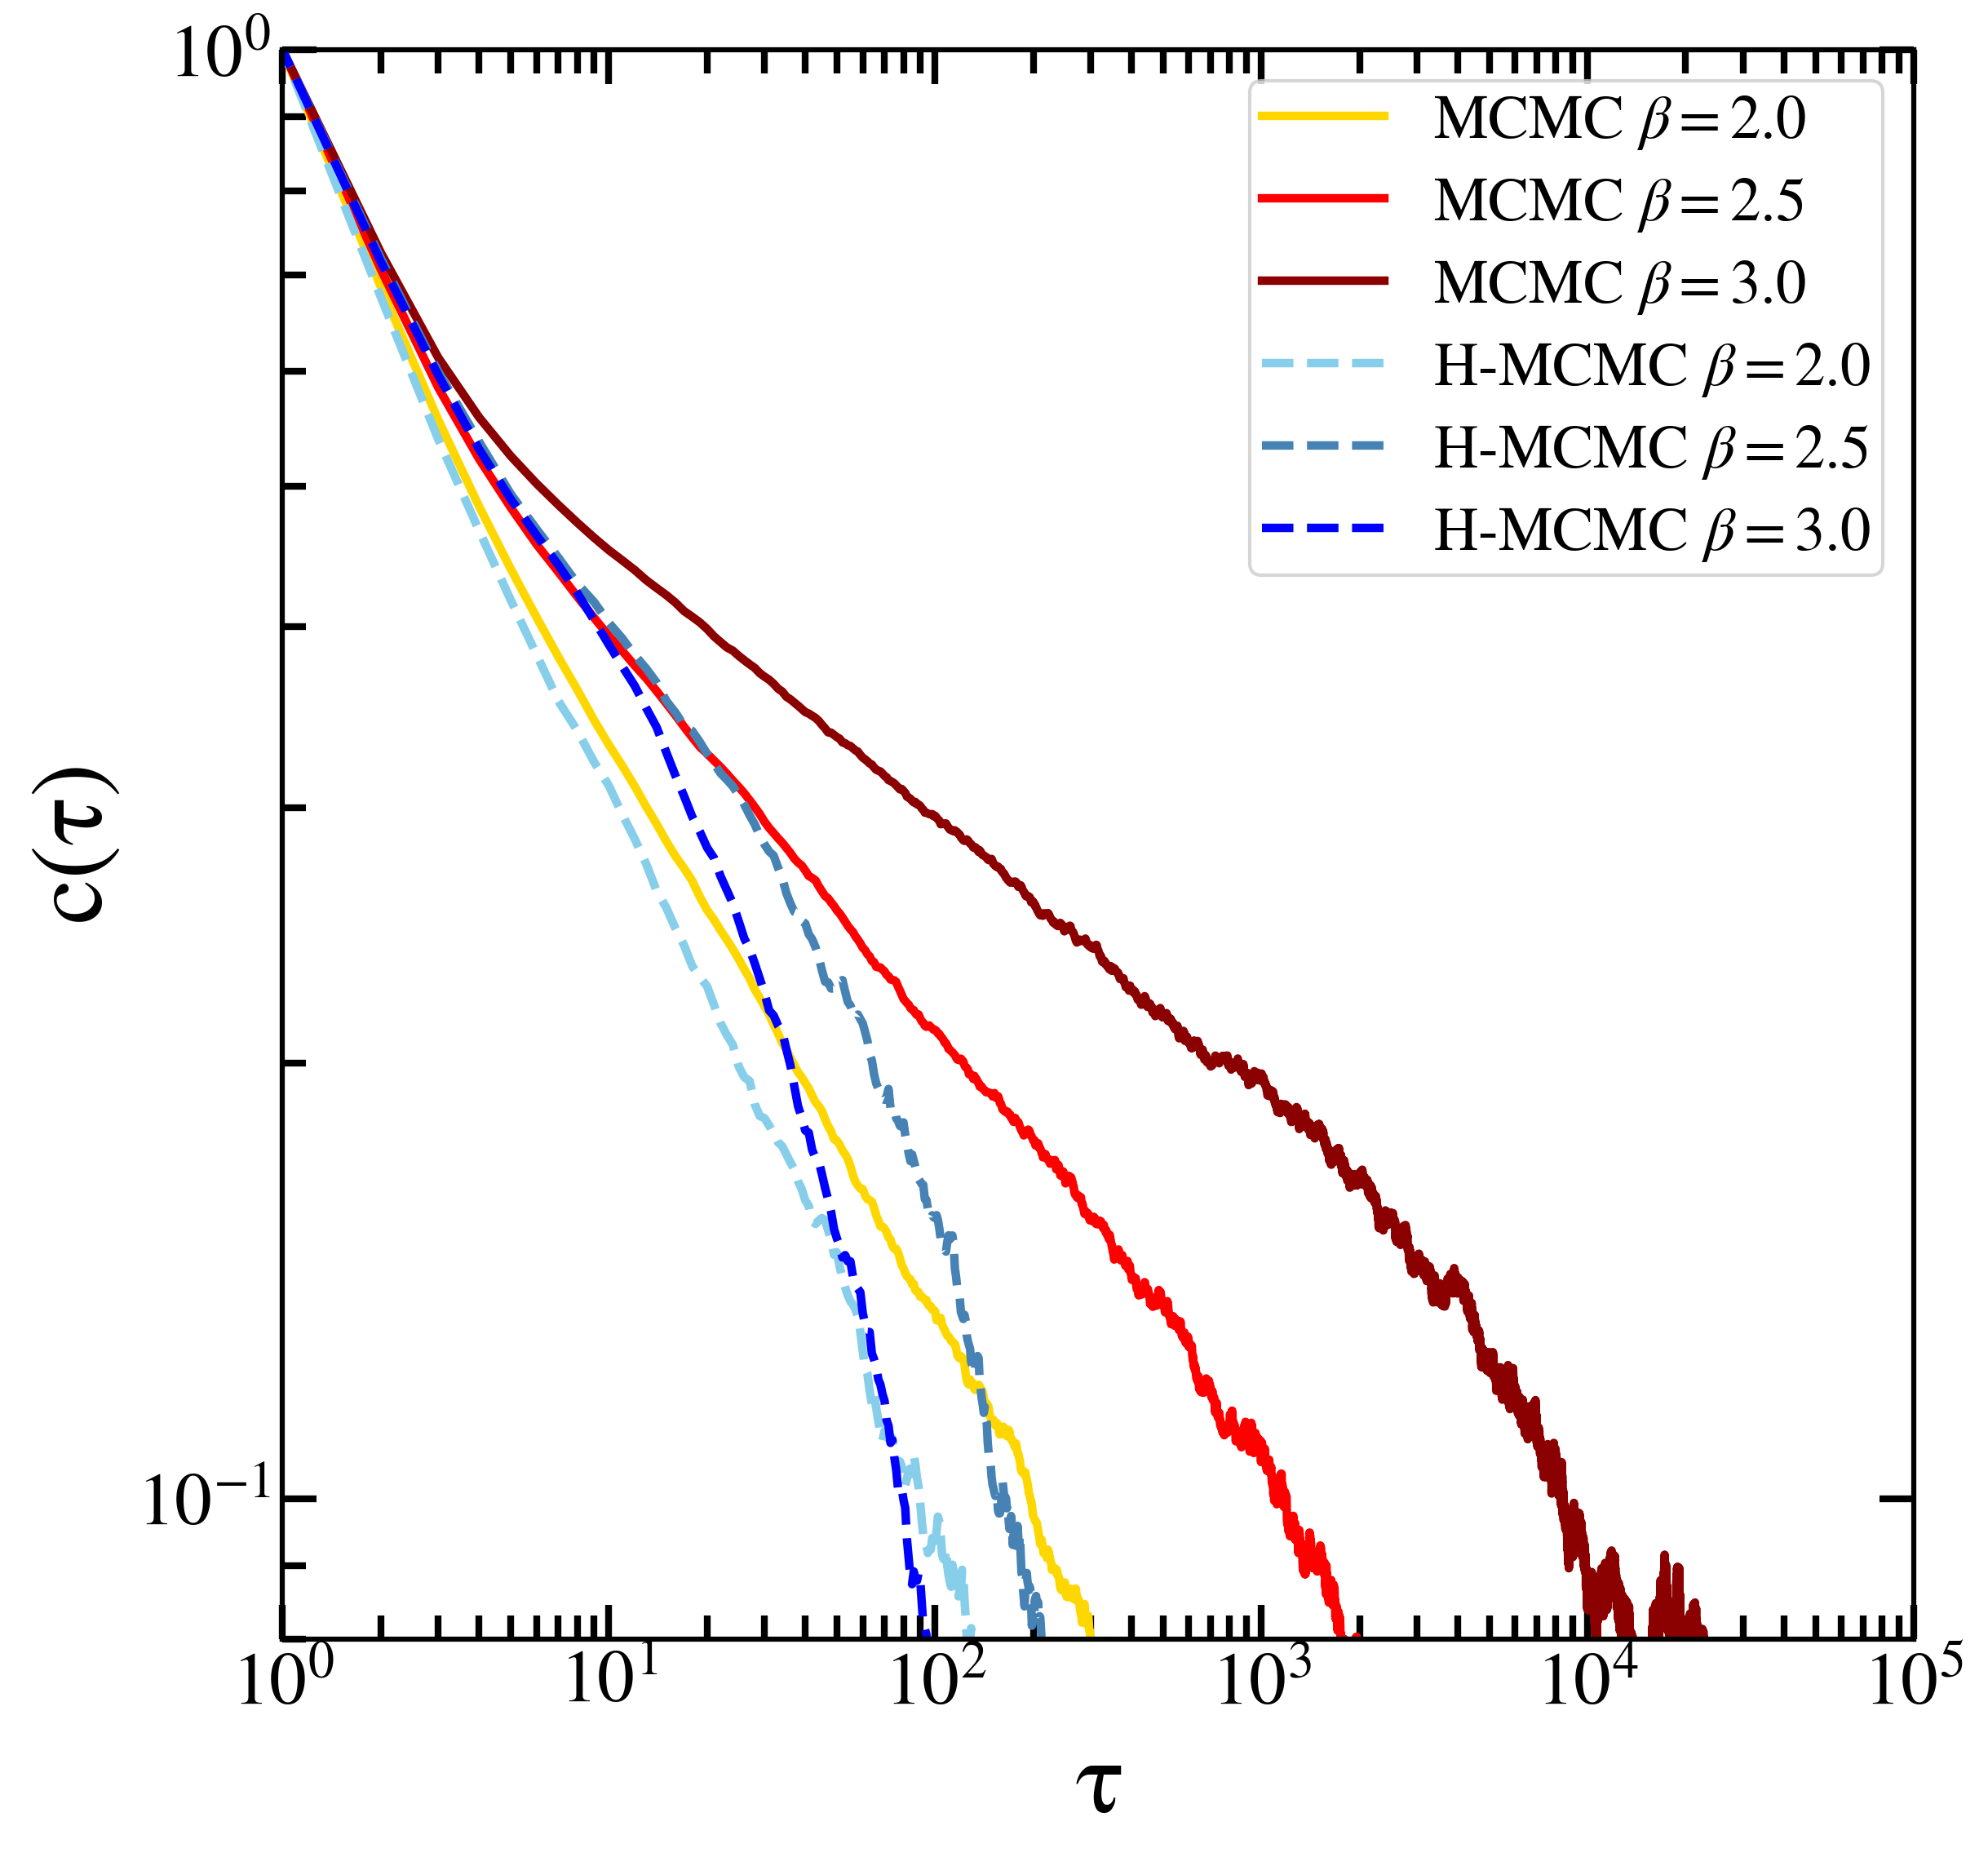

In [28]:
skip=100000 #skip the first samples, used for thermalization

ac_betas = []
ac_hybrid = []
for i, idx in enumerate(idxs):
    ac_betas.append(acf(single_engs[0,i,skip:], nlags=50000, fft=True))
    ac_hybrid.append(acf(eng_seq_hybrid[idx], nlags=50000, fft=True))

plt_acf_nofit(
    [ac_betas[0], ac_betas[1], ac_betas[2]], 
    [r"MCMC $\beta=2.0$", r"MCMC $\beta=2.5$", r"MCMC $\beta=3.0$"], 
    [ac_hybrid[0], ac_hybrid[1], ac_hybrid[2]], 
    [r"H-MCMC $\beta=2.0$", r"H-MCMC $\beta=2.5$", r"H-MCMC $\beta=3.0$"], 
    ylim=(0.08, 1), 
    xlim=(1, 100000), 
    save=False
)

In [42]:
# plot function


def fit_acf(
    acs1: Union[np.ndarray, List[np.ndarray]],
    label1: Union[str, List[str]],
    acs2: Optional[np.ndarray] = None,
    label2: Optional[str] = None,
    xlim: Tuple[int, int] = (1, 1000000),
    ylim: Tuple[int, int] = (0.01, 1),
    title: Optional[str] = None,
    fit: bool = False,
    log_scale: bool = True,
    save: bool = False,
):
    from scipy.optimize import curve_fit
    
    
    fig, ax = plt.subplots(figsize=(8.6, 8.6), dpi=300, facecolor="white")

    def stretch_exp(t, a, tau, alpha):
        return a * np.exp(-((t / tau) ** alpha))

    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"

    stringfont = "serif"

    ax.tick_params(
        axis="y",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=2,
        length=10,
        direction="in",
        labelsize=22,
    )
    ax.tick_params(
        axis="x",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=2,
        length=10,
        direction="in",
        labelsize=22,
    )
    ax.tick_params(
        which="minor",
        top=True,
        right=False,
        labeltop=False,
        labelright=False,
        width=2,
        length=7,
        direction="in",
        labelsize=22,
    )

    plt.rcParams["axes.linewidth"] = 2.5

    if isinstance(acs1, list):
        assert len(acs1) == len(label1)

        for i, acs in enumerate(acs1):
            color = next(ax._get_lines.prop_cycler)["color"]
            plt.plot(acs, label=label1[i], linewidth=2.5, color=color)
            ax.set_yscale("log")
            if fit:
                p, _ = curve_fit(
                    stretch_exp,
                    np.arange(xlim[1]),
                    acs[: xlim[1]],
                    bounds=([-np.inf, 0, 0], [np.inf, np.inf, np.inf]),
                )
                print(f"{label1[i]} a={p[0]} tau*={p[1]} alpha={p[2]}")
                plt.plot(
                    stretch_exp(np.arange(xlim[1]), p[0], p[1], p[2]),
                    "--",
                    color=color,
                )
    else:
        plt.plot(acs1.mean(0), label=label1, linewidth=1.5)
        plt.fill_between(
            np.arange(acs1.shape[1]),
            acs1.mean(0) + acs1.std(0),
            acs1.mean(0) - acs1.std(0),
            alpha=0.1,
            color="b",
        )

    if acs2 is not None:
        plt.plot(acs2, "--", label=label2, linewidth=2.0)

    if log_scale:
        ax.set_xscale("log")

    plt.ylabel(
        r"$\mathrm{c(\tau)}$", fontsize=30, fontfamily=stringfont, fontweight="bold"
    )
    plt.xlabel(
        r"$\mathrm{\tau}$", fontsize=30, fontfamily=stringfont, fontweight="bold"
    )

    plt.ylim(ylim)
    plt.xlim(xlim)

    if title is not None:
        plt.title(title, fontsize=18, fontfamily=stringfont)

    plt.legend(loc="best", fontsize=18, labelspacing=0.4, borderpad=0.2, fancybox=True)

    if save:
        plt.savefig(
            "images/fit_correlation.png",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            bbox_inches="tight",
            transparent=False,
        )
        plt.savefig(
            "images/fit_correlation.eps",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            bbox_inches="tight",
            transparent=False,
            format="eps",
        )
    plt.show()
    return 


Here we plot some autocorrelation functions, using log representation long the $y$ axis. Moreover, we fit these autocerrelations with a stretch exponential function
$$ 
c(\tau) = a\exp(\left[-(\tau/\tau^*)^\alpha\right]).
$$
We print the empirical-fitted parameters below with the plot af outocorrelation from $\beta=2.0$ to $\beta=3.0$. As one can see, $\tau^*$ quickly diverges and starting from $\beta \geq 3.0$ we find $\tau^* \simeq 8$, i.e., $\tau^*_{single} \simeq 3800$.

$\beta=2.0$ a=1.0335148840356845 tau*=5.664998129692427 alpha=0.2435722132155389
$\beta=2.5$ a=1.0387053738891863 tau*=8.471841607387688 alpha=0.17580772249579424
$\beta=3.0$ a=1.0599455821317434 tau*=16.63103869740536 alpha=0.1311628716108515


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


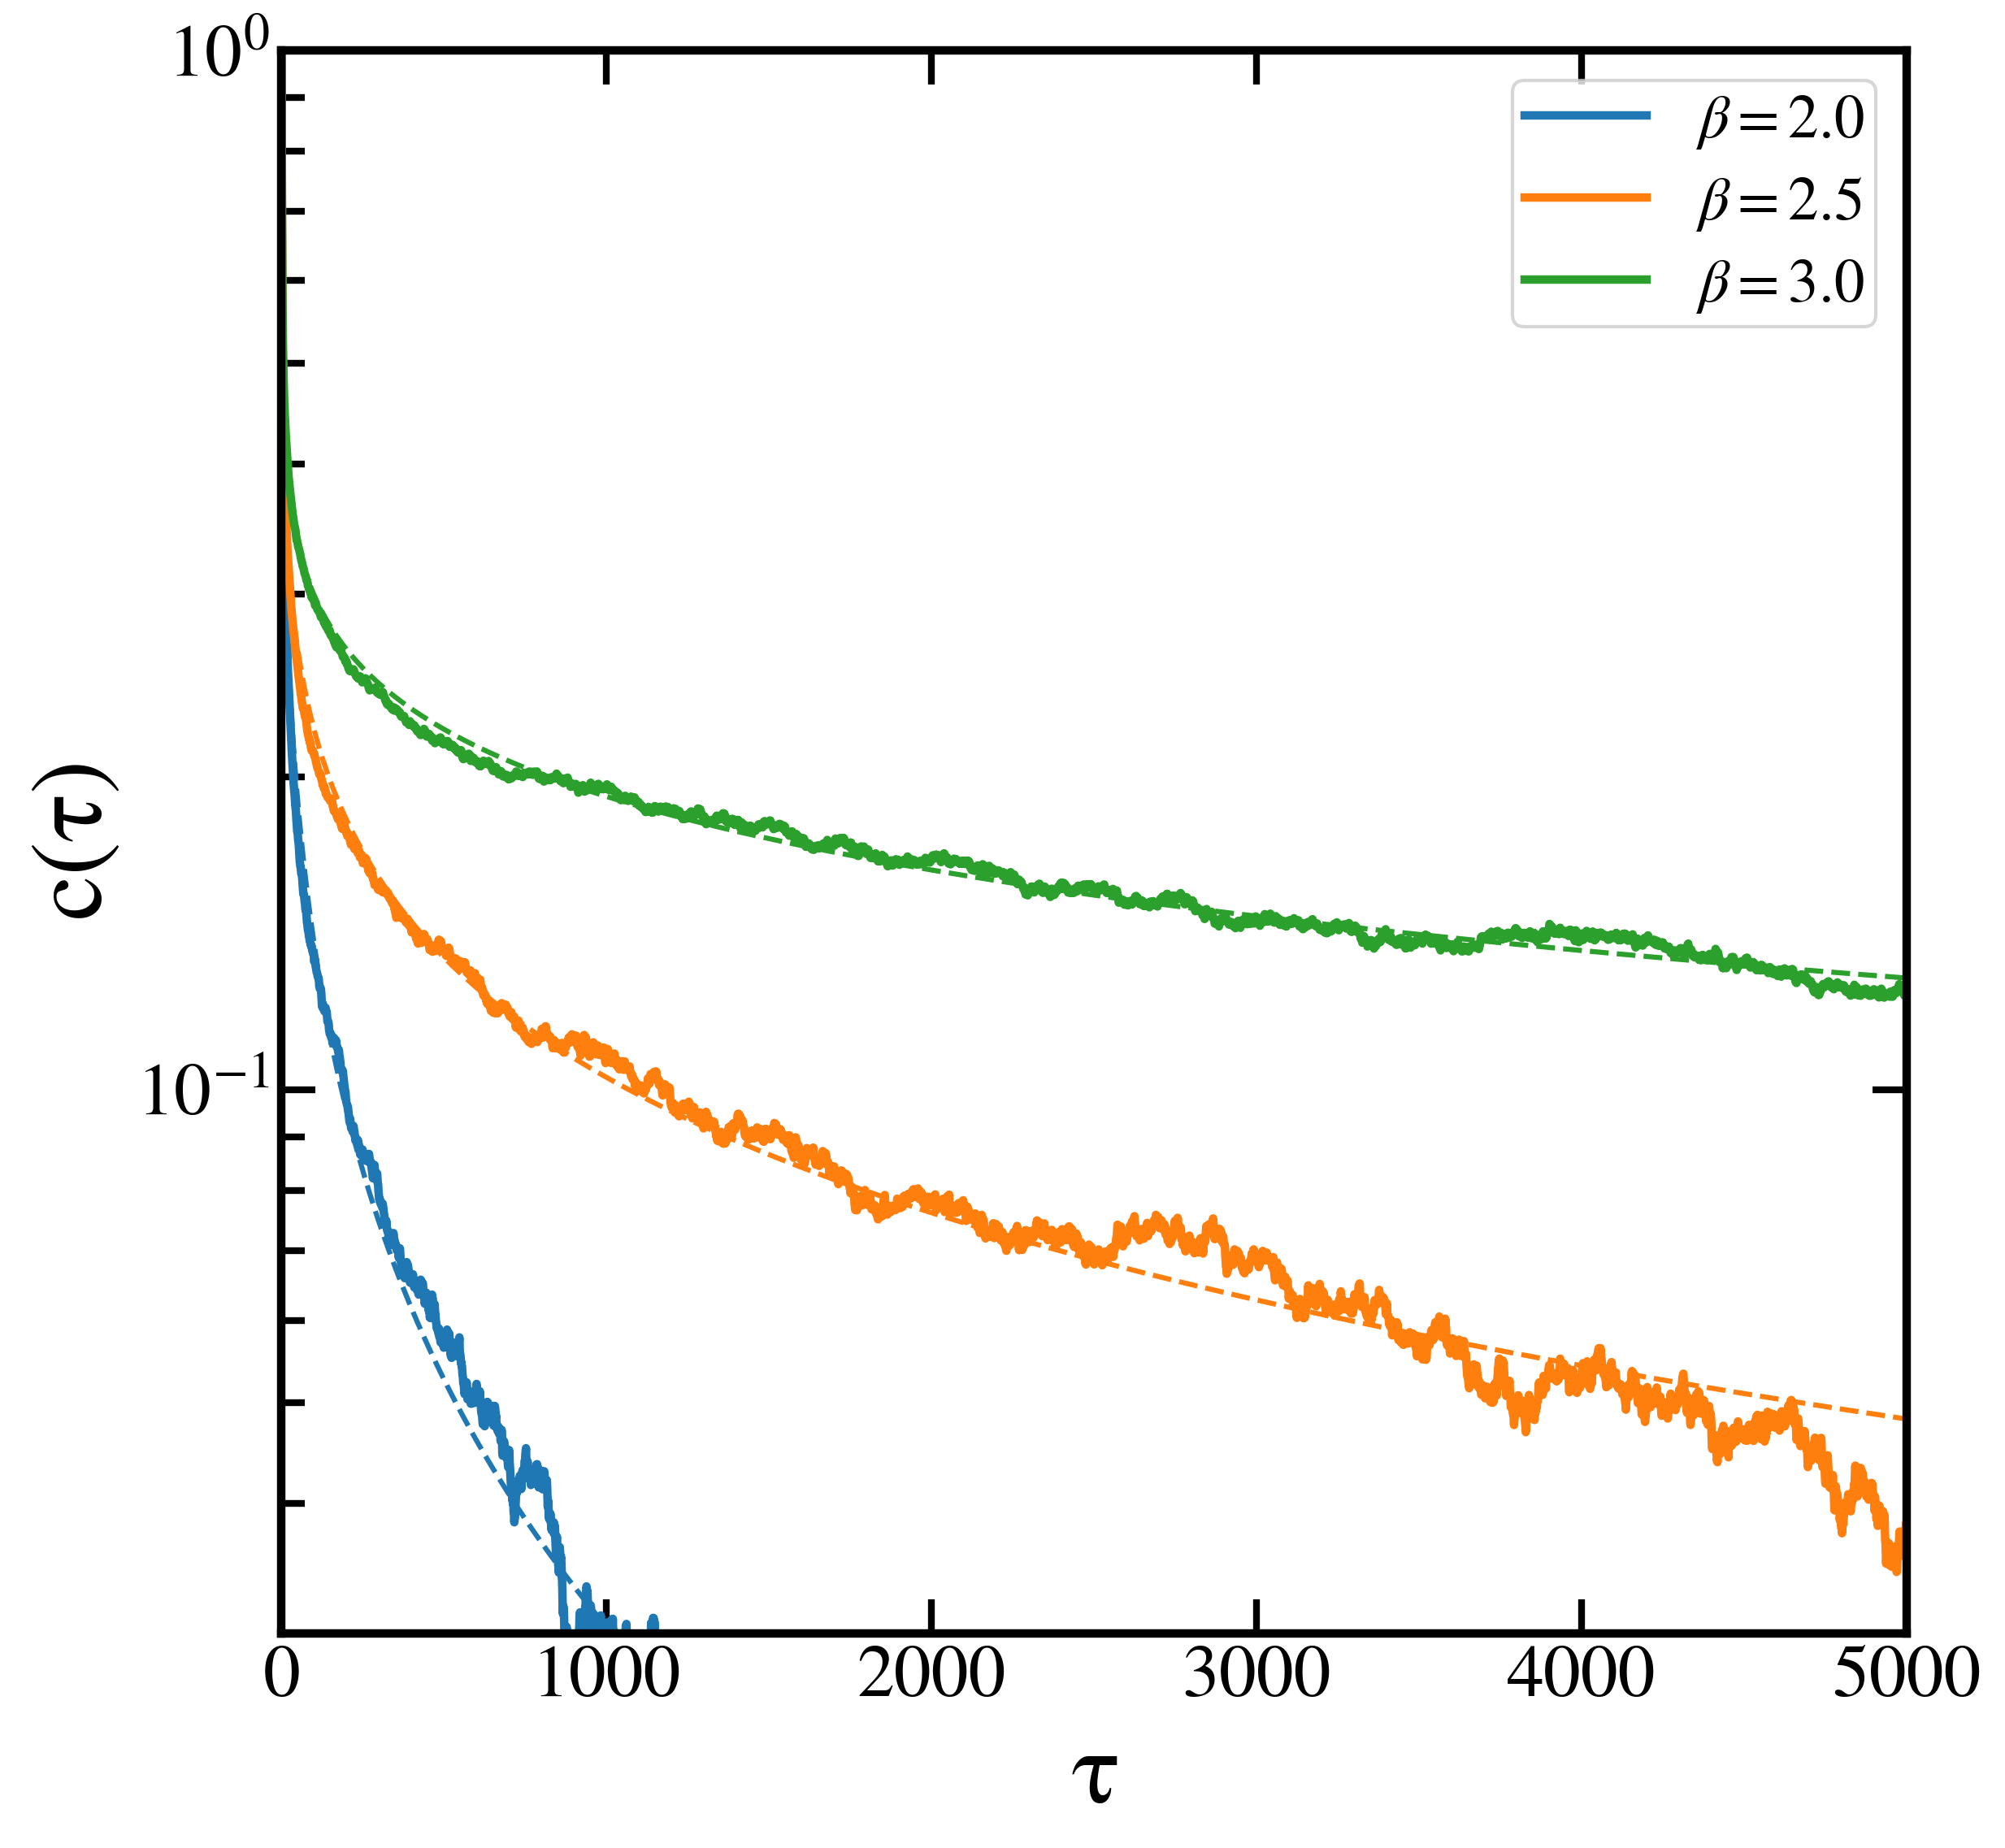

In [43]:
label1 = [rf"$\beta={beta}$" for beta in betas]

fit_acf(ac_betas, label1, log_scale=False, xlim=(0, 5000), ylim=(0.03, 1), fit=True, save=True)


## Hybrid Algorithm

Here we do the same analisys for the *Hybrid MCMC*.


## Energies Comparison

Comparison between energies for 484 spins 1 NN.

In [13]:
single12345 = np.load("data/MCMC_single/eng_longMCMC/eng_single12345.npy")
single23451 = np.load("data/MCMC_single/eng_longMCMC/eng_single23451.npy")
single34512 = np.load("data/MCMC_single/eng_longMCMC/eng_single34512.npy")
single45123 = np.load("data/MCMC_single/eng_longMCMC/eng_single45123.npy")
single51234 = np.load("data/MCMC_single/eng_longMCMC/eng_single51234.npy")


single_all = np.concatenate((single12345[None, ...], single23451[None, ...], single34512[None, ...], single45123[None, ...], single51234[None, ...]), axis=0)
single_all.shape

(5, 21, 200000)

In [14]:
# utility function

def block_std(engs: List[Any], len_block: int, skip: int = 0) -> float:
    """Compute the block std of a list of arrays.
    See http://chimera.roma1.infn.it/SP/doc/estratti/dataAnalysis.pdf

    Args:
        engs (List[Any]): List of energies arrays.
        len_block (int): Block lenght to compute std.
        skip (int, optional): Number of initial sample to skip. Defaults to 0.

    Returns:
        float: Block std.
    """
    std_engs = []
    for eng in engs:
        if isinstance(eng, list):
            eng = np.asarray(eng)
        eng = eng[skip:].copy()
        rest_len = eng.size % len_block
        if rest_len != 0:
            eng = eng[:-rest_len]
        eng = eng.reshape(-1, len_block)
        new_len = eng.shape[0]
        if new_len < 100:
            print(f"WARNING: New Len {new_len} < 100")
        error = np.std(eng.mean(axis=1), ddof=0) / np.sqrt(new_len - 1)
        std_engs.append(error)
    return std_engs


### Plot Error vs Block Size

In [59]:
max_len_block = 10000
num_blocks = 500
skip = 1000

len_blocks = np.linspace(1, max_len_block, num=num_blocks, dtype=np.int)
block_stds = []
for len_block in len_blocks:
    block_stds.append(block_std(single_all[0, :].tolist(), len_block, skip=skip))
block_stds = np.asarray(block_stds)

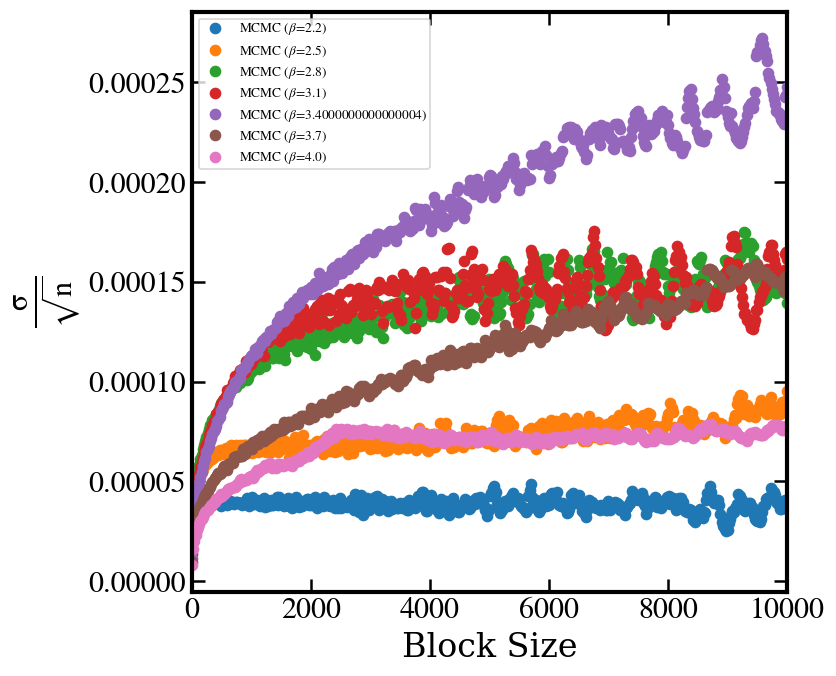

In [60]:
fig, ax = plt.subplots(figsize=(6.4, 6.4), dpi=120, facecolor='white')

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 2.5

stringfont = 'serif'

ax.tick_params(axis='y', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)
ax.tick_params(axis='x', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)


for i in range(block_stds.shape[-1]):
    if (i+1) % 3 != 0:
        continue
    plt.plot(np.linspace(1, max_len_block, num_blocks), block_stds[:, i], "o", label=rf"MCMC ($\beta$={betas[i]})")

plt.xlim(-0.5,max_len_block)
#plt.ylim(0,1.2)



plt.ylabel(r"$\mathrm{\frac{\sigma}{\sqrt{n}}}$", fontsize=26, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"Block Size", fontsize=20, fontfamily=stringfont)

plt.legend(loc='best', fontsize=8, labelspacing=0.4, borderpad=0.2)

plt.savefig("images/std-blocksize.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [50]:
max_len_block = 3000
num_blocks = 100
skip = 0

len_blocks = np.linspace(1, max_len_block, num=num_blocks, dtype=np.int)
block_stds = []
for len_block in len_blocks:
    block_stds.append(block_std(eng_seq_hybrid[10:], len_block, skip=skip))
block_stds = np.asarray(block_stds)

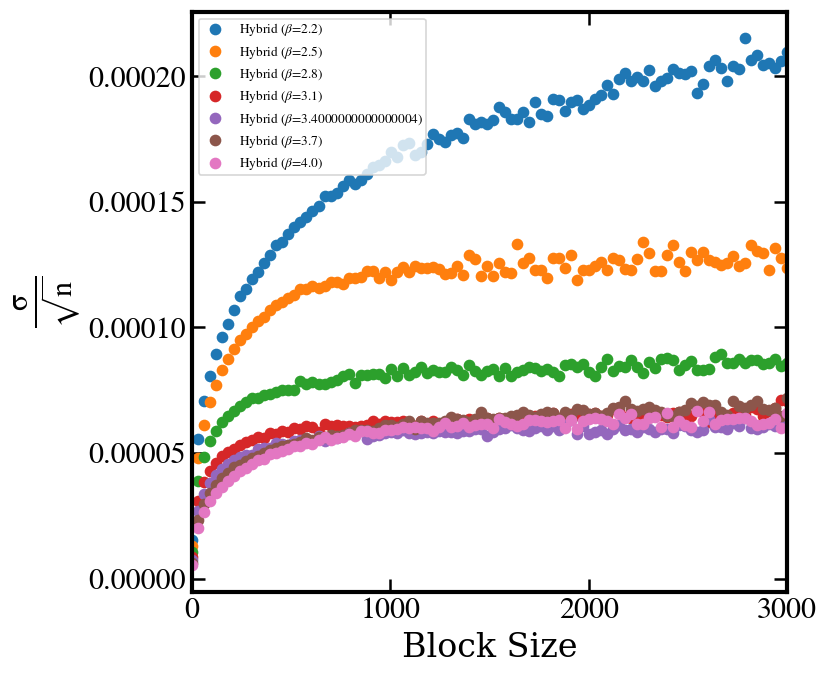

In [51]:
fig, ax = plt.subplots(figsize=(6.4, 6.4), dpi=120, facecolor='white')

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 2.5

stringfont = 'serif'

ax.tick_params(axis='y', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)
ax.tick_params(axis='x', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)


for i in range(block_stds.shape[-1]):
    if (i+1) % 3 != 0:
        continue
    plt.plot(np.linspace(1, max_len_block, num_blocks), block_stds[:, i], "o", label=rf"Hybrid ($\beta$={betas[i]})")

plt.xlim(-0.5,max_len_block)
#plt.ylim(0,1.2)



plt.ylabel(r"$\mathrm{\frac{\sigma}{\sqrt{n}}}$", fontsize=26, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"Block Size", fontsize=20, fontfamily=stringfont)

plt.legend(loc='best', fontsize=8, labelspacing=0.4, borderpad=0.2)

plt.savefig("images/std-blocksize.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')

### Compare Energy vs $\beta$

In [153]:
betas = np.linspace(2., 4, 21)
print(betas)
neural_eng_100mu = []
for beta in betas:
    _, eng, _ = neural_mcmc(beta, 1000000, datasets[2], couplings_path, model='made', disable_bar=True)
    neural_eng_100mu.append(eng/484)
neural_eng_100mu = np.asarray(neural_eng_100mu)

[2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7
 3.8 3.9 4. ]

Performing Neural MCMC at beta=2.0
Steps: 1000000 A_r=0.04%
E=-0.703639 ± 0.000008  [σ=0.008122  E_min=-0.742019]
Duration 0:00:22.636727

Performing Neural MCMC at beta=2.1
Steps: 1000000 A_r=0.18%
E=-0.713835 ± 0.000007  [σ=0.007491  E_min=-0.743053]
Duration 0:00:22.795634

Performing Neural MCMC at beta=2.2
Steps: 1000000 A_r=0.25%
E=-0.712683 ± 0.000010  [σ=0.010476  E_min=-0.744658]
Duration 0:00:22.820673

Performing Neural MCMC at beta=2.3
Steps: 1000000 A_r=0.44%
E=-0.718364 ± 0.000009  [σ=0.009476  E_min=-0.745501]
Duration 0:00:22.704057

Performing Neural MCMC at beta=2.4
Steps: 1000000 A_r=0.67%
E=-0.720685 ± 0.000009  [σ=0.009499  E_min=-0.748132]
Duration 0:00:22.727576

Performing Neural MCMC at beta=2.5
Steps: 1000000 A_r=1.04%
E=-0.723745 ± 0.000007  [σ=0.007195  E_min=-0.749862]
Duration 0:00:22.799240

Performing Neural MCMC at beta=2.6
Steps: 1000000 A_r=0.24%
E=-0.727229 ± 0.00

In [148]:
max_len_block = 3000
num_blocks = 100
skip = 0

len_blocks = np.linspace(1, max_len_block, num=num_blocks, dtype=np.int)
block_stds = []
for len_block in len_blocks:
    block_stds.append(block_std(neural_eng_100mu, len_block, skip=skip))
block_stds = np.asarray(block_stds)

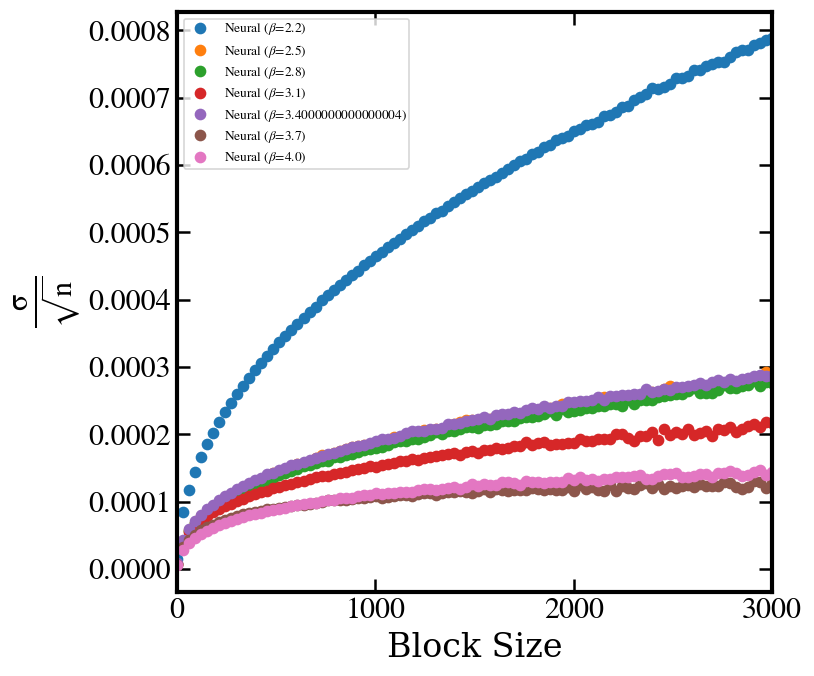

In [149]:
fig, ax = plt.subplots(figsize=(6.4, 6.4), dpi=120, facecolor='white')

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 2.5

stringfont = 'serif'

ax.tick_params(axis='y', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)
ax.tick_params(axis='x', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)


for i in range(block_stds.shape[-1]):
    if (i+1) % 3 != 0:
        continue
    plt.plot(np.linspace(1, max_len_block, num_blocks), block_stds[:, i], "o", label=rf"Neural ($\beta$={betas[i]})")

plt.xlim(-0.5,max_len_block)
#plt.ylim(0,1.2)



plt.ylabel(r"$\mathrm{\frac{\sigma}{\sqrt{n}}}$", fontsize=26, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"Block Size", fontsize=20, fontfamily=stringfont)

plt.legend(loc='best', fontsize=8, labelspacing=0.4, borderpad=0.2)

plt.savefig("images/std-blocksize.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [151]:
betas = np.linspace(2., 4, 21)
print(betas)
single_block_size = 6000
hybrid_block_size = 4000
neural_block_size = 2000
skip_single = 50000
skip_hybrid = 20000
skip_neural = 0

[2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7
 3.8 3.9 4. ]


In [140]:
def block_single_std(engs: List[Any], len_block: int, skip: int = 0) -> float:
    """Compute the block std of a list of arrays.
    See http://chimera.roma1.infn.it/SP/doc/estratti/dataAnalysis.pdf

    Args:
        engs (List[Any]): List of energies arrays.
        len_block (int): Block lenght to compute std.
        skip (int, optional): Number of initial sample to skip. Defaults to 0.

    Returns:
        float: Block std.
    """
    std_engs = []
    for i in range(engs.shape[0]):
        eng_seed = engs[i]
        error = []
        for eng in eng_seed:
            if isinstance(eng, list):
                eng = np.asarray(eng)
            eng = eng[skip:].copy()
            rest_len = eng.size % len_block
            if rest_len != 0:
                eng = eng[:-rest_len]
            eng = eng.reshape(-1, len_block)
            new_len = eng.shape[0]
            if new_len < 100:
                pass#print(f"WARNING: New Len={new_len} < 100")
            error.append(np.std(eng.mean(axis=1), ddof=0) / np.sqrt(new_len - 1))
        std_engs.append(error)
    return std_engs

In [ ]:
yerr = block_single_std(single_all, len_block=single_block_size, skip=skip_single)
yerr = np.asarray(yerr)

single_all2 = single_all[...,skip_single:].mean(2)
for i in range(21):
    fig = plt.figure()
    plt.title(f"{betas[i]}")
    plt.errorbar(range(5), single_all2[:,i], yerr[:, i])
    plt.hlines(single_all2[:,i].mean(0), 0, 4, color="red", linestyles="dashed")
    plt.show()

In [144]:

yerr = block_single_std(single_all, len_block=single_block_size, skip=skip_single)
new_err = [
           np.abs(np.min(single_all[..., skip_single:].mean(axis=2) - yerr - single_all[..., skip_single:].mean(axis=2).mean(0), axis=0)),
           np.abs(np.max(single_all[..., skip_single:].mean(axis=2).mean(0) - (single_all[..., skip_single:].mean(axis=2) + yerr), axis=0))
           ]
new_err = np.asarray(new_err)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


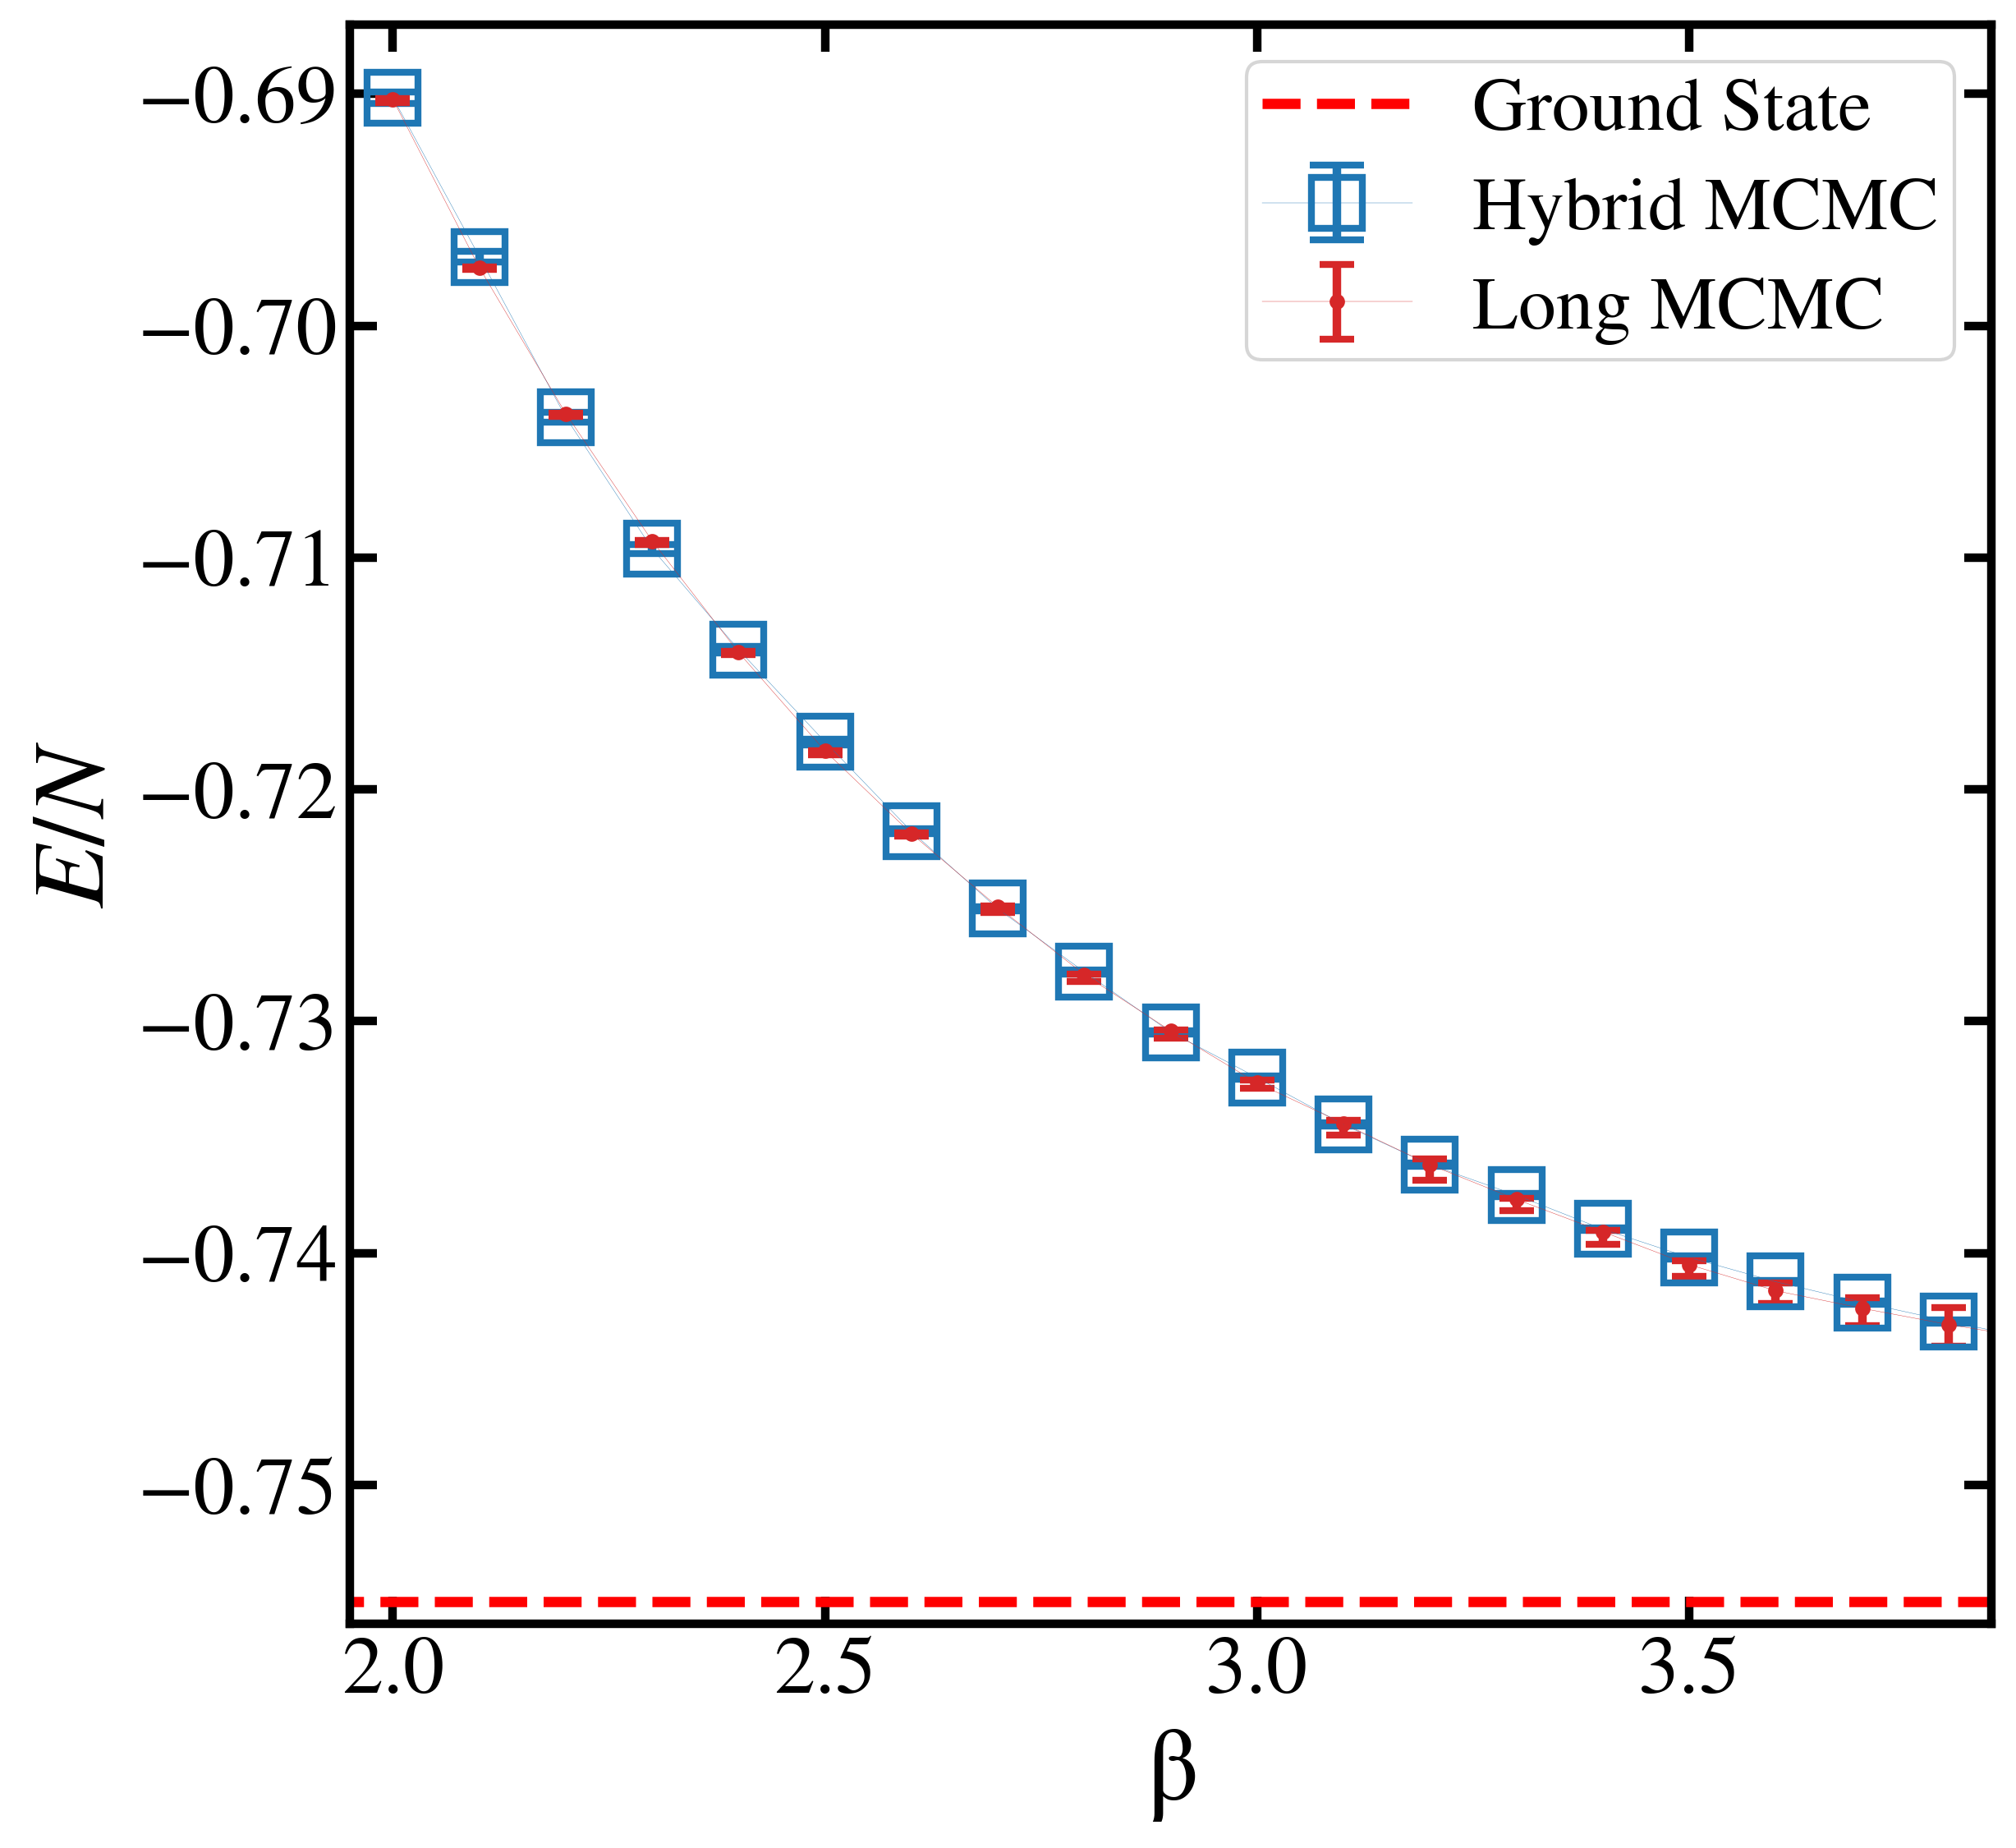

In [143]:
fig, ax = plt.subplots(figsize=(8.6, 8.6),  facecolor='white', dpi=300)

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 2.5

stringfont = 'serif'

ax.tick_params(axis='y', top=True, right=True, labeltop=False, labelright=False, width=2.5, length=8, direction='in', labelsize=24)
ax.tick_params(axis='x', top=True, right=True, labeltop=False, labelright=False, width=2.5, length=8, direction='in', labelsize=24)


plt.errorbar(betas, np.asarray(eng_seq_hybrid[10:])[...,skip_hybrid:].mean(1), yerr=block_std(eng_seq_hybrid[10:], hybrid_block_size, skip=skip_hybrid), elinewidth=2.5, linewidth=.1, marker='s', fillstyle='none', markersize=15, markeredgewidth=2, capsize=8, label=r"Hybrid MCMC")
#plt.errorbar(betas, neural_eng_100mu.mean(1), yerr=block_std(neural_eng_100mu, 1000, skip=skip), elinewidth=1.5, linewidth=.1, marker='o', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Neural MCMC")
plt.errorbar(betas, (single_all[..., skip_single:].mean(axis=2).mean(axis=0).tolist()), yerr=new_err, elinewidth=2.5, linewidth=.1, marker='o', color='tab:red', fillstyle='none', markersize=5, markeredgewidth=2, capsize=5, label=r"Long MCMC")



plt.hlines(ground_state, xmin=0.4, xmax=4.4, colors='red', linestyles='dashed', label="Ground State", linewidth=3)


#plt.xlim(2.45, 3.25)
plt.xlim(1.95, 3.85)
#plt.ylim(-0.740, -0.716)
plt.ylim(-0.756, -0.687)

plt.ylabel(r"$E/N$", fontsize=30, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"$\mathrm{\beta}$", fontsize=30, fontfamily=stringfont, fontweight='bold')

#plt.title(f"Skip {skip} Block Lenght {block_size}", fontsize=12, fontfamily=stringfont, fontweight='bold')


plt.legend(loc='best', fontsize=22, labelspacing=0.4, borderpad=0.2, fancybox=True)
#ax.set_title('fancy, transparent legends')

# axins2 = inset_axes(ax, width="30%", height="30%", loc=3, borderpad=4)
# axins2.tick_params(labelleft=False, labelbottom=False)
# axins2.errorbar(betas[8:16], np.asarray(eng_seq_hybrid[10:])[8:16,skip:].mean(1), yerr=block_std(eng_seq_hybrid[10:][8:16], hybrid_block_size, skip=skip), elinewidth=2.5, linewidth=.1, marker='s', fillstyle='none', markersize=15, markeredgewidth=2, capsize=8, label=r"Hybrid MCMC")
# axins2.errorbar(betas[8:16], (single_all[:,8:16, skip:].mean(axis=2).mean(axis=0).tolist()), yerr=single_all[:,8:16, skip:].mean(axis=2).std(axis=0) / np.sqrt(single_all.shape[0]-1), elinewidth=2.5, linewidth=.1, marker='.', color='tab:red', fillstyle='none', markersize=15, markeredgewidth=2, capsize=8, label=r"Long MCMC")


plt.savefig(
    "images/energy-beta.png",
    edgecolor='white', 
    facecolor=fig.get_facecolor(), 
    bbox_inches='tight', 
    transparent=False
)
plt.savefig(
    "images/energy-beta.eps",
    edgecolor="white",
    facecolor=fig.get_facecolor(),
    # transparent=True,
    bbox_inches="tight",
    format="eps",
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


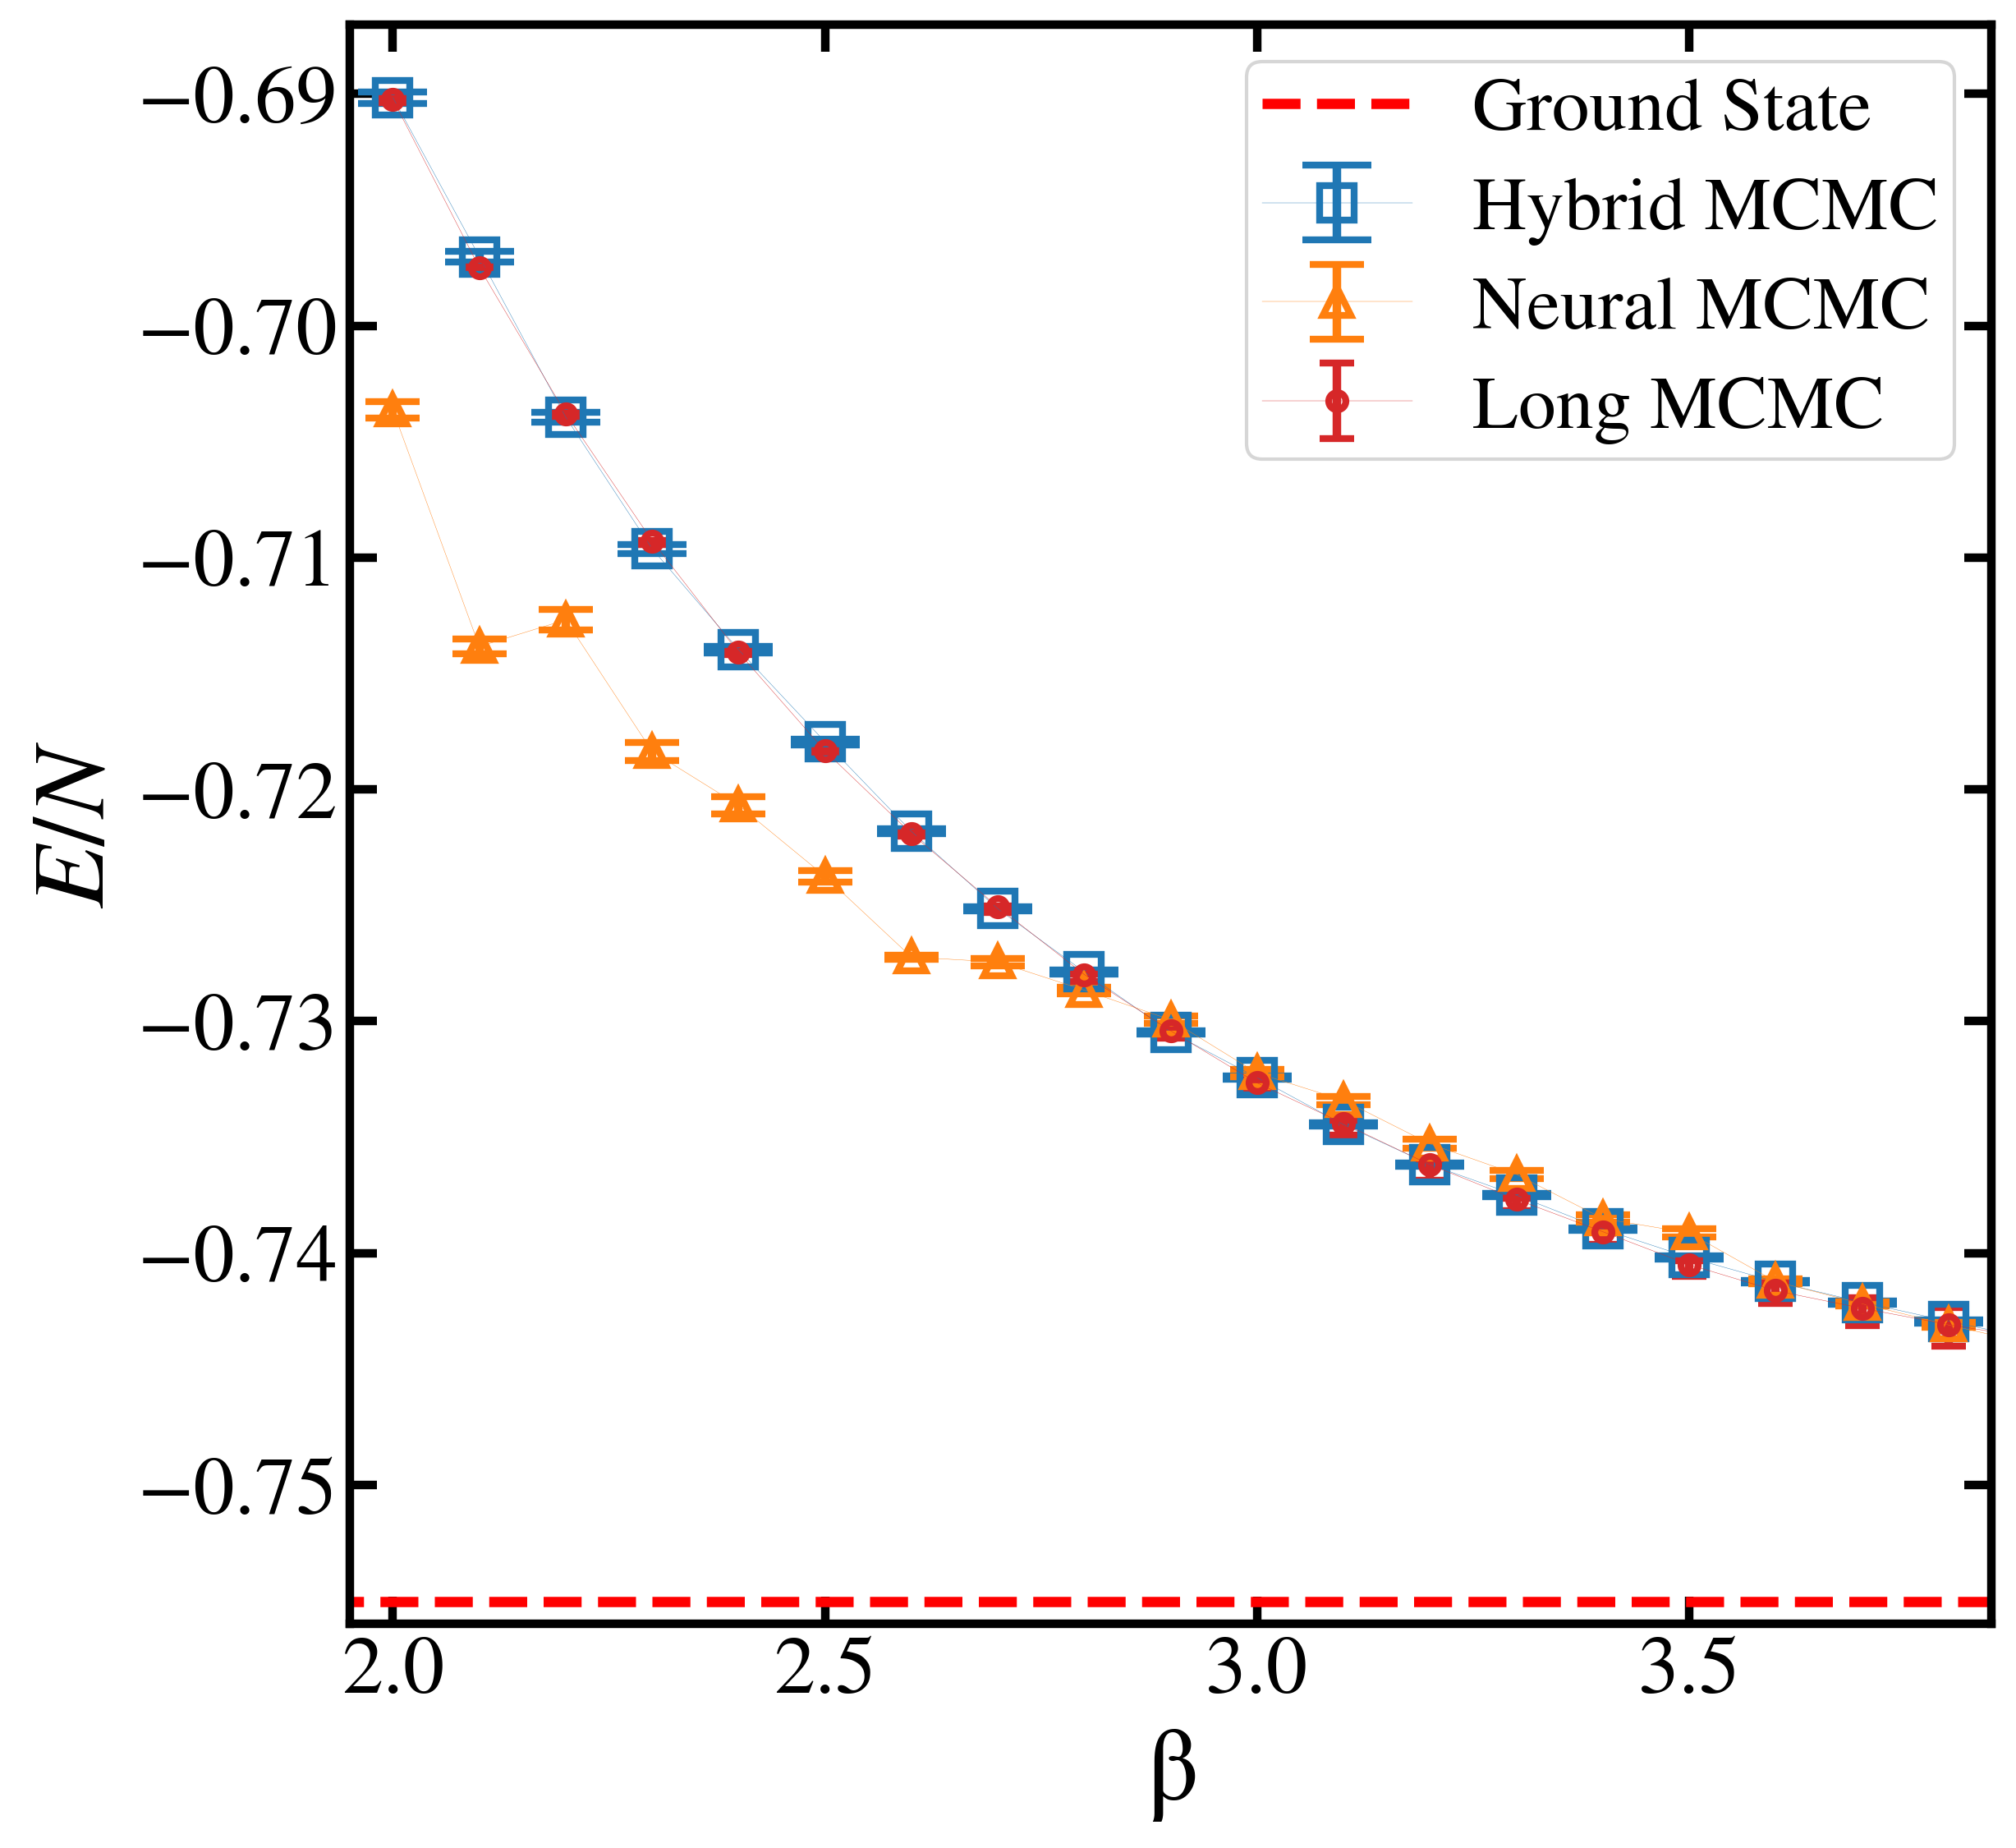

In [159]:
fig, ax = plt.subplots(figsize=(8.6, 8.6),  facecolor='white', dpi=300)

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 2.5

stringfont = 'serif'

ax.tick_params(axis='y', top=True, right=True, labeltop=False, labelright=False, width=2.5, length=8, direction='in', labelsize=24)
ax.tick_params(axis='x', top=True, right=True, labeltop=False, labelright=False, width=2.5, length=8, direction='in', labelsize=24)


plt.errorbar(betas, np.asarray(eng_seq_hybrid[10:])[...,skip_hybrid:].mean(1), yerr=block_std(eng_seq_hybrid[10:], hybrid_block_size, skip=skip_hybrid), elinewidth=2.5, linewidth=.1, marker='s', fillstyle='none', markersize=10, markeredgewidth=2, capsize=10, label=r"Hybrid MCMC")
plt.errorbar(betas, neural_eng_100mu.mean(1), yerr=block_std(neural_eng_100mu, neural_block_size, skip=skip_neural), elinewidth=2.5, linewidth=.1, marker='^', fillstyle='none', markersize=8, markeredgewidth=2, capsize=8, label=r"Neural MCMC")
plt.errorbar(betas, (single_all[..., skip_single:].mean(axis=2).mean(axis=0).tolist()), yerr=new_err, elinewidth=2.5, linewidth=.1, marker='o', color='tab:red', fillstyle='none', markersize=5, markeredgewidth=2, capsize=5, label=r"Long MCMC")



plt.hlines(ground_state, xmin=0.4, xmax=4.4, colors='red', linestyles='dashed', label="Ground State", linewidth=3)


#plt.xlim(2.45, 3.25)
plt.xlim(1.95, 3.85)
#plt.ylim(-0.740, -0.716)
plt.ylim(-0.756, -0.687)

plt.ylabel(r"$E/N$", fontsize=30, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"$\mathrm{\beta}$", fontsize=30, fontfamily=stringfont, fontweight='bold')

#plt.title(f"Skip {skip} Block Lenght {block_size}", fontsize=12, fontfamily=stringfont, fontweight='bold')


plt.legend(loc='best', fontsize=22, labelspacing=0.4, borderpad=0.2, fancybox=True)
#ax.set_title('fancy, transparent legends')

# axins2 = inset_axes(ax, width="30%", height="30%", loc=3, borderpad=4)
# axins2.tick_params(labelleft=False, labelbottom=False)
# axins2.errorbar(betas[8:16], np.asarray(eng_seq_hybrid[10:])[8:16,skip:].mean(1), yerr=block_std(eng_seq_hybrid[10:][8:16], hybrid_block_size, skip=skip), elinewidth=2.5, linewidth=.1, marker='s', fillstyle='none', markersize=15, markeredgewidth=2, capsize=8, label=r"Hybrid MCMC")
# axins2.errorbar(betas[8:16], (single_all[:,8:16, skip:].mean(axis=2).mean(axis=0).tolist()), yerr=single_all[:,8:16, skip:].mean(axis=2).std(axis=0) / np.sqrt(single_all.shape[0]-1), elinewidth=2.5, linewidth=.1, marker='.', color='tab:red', fillstyle='none', markersize=15, markeredgewidth=2, capsize=8, label=r"Long MCMC")


plt.savefig(
    "images/energy-beta_nn.png",
    edgecolor='white', 
    facecolor=fig.get_facecolor(), 
    bbox_inches='tight', 
    transparent=False
)
plt.savefig(
    "images/energy-beta_nn.eps",
    edgecolor="white",
    facecolor=fig.get_facecolor(),
    # transparent=True,
    bbox_inches="tight",
    format="eps",
)


## Neural-Hybrid MCMC

In [161]:
betas = np.linspace(2., 4, 21)
print(betas)
neural_eng_hybrid100mu = []
for beta in betas:
    _, eng, _ = neural_mcmc(beta, 1000000, datasets[4], couplings_path, model='made', disable_bar=True)
    neural_eng_hybrid100mu.append(eng/484)
neural_eng_hybrid100mu = np.asarray(neural_eng_hybrid100mu)

[2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7
 3.8 3.9 4. ]

Performing Neural MCMC at beta=2.0
Steps: 1000000 A_r=1.61%
E=-0.690394 ± 0.000013  [σ=0.012857  E_min=-0.736954]
Duration 0:00:22.888027

Performing Neural MCMC at beta=2.1
Steps: 1000000 A_r=1.15%
E=-0.698697 ± 0.000012  [σ=0.011919  E_min=-0.737119]
Duration 0:00:22.828929

Performing Neural MCMC at beta=2.2
Steps: 1000000 A_r=0.66%
E=-0.704856 ± 0.000010  [σ=0.009527  E_min=-0.738954]
Duration 0:00:22.669475

Performing Neural MCMC at beta=2.3
Steps: 1000000 A_r=0.50%
E=-0.709525 ± 0.000009  [σ=0.009452  E_min=-0.741254]
Duration 0:00:22.795585

Performing Neural MCMC at beta=2.4
Steps: 1000000 A_r=0.35%
E=-0.712650 ± 0.000009  [σ=0.008625  E_min=-0.741254]
Duration 0:00:22.827430

Performing Neural MCMC at beta=2.5
Steps: 1000000 A_r=0.22%
E=-0.716183 ± 0.000008  [σ=0.008121  E_min=-0.741254]
Duration 0:00:22.886125

Performing Neural MCMC at beta=2.6
Steps: 1000000 A_r=0.18%
E=-0.718411 ± 0.00

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


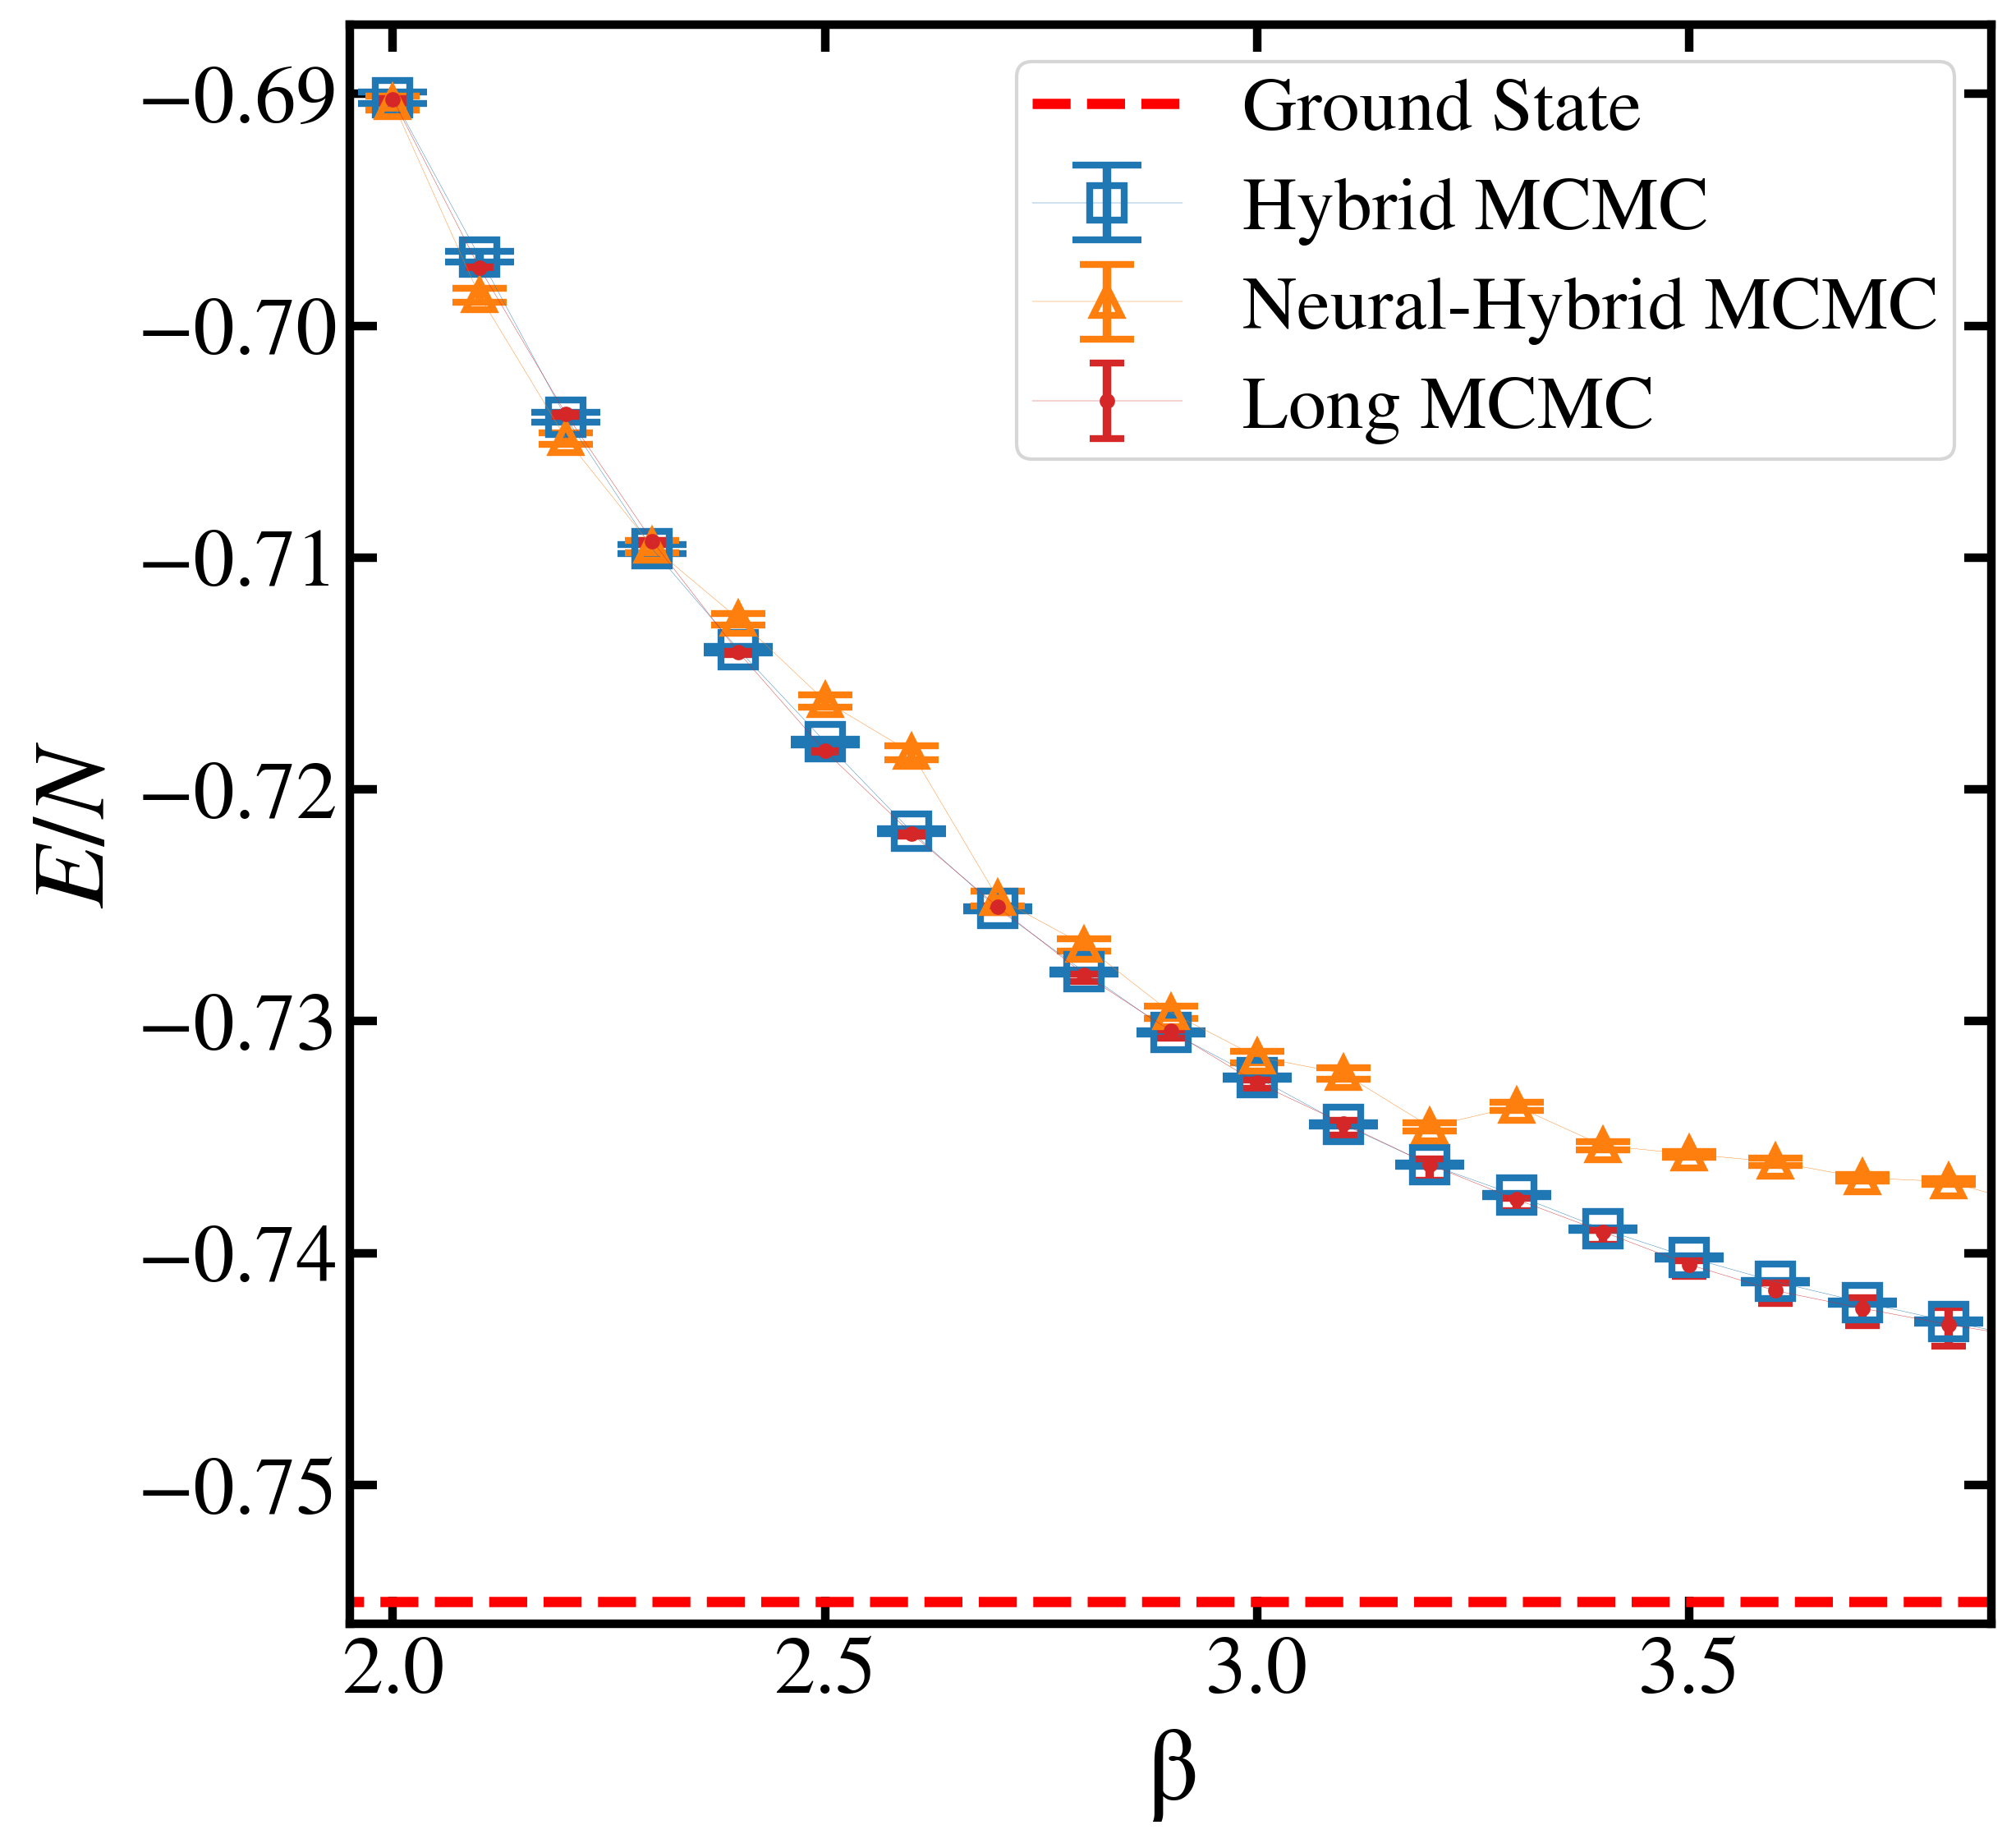

In [162]:
fig, ax = plt.subplots(figsize=(8.6, 8.6),  facecolor='white', dpi=300)

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 2.5

stringfont = 'serif'

ax.tick_params(axis='y', top=True, right=True, labeltop=False, labelright=False, width=2.5, length=8, direction='in', labelsize=24)
ax.tick_params(axis='x', top=True, right=True, labeltop=False, labelright=False, width=2.5, length=8, direction='in', labelsize=24)


plt.errorbar(betas, np.asarray(eng_seq_hybrid[10:])[...,skip_hybrid:].mean(1), yerr=block_std(eng_seq_hybrid[10:], hybrid_block_size, skip=skip_hybrid), elinewidth=2.5, linewidth=.1, marker='s', fillstyle='none', markersize=10, markeredgewidth=2, capsize=10, label=r"Hybrid MCMC")
plt.errorbar(betas, neural_eng_hybrid100mu.mean(1), yerr=block_std(neural_eng_hybrid100mu, neural_block_size, skip=skip_neural), elinewidth=2.5, linewidth=.1, marker='^', fillstyle='none', markersize=8, markeredgewidth=2, capsize=8, label=r"Neural-Hybrid MCMC")
plt.errorbar(betas, (single_all[..., skip_single:].mean(axis=2).mean(axis=0).tolist()), yerr=new_err, elinewidth=2.5, linewidth=.1, marker='.', color='tab:red', fillstyle='none', markersize=5, markeredgewidth=2, capsize=5, label=r"Long MCMC")



plt.hlines(ground_state, xmin=0.4, xmax=4.4, colors='red', linestyles='dashed', label="Ground State", linewidth=3)


#plt.xlim(2.45, 3.25)
plt.xlim(1.95, 3.85)
#plt.ylim(-0.740, -0.716)
plt.ylim(-0.756, -0.687)

plt.ylabel(r"$E/N$", fontsize=30, fontfamily=stringfont, fontweight='bold')
plt.xlabel(r"$\mathrm{\beta}$", fontsize=30, fontfamily=stringfont, fontweight='bold')

#plt.title(f"Skip {skip} Block Lenght {block_size}", fontsize=12, fontfamily=stringfont, fontweight='bold')


plt.legend(loc='best', fontsize=22, labelspacing=0.4, borderpad=0.2, fancybox=True)
#ax.set_title('fancy, transparent legends')

# axins2 = inset_axes(ax, width="30%", height="30%", loc=3, borderpad=4)
# axins2.tick_params(labelleft=False, labelbottom=False)
# axins2.errorbar(betas[8:16], np.asarray(eng_seq_hybrid[10:])[8:16,skip:].mean(1), yerr=block_std(eng_seq_hybrid[10:][8:16], hybrid_block_size, skip=skip), elinewidth=2.5, linewidth=.1, marker='s', fillstyle='none', markersize=15, markeredgewidth=2, capsize=8, label=r"Hybrid MCMC")
# axins2.errorbar(betas[8:16], (single_all[:,8:16, skip:].mean(axis=2).mean(axis=0).tolist()), yerr=single_all[:,8:16, skip:].mean(axis=2).std(axis=0) / np.sqrt(single_all.shape[0]-1), elinewidth=2.5, linewidth=.1, marker='.', color='tab:red', fillstyle='none', markersize=15, markeredgewidth=2, capsize=8, label=r"Long MCMC")


plt.savefig(
    "images/energy-beta_nh.png",
    edgecolor='white', 
    facecolor=fig.get_facecolor(), 
    bbox_inches='tight', 
    transparent=False
)
plt.savefig(
    "images/energy-beta_nh.eps",
    edgecolor="white",
    facecolor=fig.get_facecolor(),
    # transparent=True,
    bbox_inches="tight",
    format="eps",
)


## How D-Wave works

In the following we describe briefly how the Dwave system works. In particular, we focuse on the choice of the *chains*' strenghts, where the *chains* are the coupled qubits in the quantum annealer that represent a single varible in the original problem. Usually, the DWave sistem's topology doesn't fit exactly the original problem topology, so we need to embed our problem using a heuristic algorithm, generating this kind of *chains*.


In [166]:
dwave_path = "data"
rnds = ["uniform", "gaussian", "binary"]
strenghts = np.linspace(0.5, 4, 15)

# uniform-couplings properties
uniform_ground_state = -0.7550297905
uniform_dwave_default = 1.5828847157168355
# gaussian-couplings properties
gaussian_ground_state = -1.2769078779999998 
gaussian_dwave_default = 2.7174204926999237
# binary-couplings properties
binary_ground_state = -1.3636342975206612
binary_dwave_default =  2.7629798143572195

In [79]:
engs = {"uniform": [], "gaussian": [], "binary": [],}
for rnd in rnds:
    for strenght in strenghts:
        try:
            eng = np.load(f"{dwave_path}/sweep_chains_{rnd}/dwave-engs_{strenght}.npy")
        except:
            pass
        engs[rnd].append(eng)
    engs[rnd] = np.asarray(engs[rnd])

In [110]:
def plt_eng_chains(engs: List[np.ndarray], ground_state: int, dwave_default: Optional[float] = None, xlim: Tuple[float, float] = (0.4, 4.1), title: Optional[str] = None, save: bool = False):
    fig, ax = plt.subplots(figsize=(8.6, 8.6), dpi=300, facecolor="white")

    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["axes.linewidth"] = 2.5

    stringfont = "serif"

    ax.tick_params(
        axis="y",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=2.5,
        length=10,
        direction="in",
        labelsize=24,
    )
    ax.tick_params(
        axis="x",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=2.5,
        length=10,
        direction="in",
        labelsize=24,
    )

    plt.plot(strenghts, engs.min(1) / 484, "-s", label=r"Minimum")
    plt.errorbar(strenghts, engs.mean(1) / 484, engs.std(1) / 484, capsize=5., elinewidth=2.5, linewidth=.1, marker='s', color='tab:orange', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Mean")

    plt.hlines(ground_state, xmin=xlim[0]-.4, xmax=xlim[1]+.4, colors='red', linestyles='dashed', label="Ground State", linewidth=3)

    if dwave_default is not None and title is not None:
        plt.plot(dwave_default, np.load(f"data/sweep_chains_{title.lower()}/dwave-engs_0.npy").min() / 484, "d", color='tab:green', label=f"D-Wave default")
        plt.errorbar(dwave_default, np.load(f"data/sweep_chains_{title.lower()}/dwave-engs_0.npy").mean() / 484, np.load(f"data/sweep_chains_{title.lower()}/dwave-engs_0.npy").std() / 484, capsize=5., elinewidth=1.5, linewidth=.1, marker='d', color='tab:green', fillstyle='none', markersize=8, markeredgewidth=2, label=f"D-Wave default")


    plt.xlim(xlim)

    plt.ylabel(r"$\mathrm{E}$", fontsize=30, fontfamily=stringfont, fontweight='bold')
    plt.xlabel(r"chains_strength",  fontsize=24, fontfamily=stringfont, fontweight='ultralight')

    # plt.title(rf"$L=22$ {title} 1 NN",  fontsize=20, fontfamily=stringfont)

    plt.legend(loc='best', fontsize=22, labelspacing=0.4, borderpad=0.2, fancybox=True)
    if save:
        plt.savefig("images/strenght-energy_1nn-binary.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')

        plt.savefig(
            "images/strenght-energy_1nn-binary.eps",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            # transparent=True,
            bbox_inches="tight",
            format="eps",
        )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


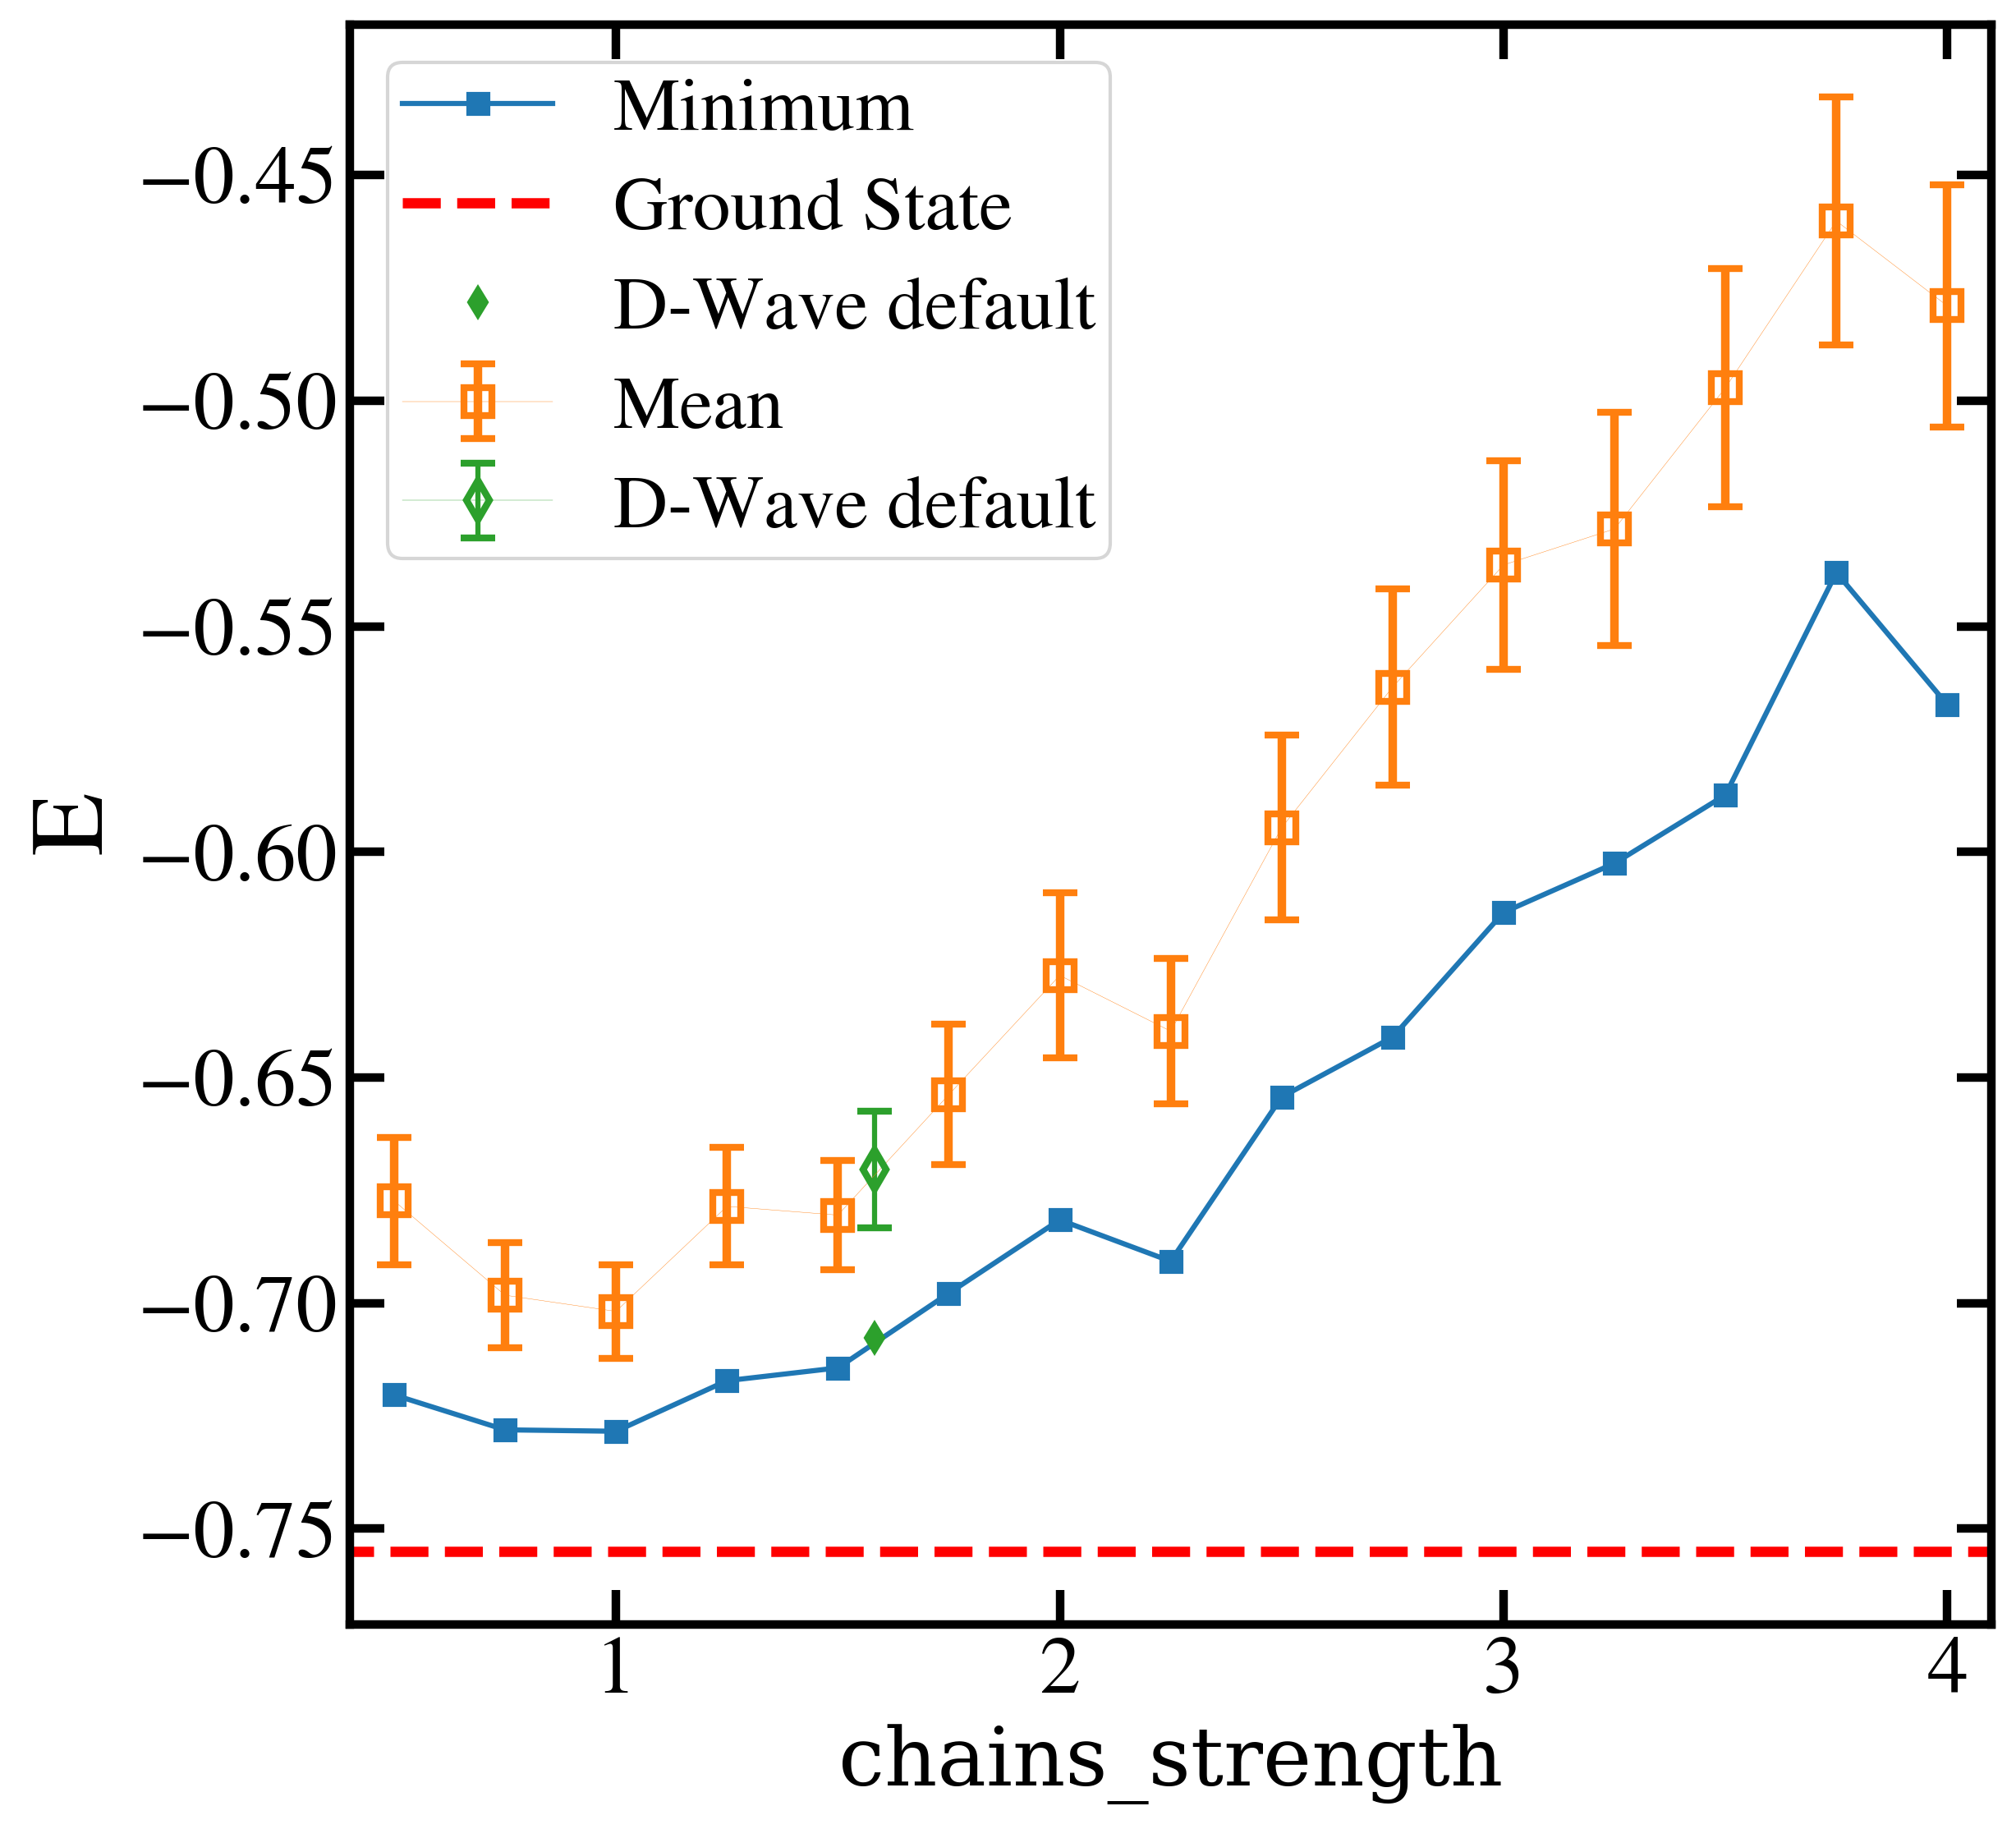

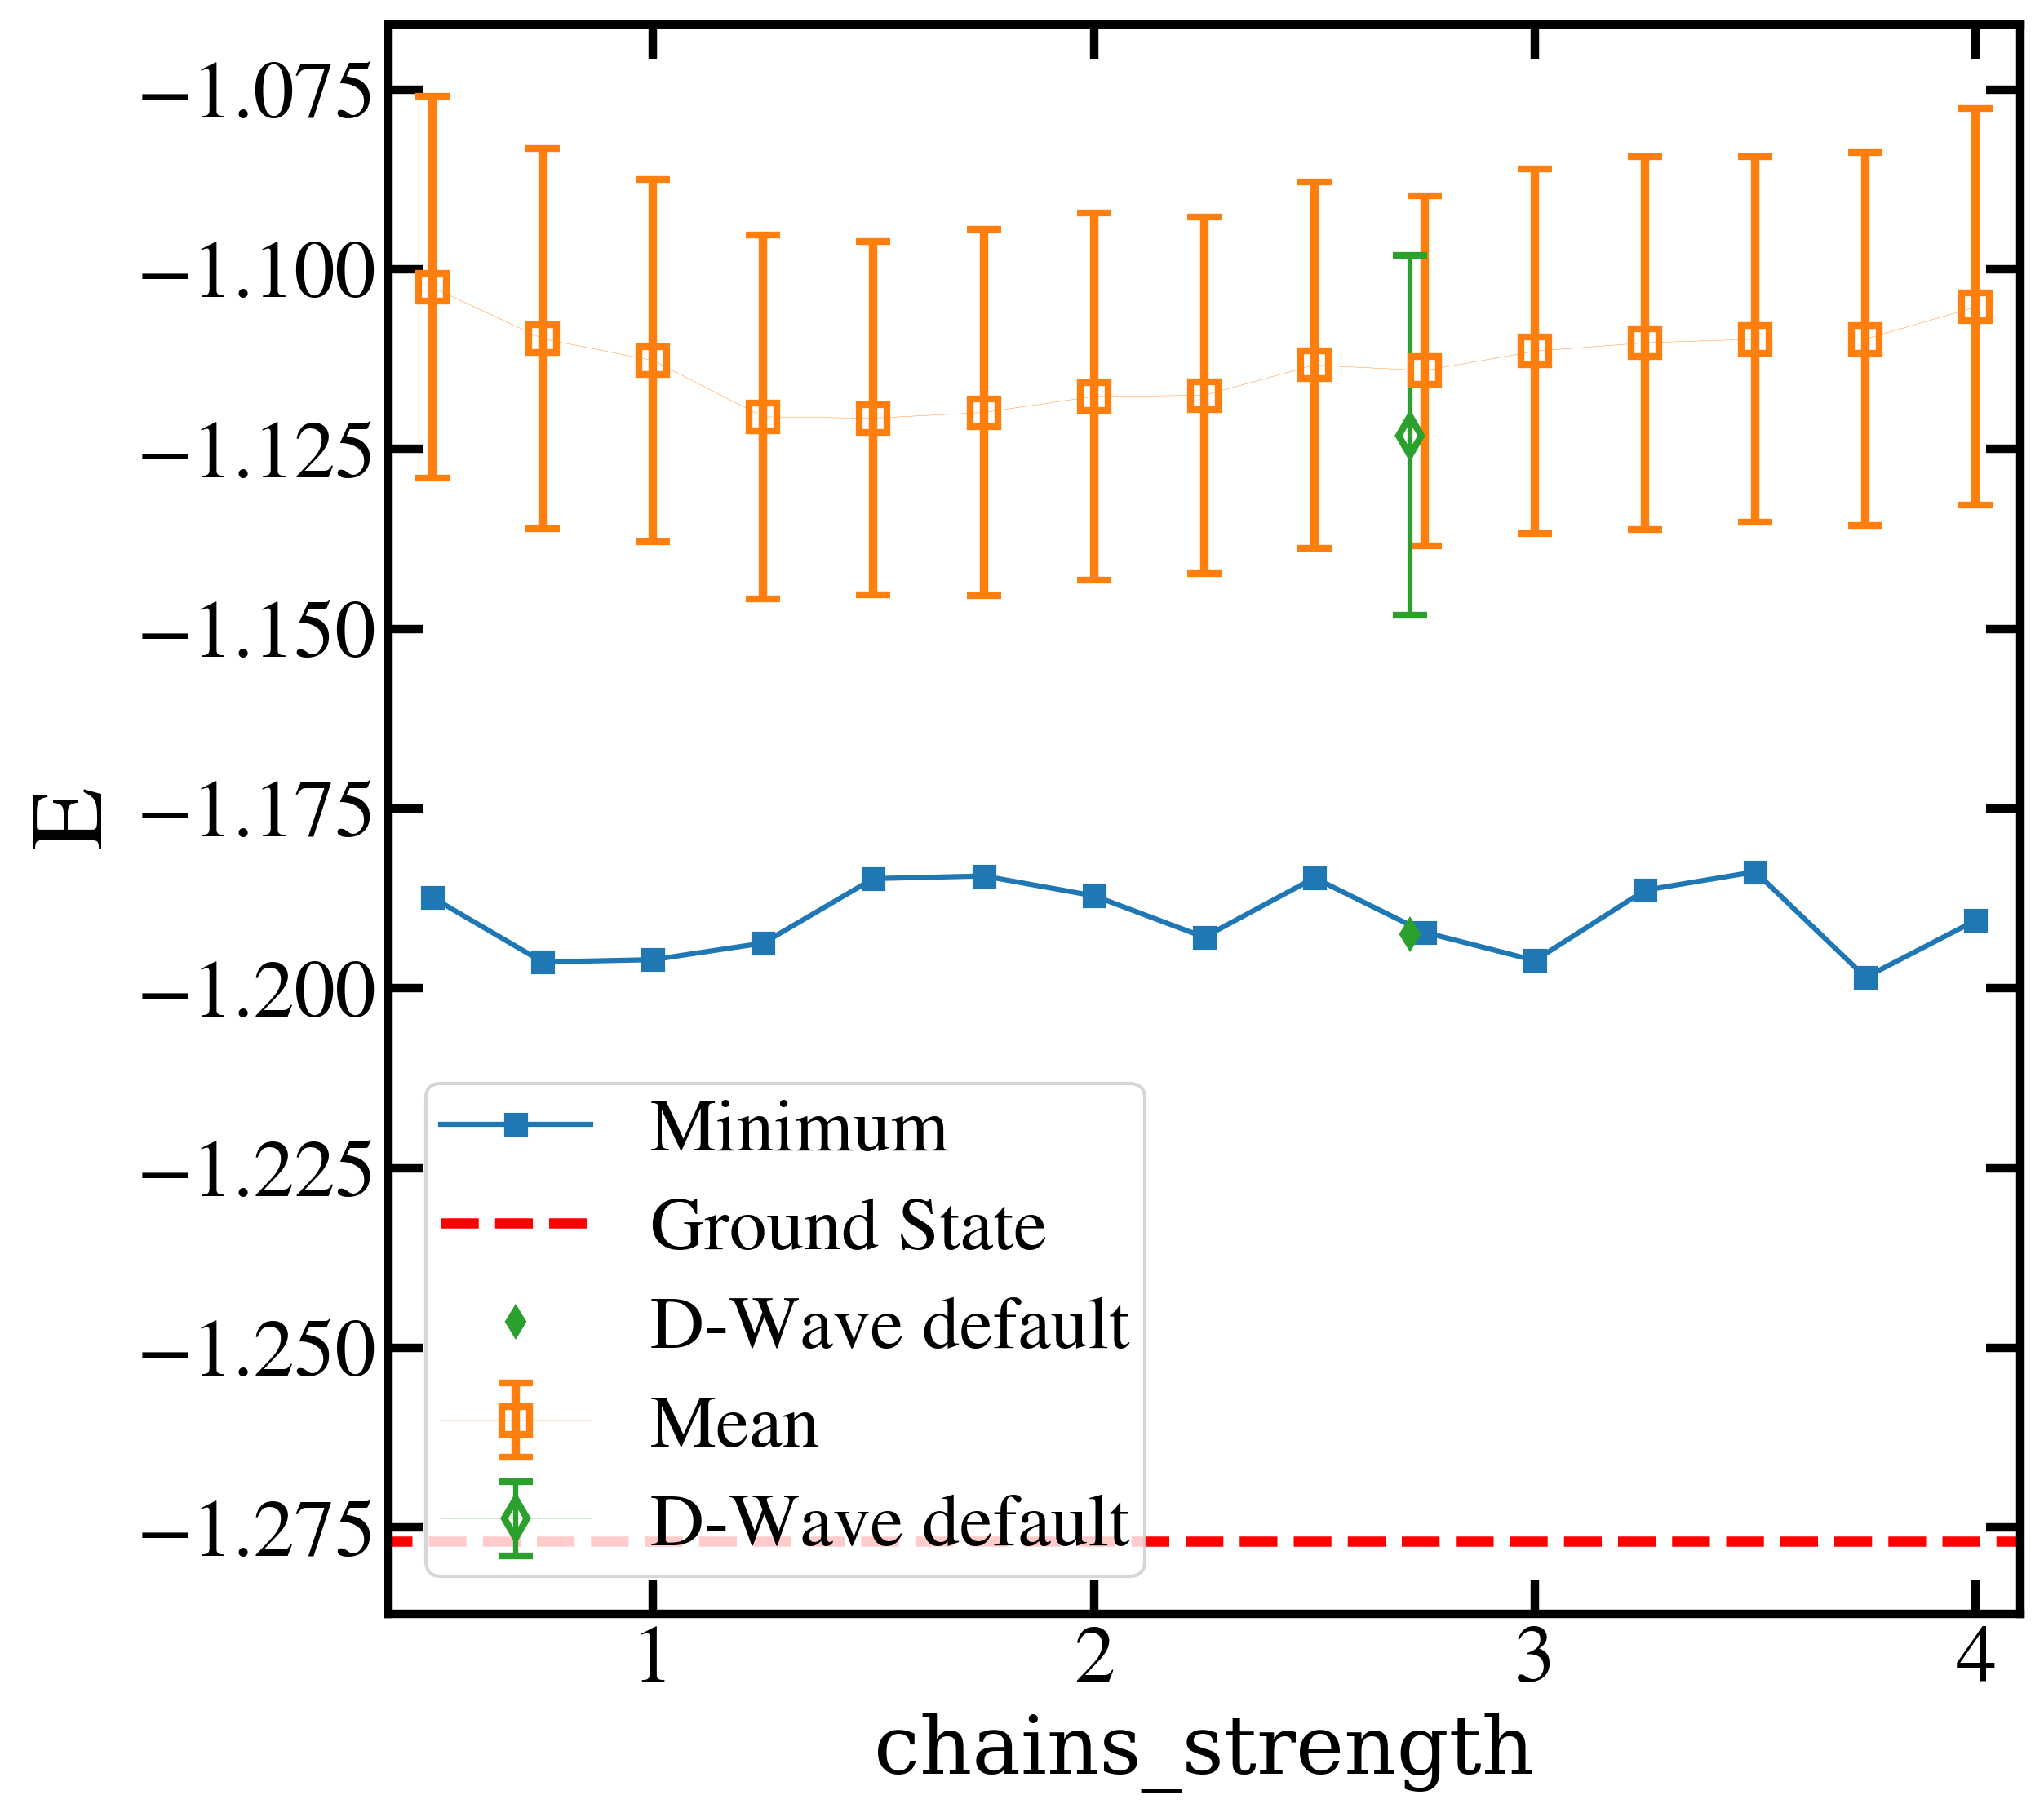

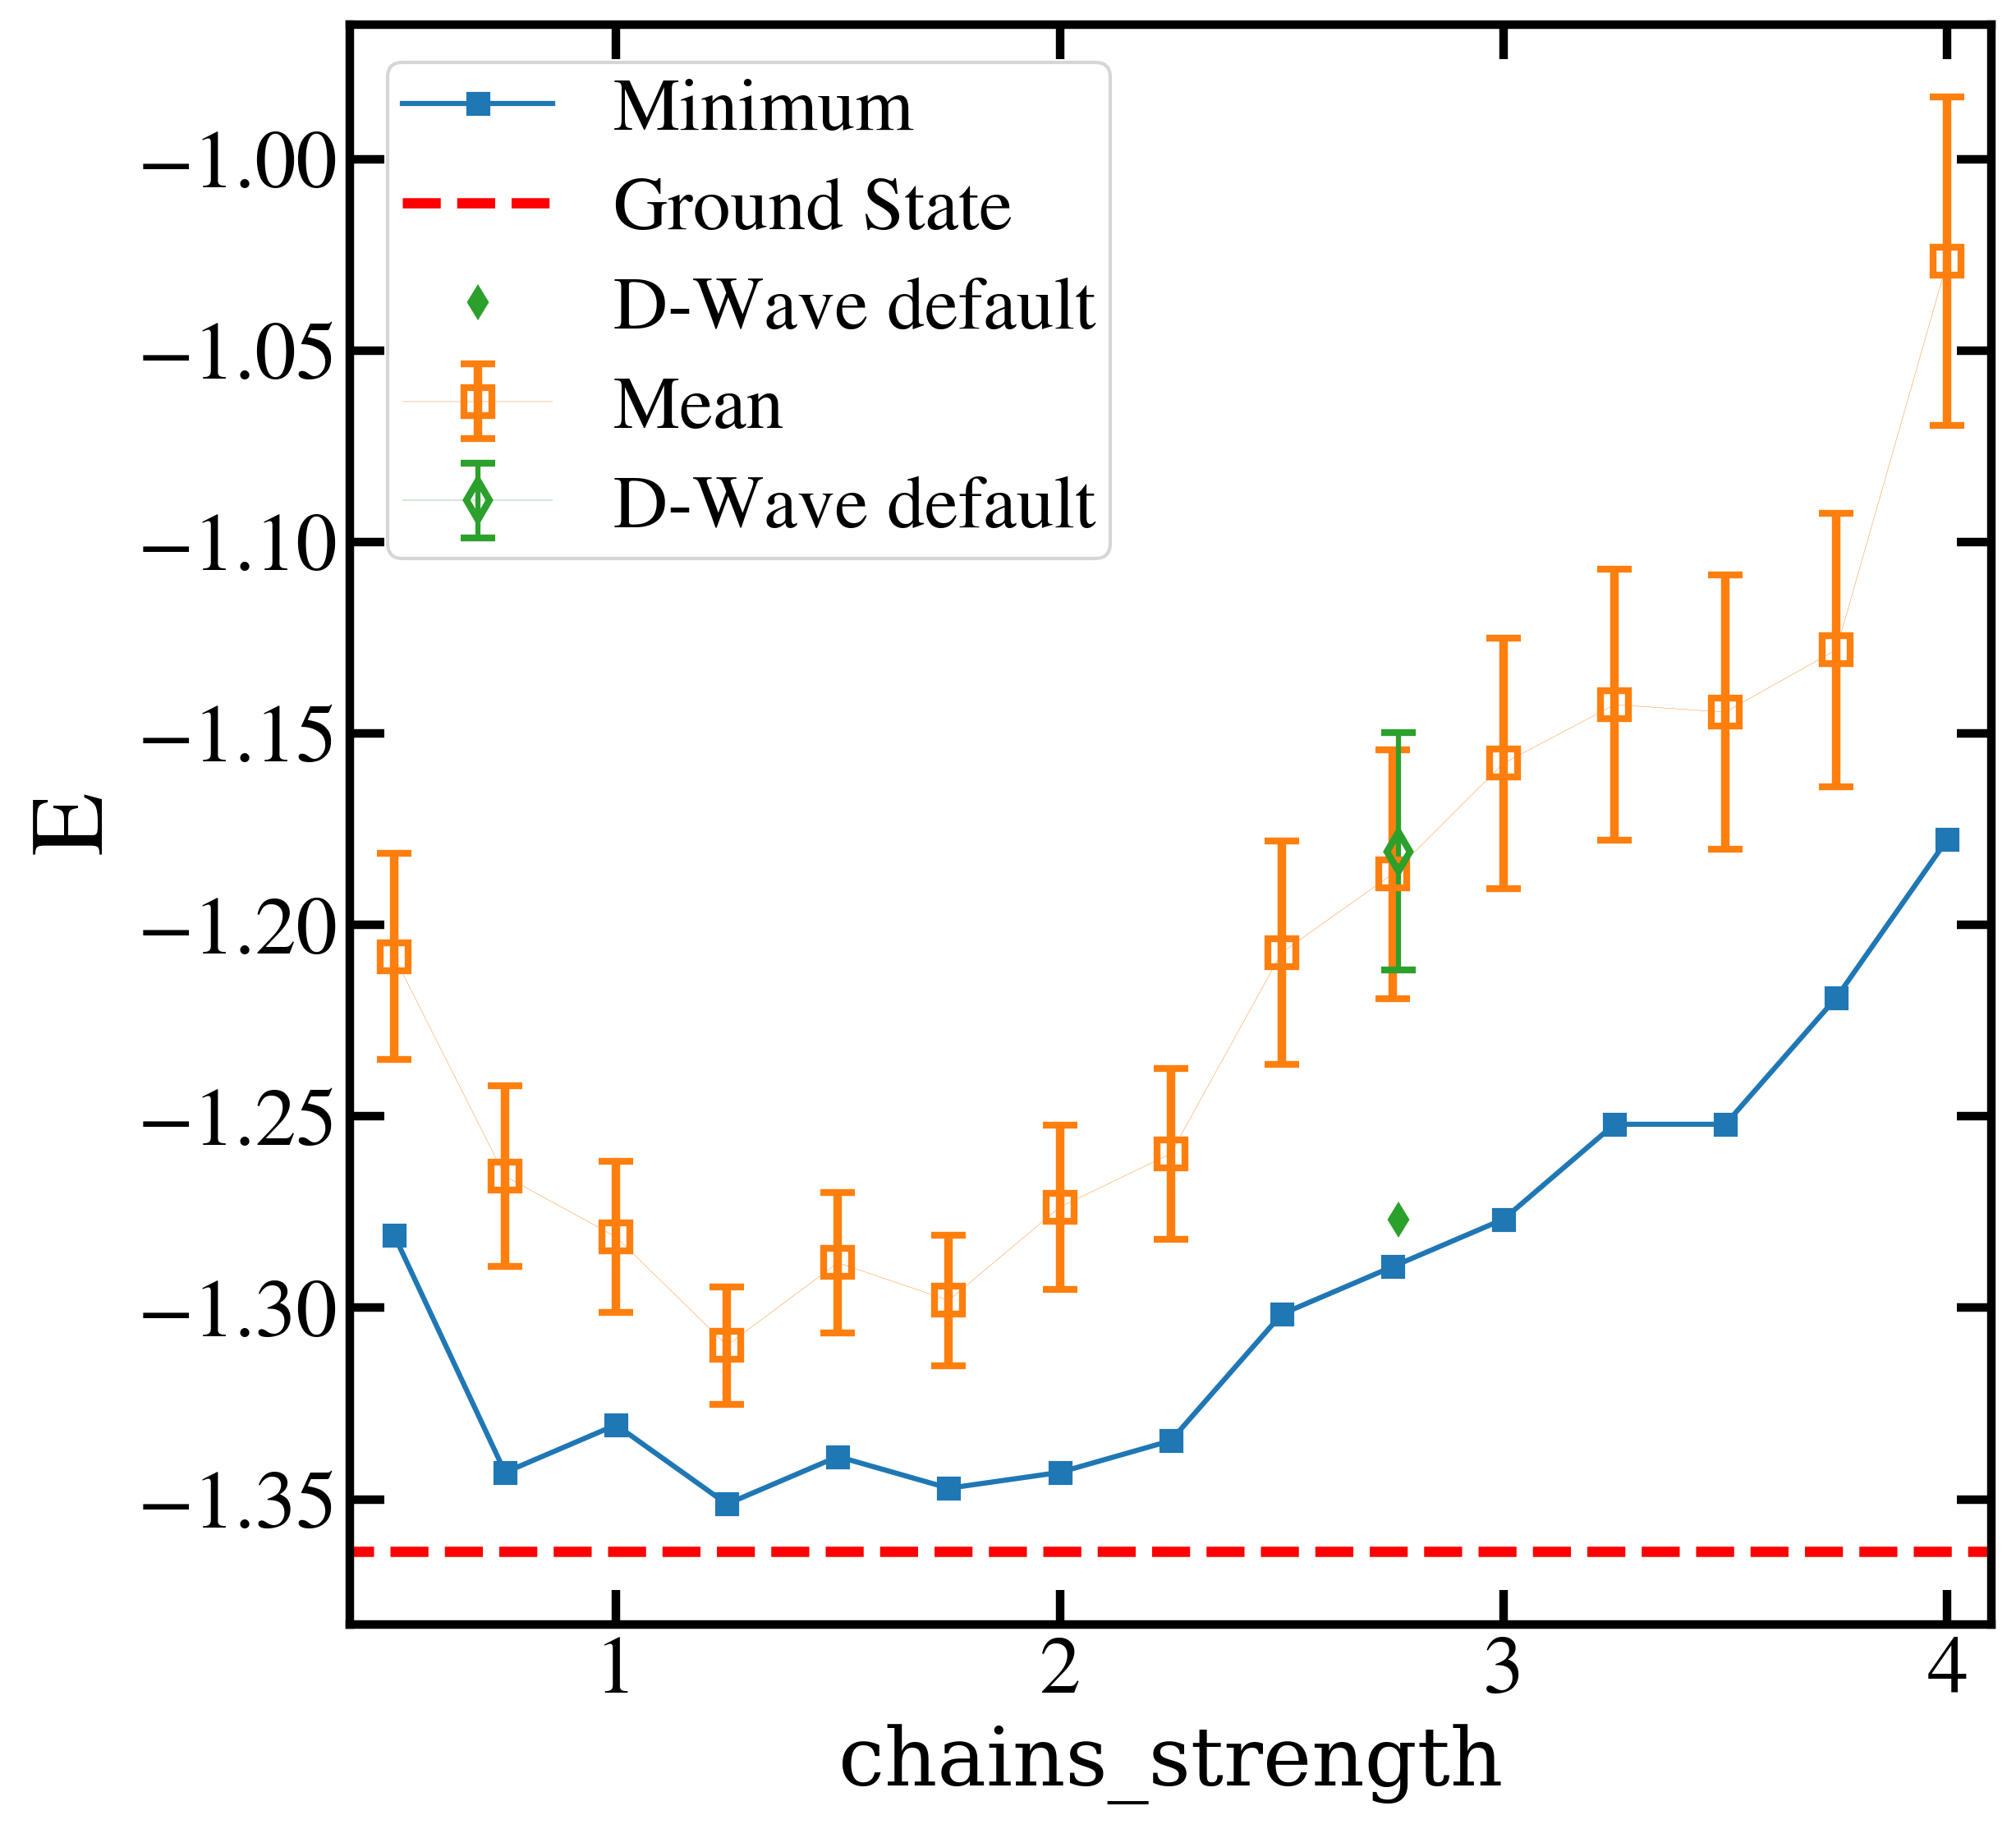

In [111]:
ground_states = [uniform_ground_state, gaussian_ground_state, binary_ground_state]
dwave_defaults = [uniform_dwave_default, gaussian_dwave_default, binary_dwave_default]
titles = ["Uniform", "Gaussian", "Binary"]

for i, rnd in enumerate(rnds):
    plt_eng_chains(engs[rnd], ground_state=ground_states[i], dwave_default=dwave_defaults[i], title=titles[i], save=True)


## Annealing Time

Moreover, the annealing time is one of the most imprtant parameter to take in account. In particular low annealing time leads to a noisy solution with many high energy samples. In the following we compare sample obtain with different annealing time or different chains' stringht. Then we show how one can connect the annealing time with an effective $\beta$ in a themodinamic of the lattice. 


1 $\mu$s
E: -0.7021283618736106 ± 2.090670165483138e-05
min: -0.7433134379818167 (1 occurance(s))                                                                    (s))

10 $\mu$s
E: -0.7211725082190017 ± 1.4668936649154495e-05
min: -0.7511945731648754 (1 occurance(s))                                                                    (s))

100 $\mu$s eng
E: -0.7320812975269184 ± 1.1506537873615045e-05
min: -0.7534729061392554  (1 occurance(s))


([array([-0.70830739, -0.6951263 , -0.71060946, ..., -0.69133916,
         -0.70574294, -0.70626363]),
  array([-0.73030854, -0.72450425, -0.71285243, ..., -0.71219005,
         -0.72098385, -0.72732055])],
 array([-0.72767341, -0.72506022, -0.730454  , ..., -0.74020771,
        -0.7345168 , -0.72879414]))

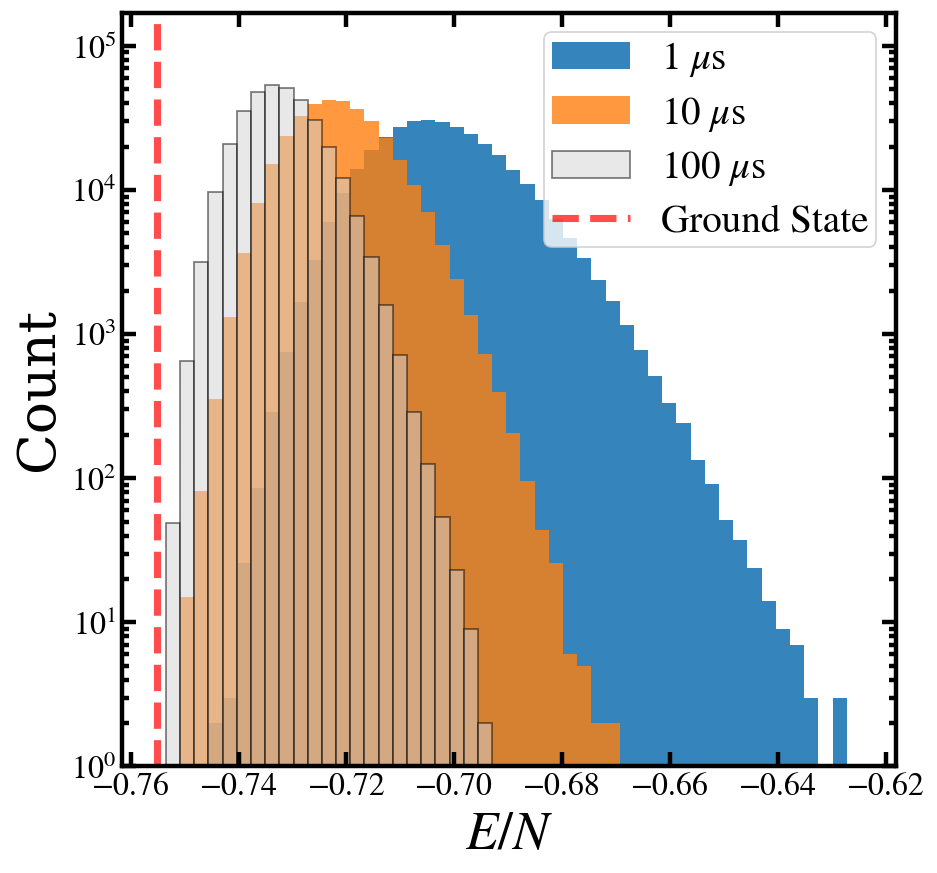

In [170]:
dwave_datasets = [
    "data/datasets/484-1nn-uniform-1mus/train-484spins-1nn-uniform-1mus.npy",
    "data/datasets/484-1nn-uniform-10mus/train-484spins-1nn-uniform-10mus.npy",
    "data/datasets/484-1nn-uniform-100mus/train-484spins-1nn-uniform-100mus.npy"]

plot_hist(dwave_datasets[:2], couplings_path, dwave_datasets[2], ground_state=uniform_ground_state, labels=[r"1 $\mu$s", r"10 $\mu$s", r"100 $\mu$s"], save=True)

## Dataset a secondi vicini 3NN


In [2]:
datasets = [
        "data/generated/sample-500000_size-484_2022-03-01_11-09-49.npz", # 1mus 1nn
        "data/generated/sample-1000000_size-484_2022-03-01_11-48-11.npz", # 10mus 1nn
        "data/generated/sample-1000000_size-484_2022-03-01_11-50-00.npz", # 100mus 1nn
        #"data/generated/sample-1000000_size-484_2022-05-10_23-59-33.npz", # 1-10-100mus 1nn
        #"data/generated/sample-1000000_size-484_2022-02-10_15-28-37.npz", # 1<beta<2.5 1nn
        #"data/generated/sample-1000000_size-484_2022-02-10_17-00-33.npz" # 100mus and 1<beta<2.5 1nn
        ]

labels = [r"1 $\mu$s",r"10 $\mu$s", r"100 $\mu$s"]

betas = np.linspace(0.5,8, num=31)
print(betas)
couplings_path = "data/couplings/484spins-uniform-3nn.txt"
ground_state = -1.0982 

[0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75
 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25 6.5  6.75 7.   7.25
 7.5  7.75 8.  ]


In [ ]:
acc_rates = []
for i, dataset in enumerate(datasets):
    acc_rate = []
    for beta in betas:
        _, eng_neural, ar = neural_mcmc(beta, 50000, dataset, couplings_path, "made", disable_bar=True)
        acc_rate.append(ar)
    acc_rates.append(acc_rate)

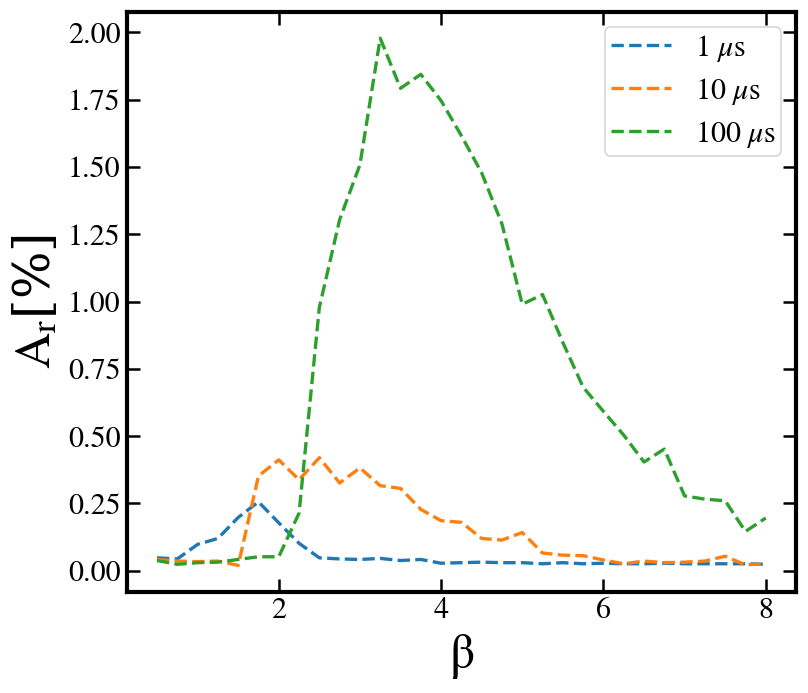

In [25]:
# remove the labels of the dataset  
# that we didn't use
labels_ar = []
for i, label in enumerate(labels): 
    labels_ar.append(label)

plt_betas_ar(acc_rates, labels_ar, betas)

In [3]:
from scipy.optimize import curve_fit


def plt_acf(
    acs1: Union[np.ndarray, List[np.ndarray]],
    label1: Union[str, List[str]],
    acs2: Optional[np.ndarray] = None,
    label2: Optional[str] = None,
    xlim: Tuple[int, int] = (1, 1000000),
    ylim: Tuple[int, int] = (0.01, 1),
    title: Optional[str] = None,
    fit: bool = False,
    log_scale: bool = True,
    save: bool = False,
):
    fig, ax = plt.subplots(figsize=(7.2, 6.4), dpi=120)

    def stretch_exp(t, a, tau, alpha):
        return a * np.exp(-((t / tau) ** alpha))

    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["axes.linewidth"] = 2.5

    stringfont = "serif"

    ax.tick_params(
        axis="y",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=1.5,
        length=8,
        direction="in",
        labelsize=18,
    )
    ax.tick_params(
        axis="x",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=1.5,
        length=8,
        direction="in",
        labelsize=18,
    )
    ax.tick_params(
        which="minor",
        top=True,
        right=False,
        labeltop=False,
        labelright=False,
        width=1.5,
        length=5,
        direction="in",
        labelsize=18,
    )

    plt.rcParams["axes.linewidth"] = 1.5

    if isinstance(acs1, list):
        assert len(acs1) == len(label1)

        for i, acs in enumerate(acs1):
            color = next(ax._get_lines.prop_cycler)["color"]
            plt.plot(acs, label=label1[i], linewidth=2.5, color=color)
            ax.set_yscale("log")
            if fit:
                p, _ = curve_fit(
                    stretch_exp,
                    np.arange(xlim[1]),
                    acs[: xlim[1]],
                    bounds=([-np.inf, 0, 0], [np.inf, np.inf, np.inf]),
                )
                print(f"{label1[i]} a={p[0]} tau*={p[1]} alpha={p[2]}")
                plt.plot(
                    stretch_exp(np.arange(xlim[1]), p[0], p[1], p[2]),
                    "--",
                    color=color,
                )
    else:
        plt.plot(acs1.mean(0), label=label1, linewidth=1.5)
        plt.fill_between(
            np.arange(acs1.shape[1]),
            acs1.mean(0) + acs1.std(0),
            acs1.mean(0) - acs1.std(0),
            alpha=0.1,
            color="b",
        )

    if acs2 is not None:
        plt.plot(acs2, "--", label=label2, linewidth=2.0)

    if log_scale:
        ax.set_xscale("log")

    plt.ylabel(
        r"$\mathrm{c(\tau)}$", fontsize=30, fontfamily=stringfont, fontweight="bold"
    )
    plt.xlabel(
        r"$\mathrm{\tau}$", fontsize=30, fontfamily=stringfont, fontweight="bold"
    )

    plt.ylim(ylim)
    plt.xlim(xlim)

    plt.title(title, fontsize=18, fontfamily=stringfont)

    plt.legend(loc="best", fontsize=18, labelspacing=0.4, borderpad=0.2, fancybox=True)
    plt.show()

    if save:
        plt.savefig(
            "images/correlation.png",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            bbox_inches="tight",
            transparent=False,
        )


In [11]:
seq_hybrid_3nn = [
              "data/hybrid/3nn_100mus_betas10-50/484spins_beta1.0_500000hybrid-mcmc_single_len484.npz",
              "data/hybrid/3nn_100mus_betas10-50/484spins_beta1.5_500000hybrid-mcmc_single_len484.npz", 
              "data/hybrid/3nn_100mus_betas10-50/484spins_beta2.0_500000hybrid-mcmc_single_len484.npz",
              "data/hybrid/3nn_100mus_betas10-50/484spins_beta2.5_500000hybrid-mcmc_single_len484.npz",
              "data/hybrid/3nn_100mus_betas10-50/484spins_beta3.0_500000hybrid-mcmc_single_len484.npz",
              "data/hybrid/3nn_100mus_betas10-50/484spins_beta3.5_500000hybrid-mcmc_single_len484.npz",
              "data/hybrid/3nn_100mus_betas10-50/484spins_beta4.0_500000hybrid-mcmc_single_len484.npz",
              #"data/hybrid/3nn_100mus_betas10-50/484spins_beta4.5_500000hybrid-mcmc_single_len484.npz",
              #"data/hybrid/3nn_100mus_betas10-50/484spins_beta5.0_500000hybrid-mcmc_single_len484.npz",
              ]

eng_seq_hybrid_3nn = [np.load(eng)['energy'] / 484 for eng in seq_hybrid_3nn] 

In [5]:
paths = []
for beta in [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]:
    #for seed in seeds:
    if beta == 3.0 or beta == 3.5 or beta == 4.0:
        paths.append(f"3nn-forpaper/484spins-seed12345-sample20000000-sweeps1-beta{str(beta)}.npy")
    else:
        paths.append(f"3nn-forpaper/484spins-seed12345-sample11000000-sweeps1-beta{str(beta)}.npy")
single_engs = get_energy(22, paths, couplings_path)

In [14]:
skip=0

ac_betas = []
for single_eng in single_engs:
    ac_betas.append(acf(single_eng[skip:], nlags=100000, fft=True))

(500000,)


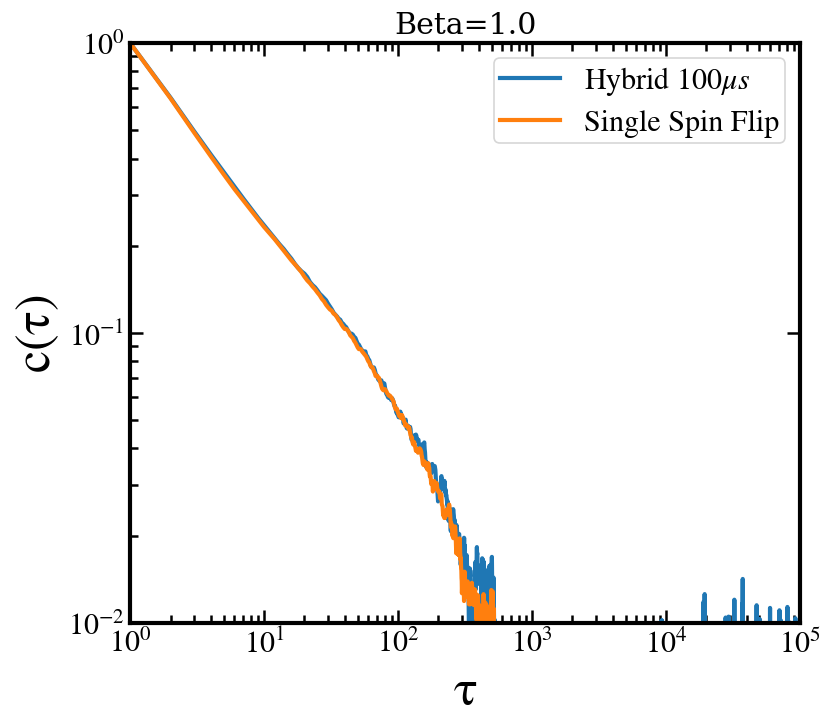

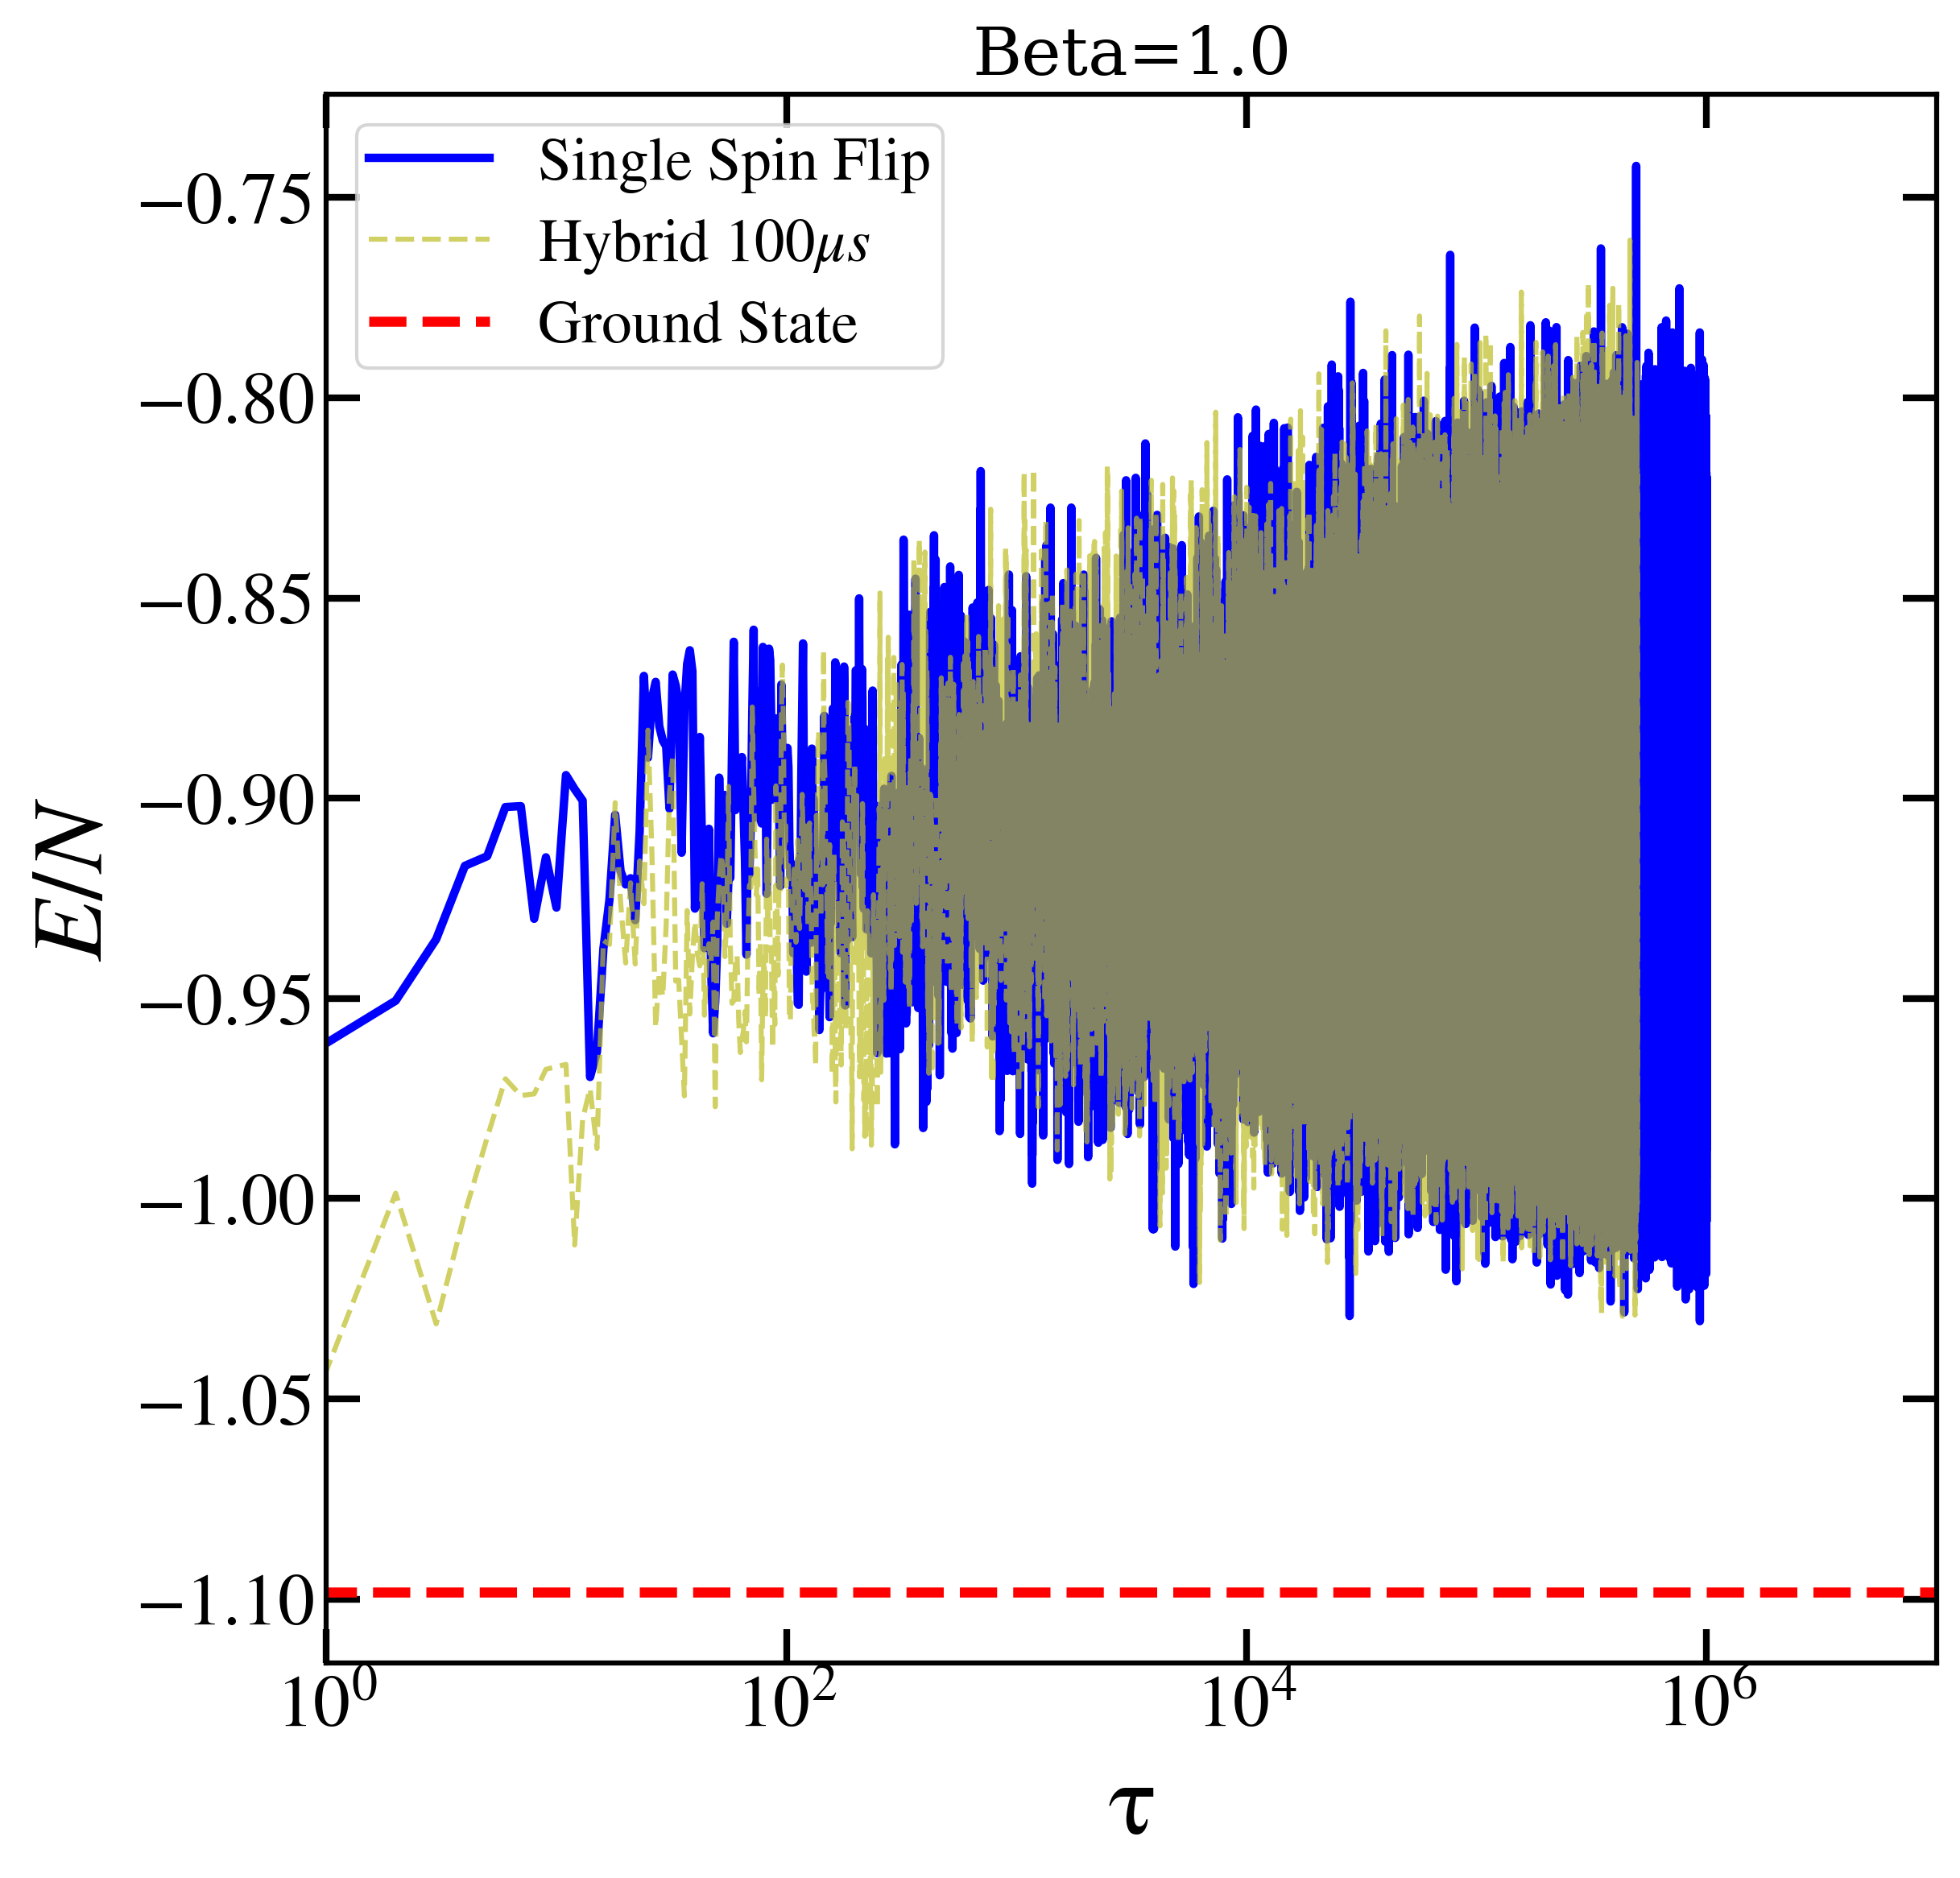

(500000,)


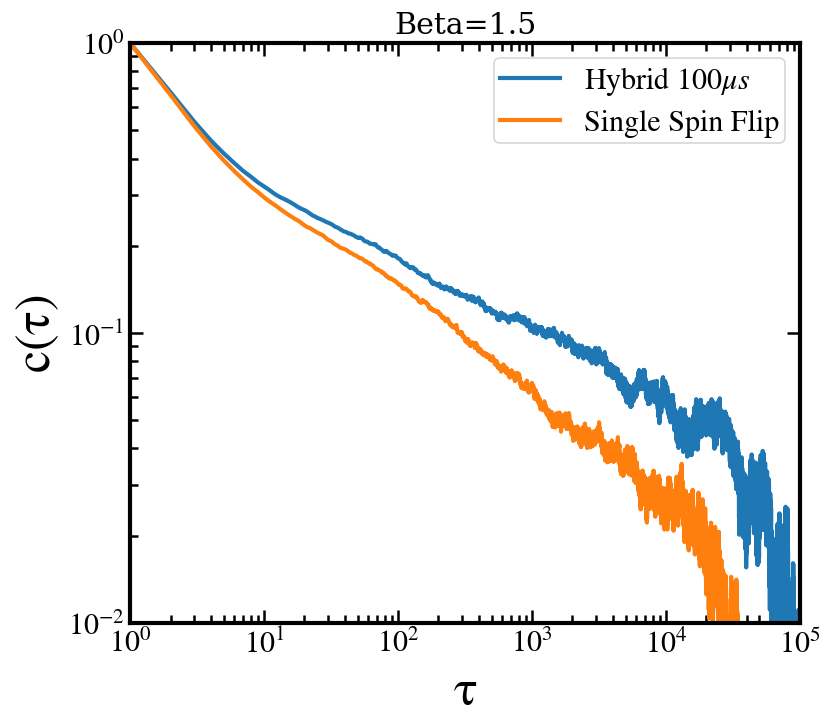

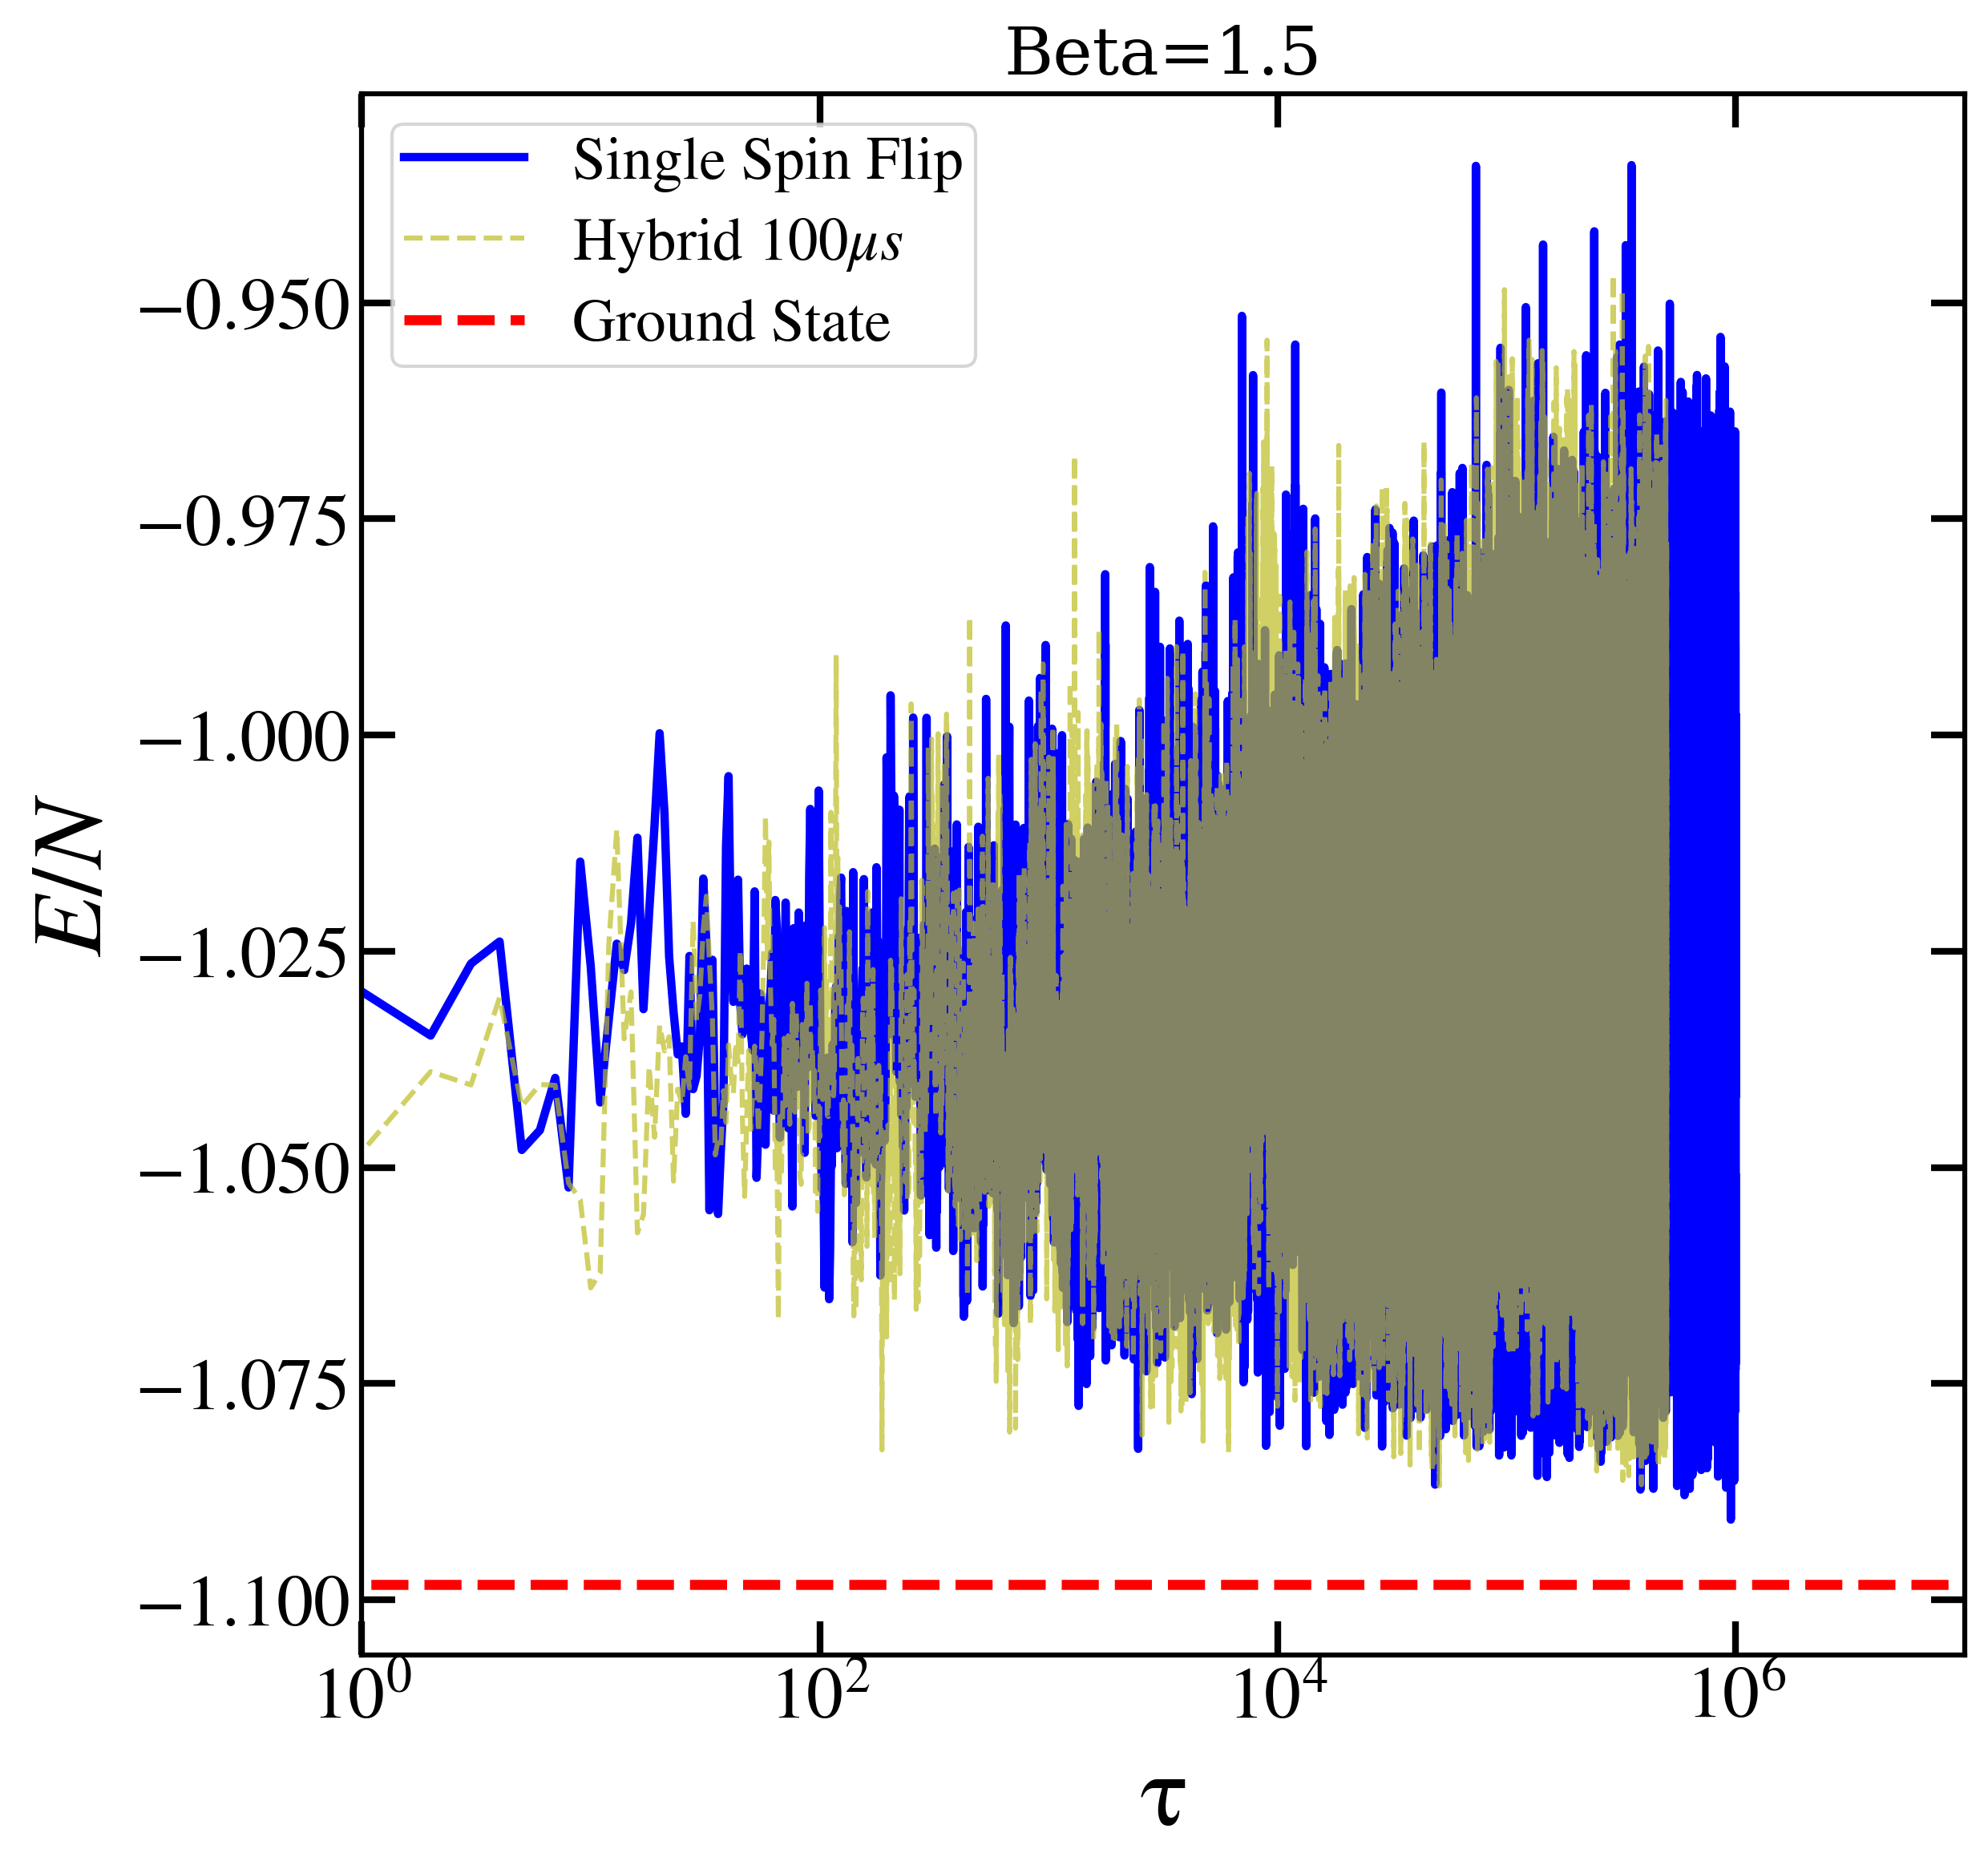

(500000,)


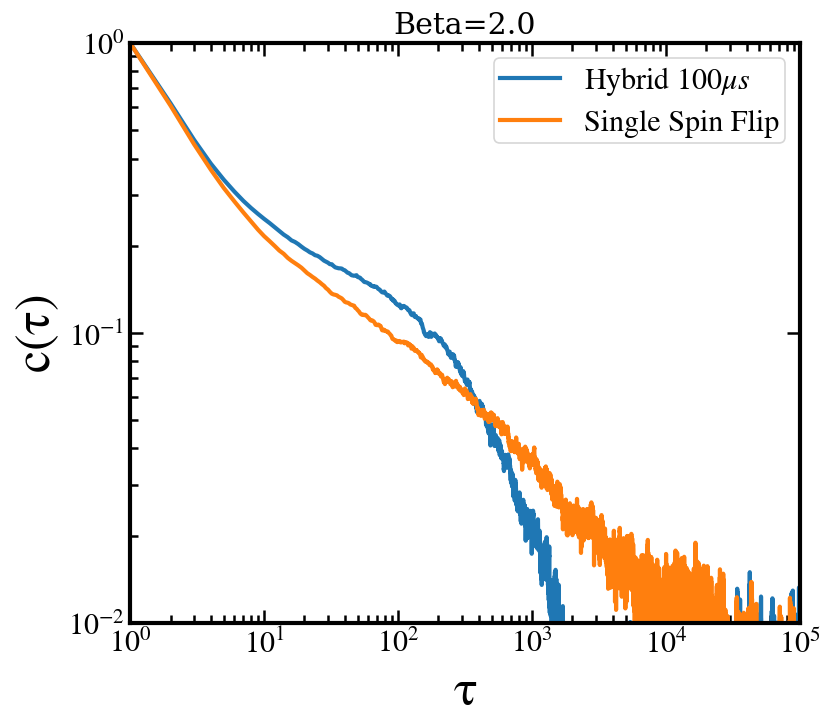

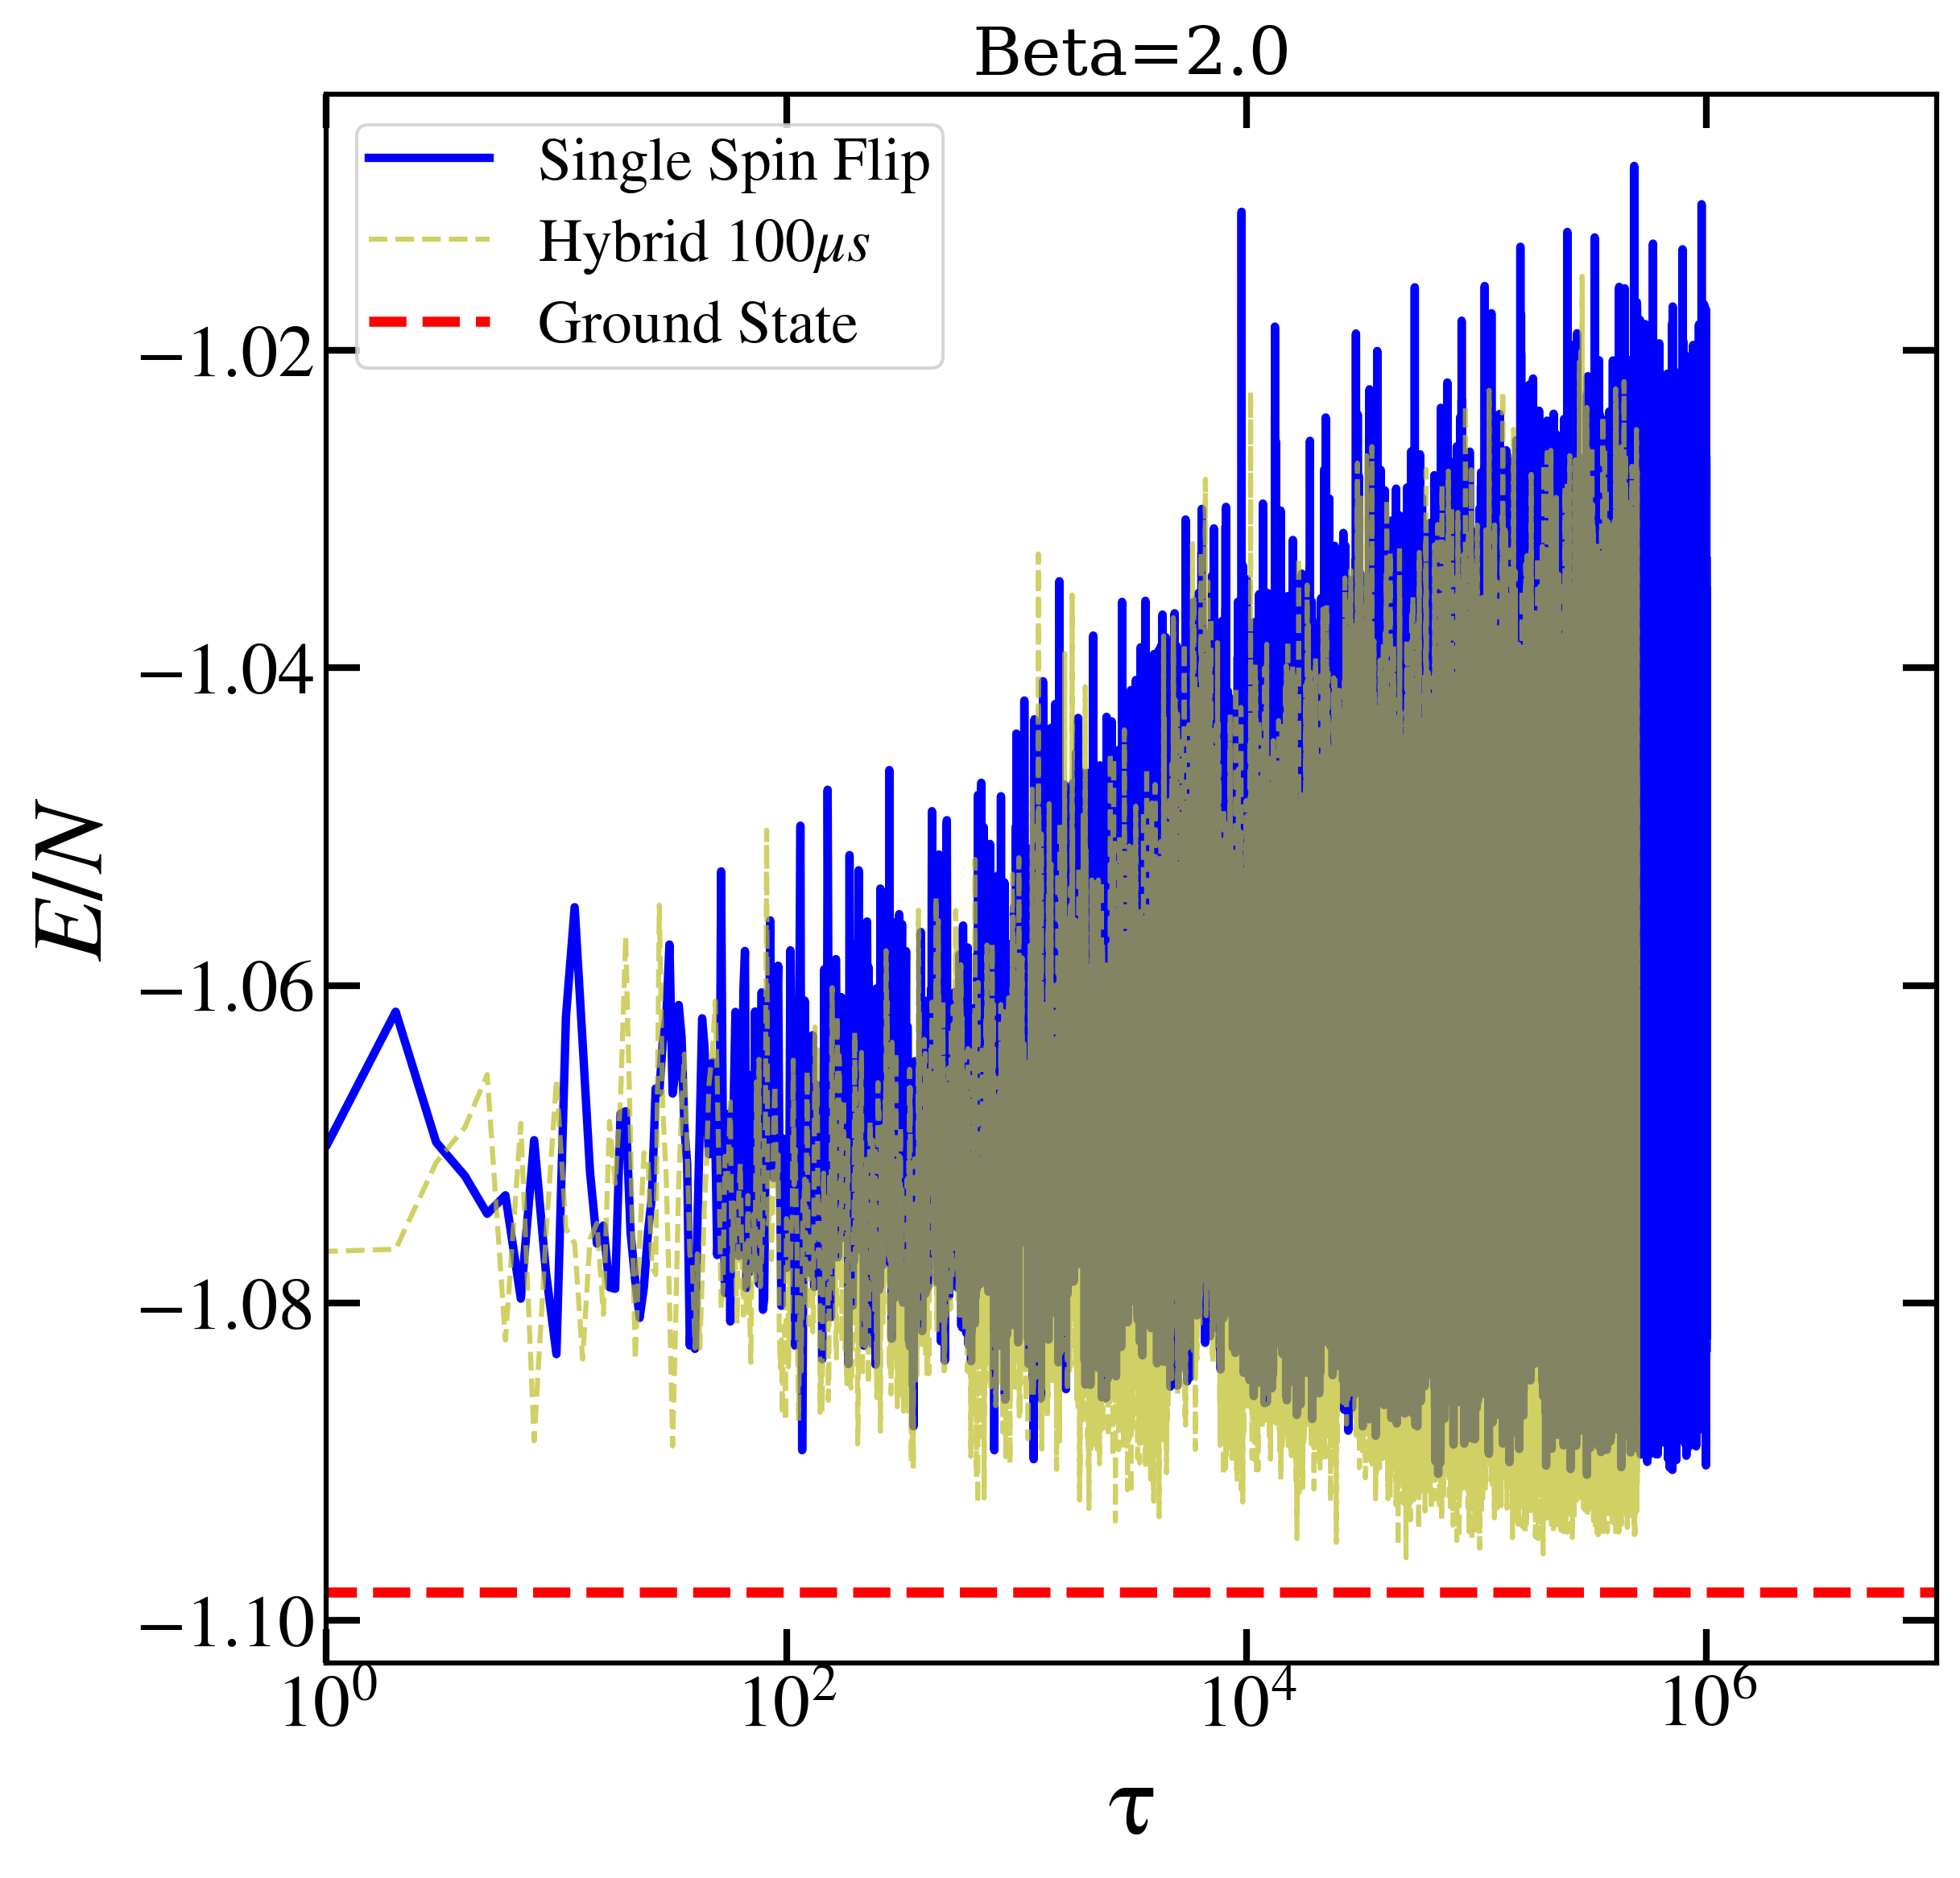

(500000,)


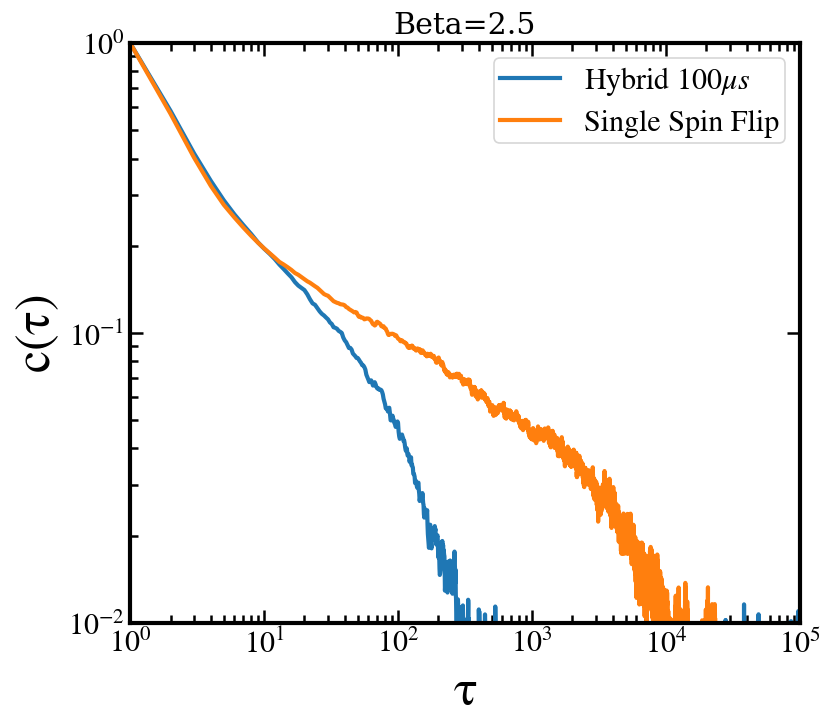

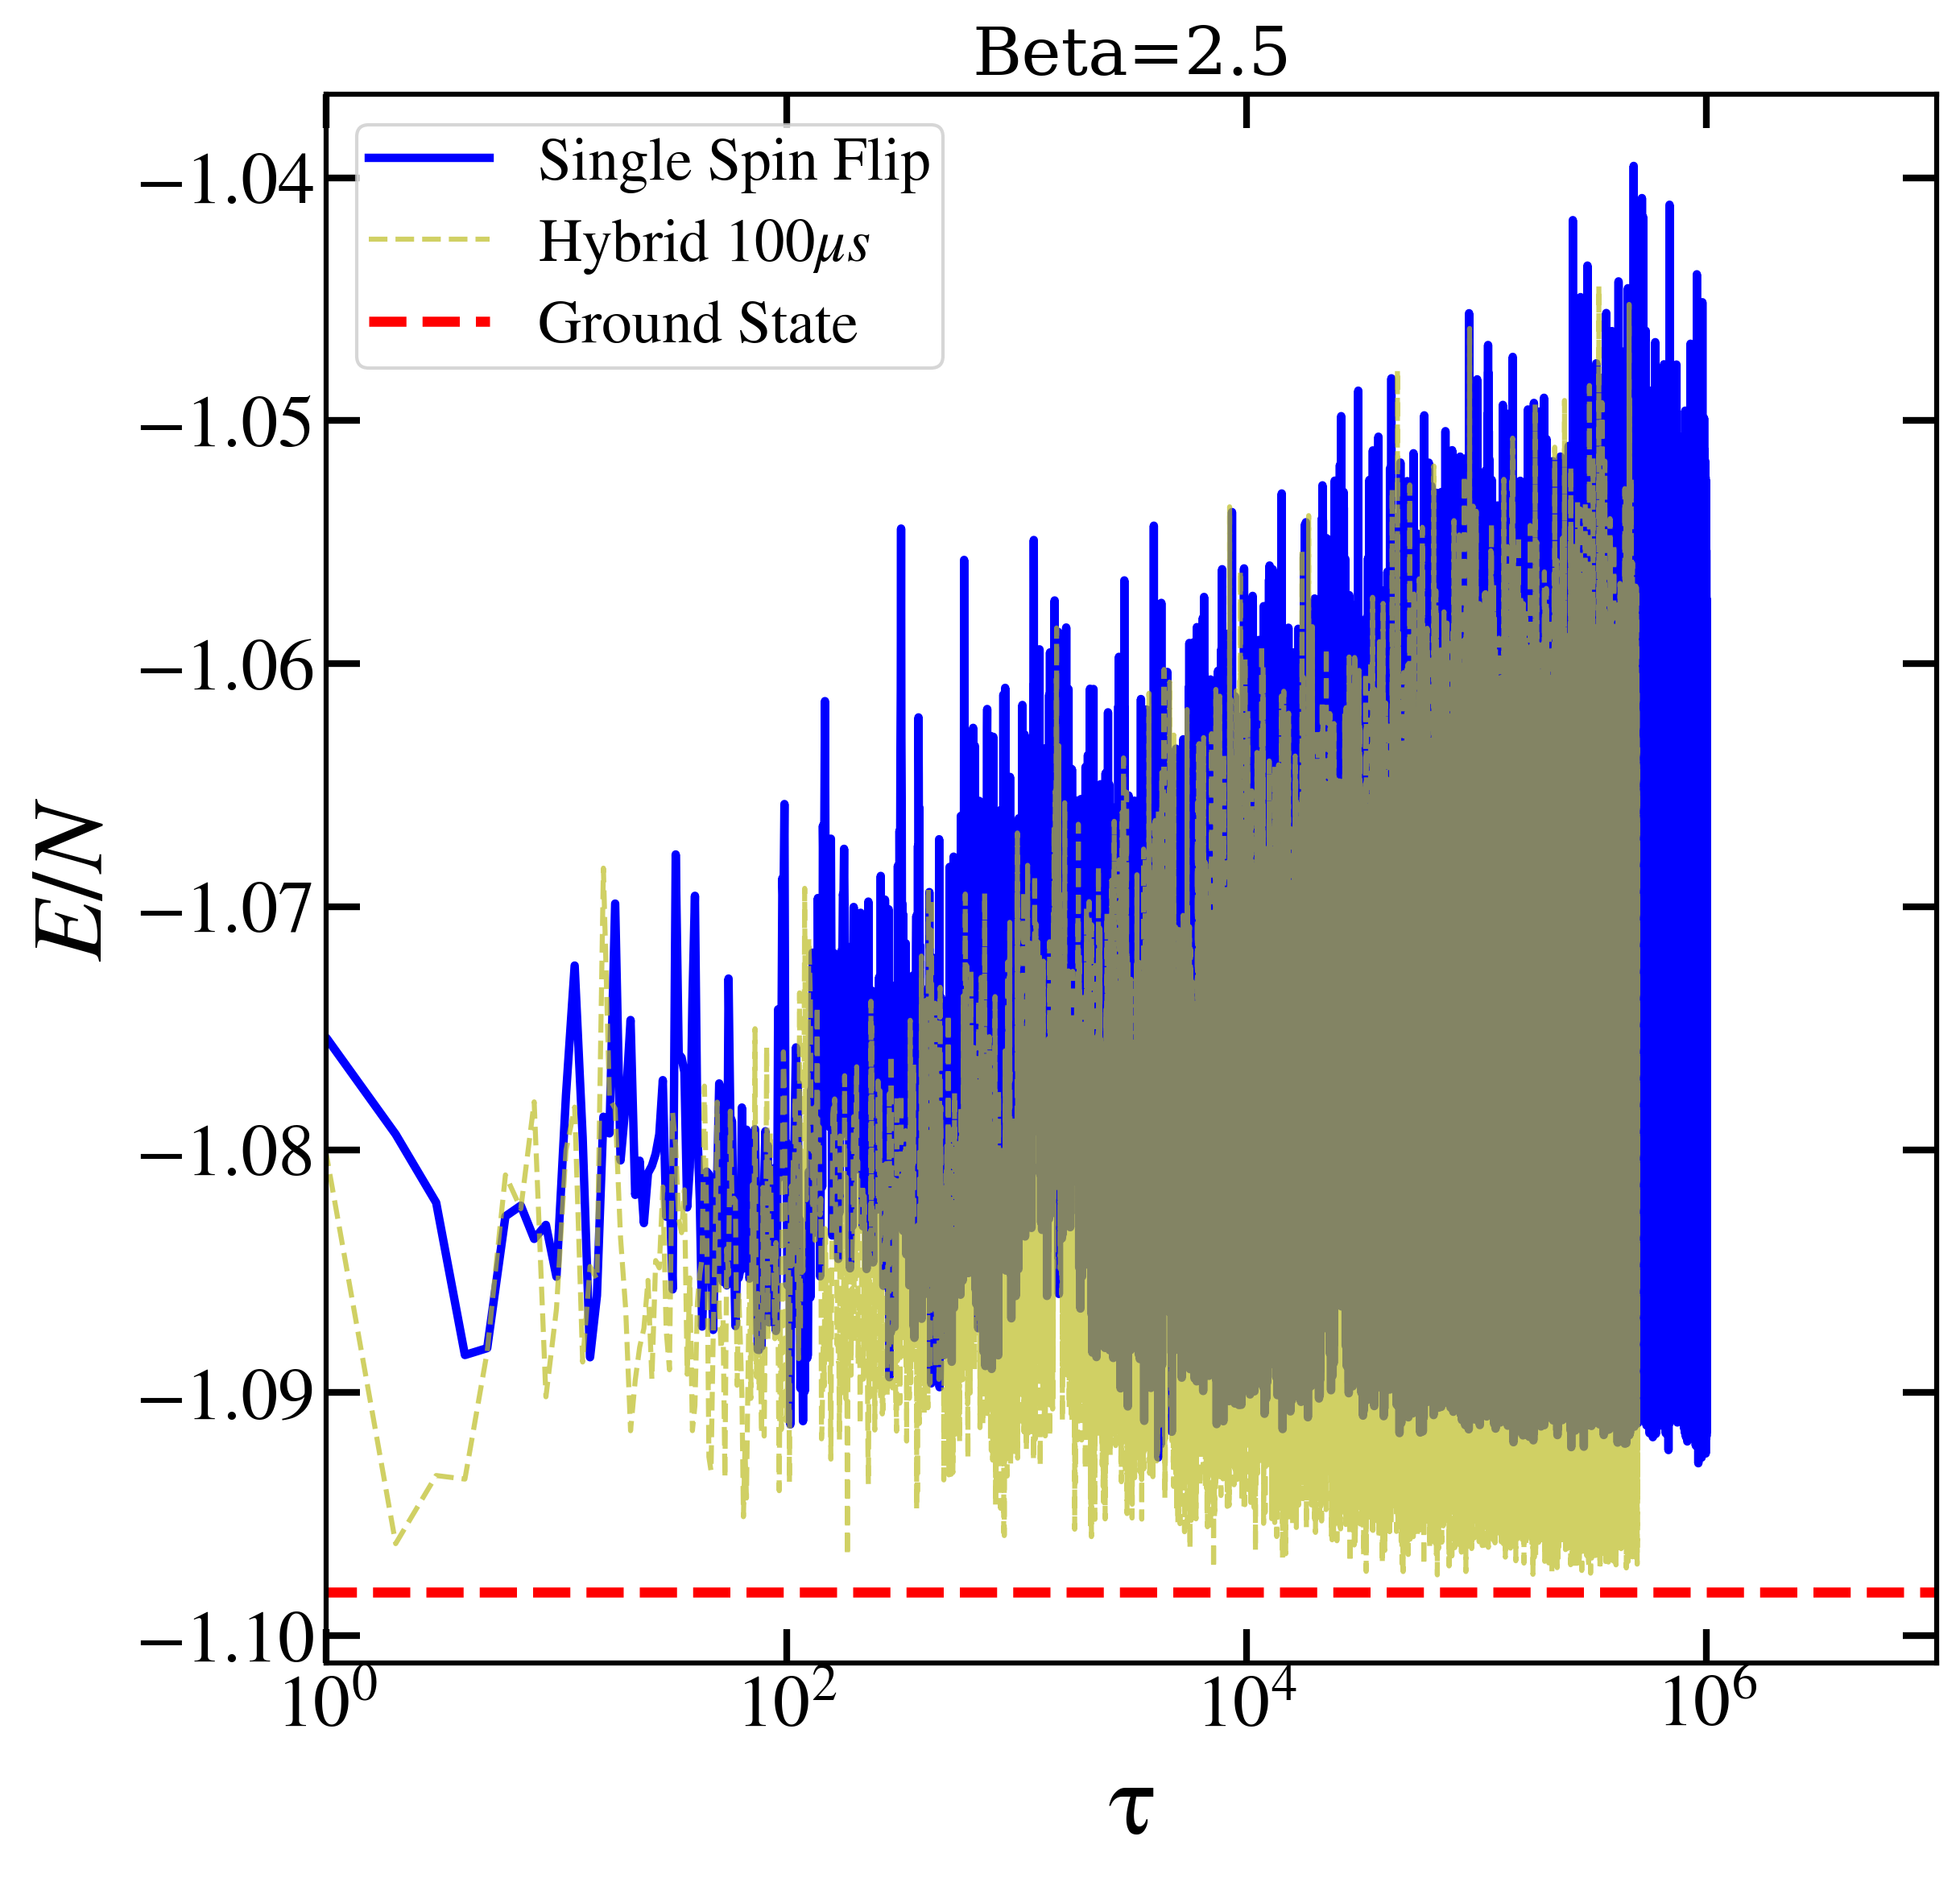

(500000,)


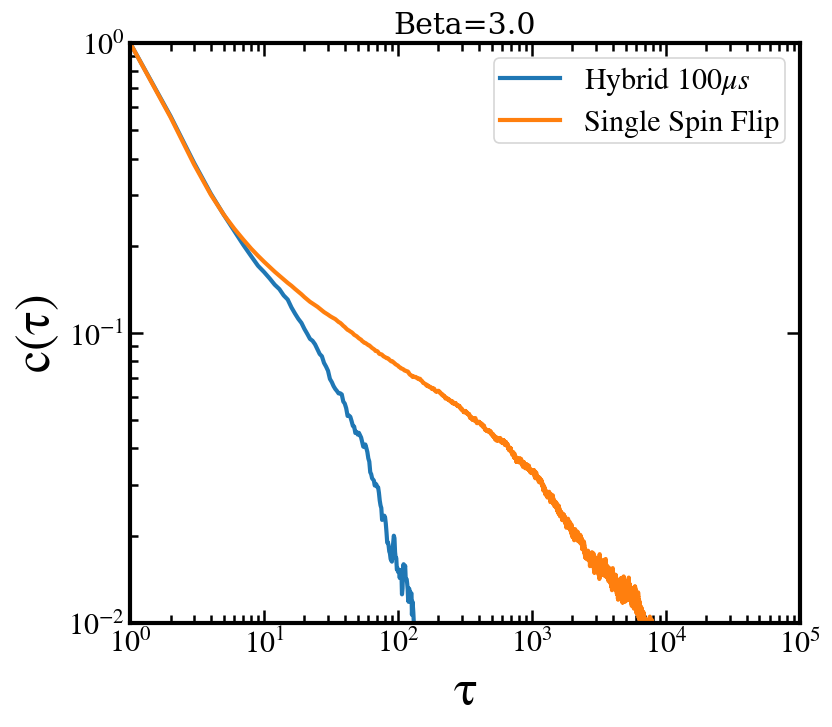

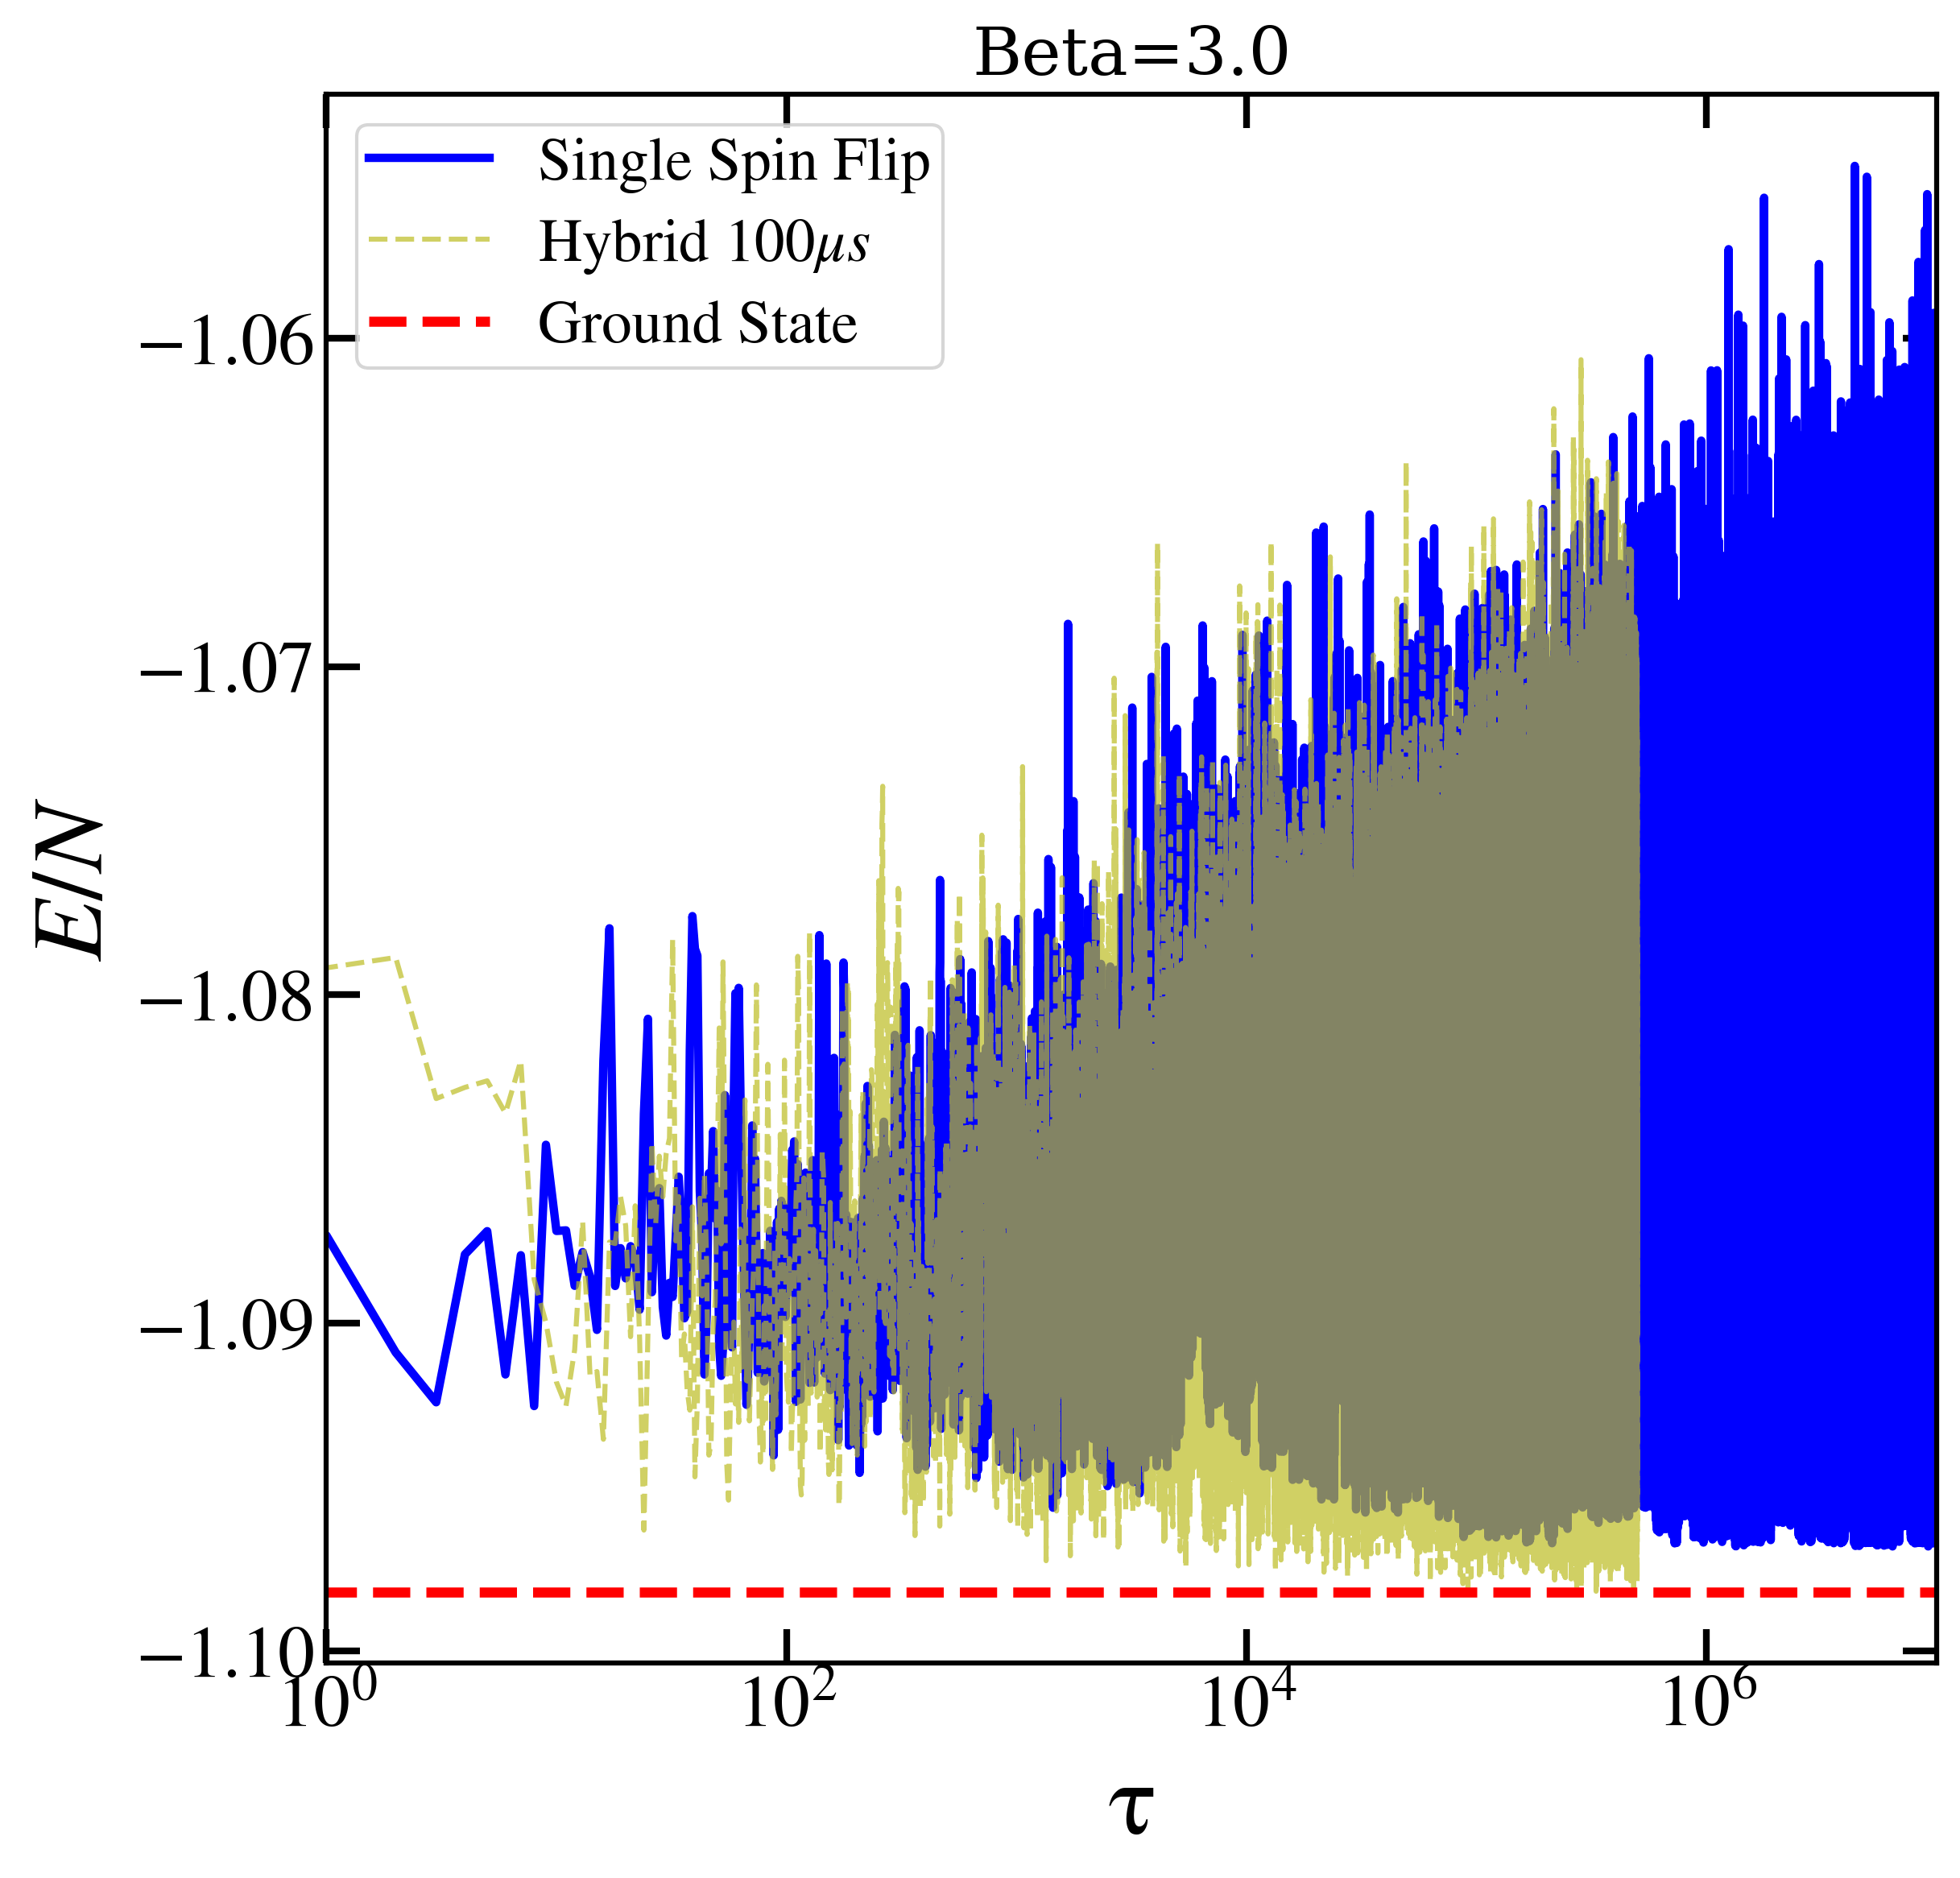

(500000,)


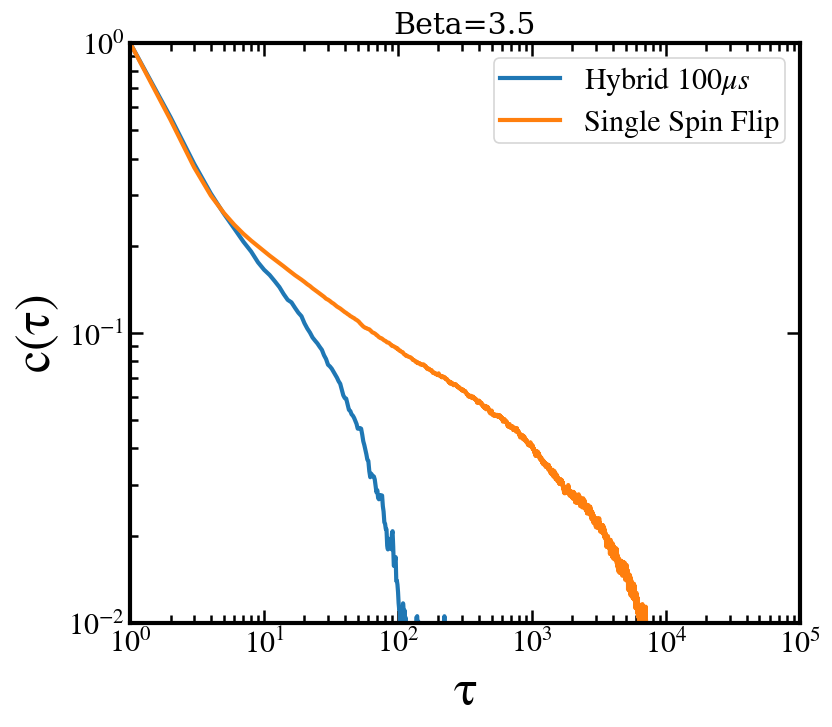

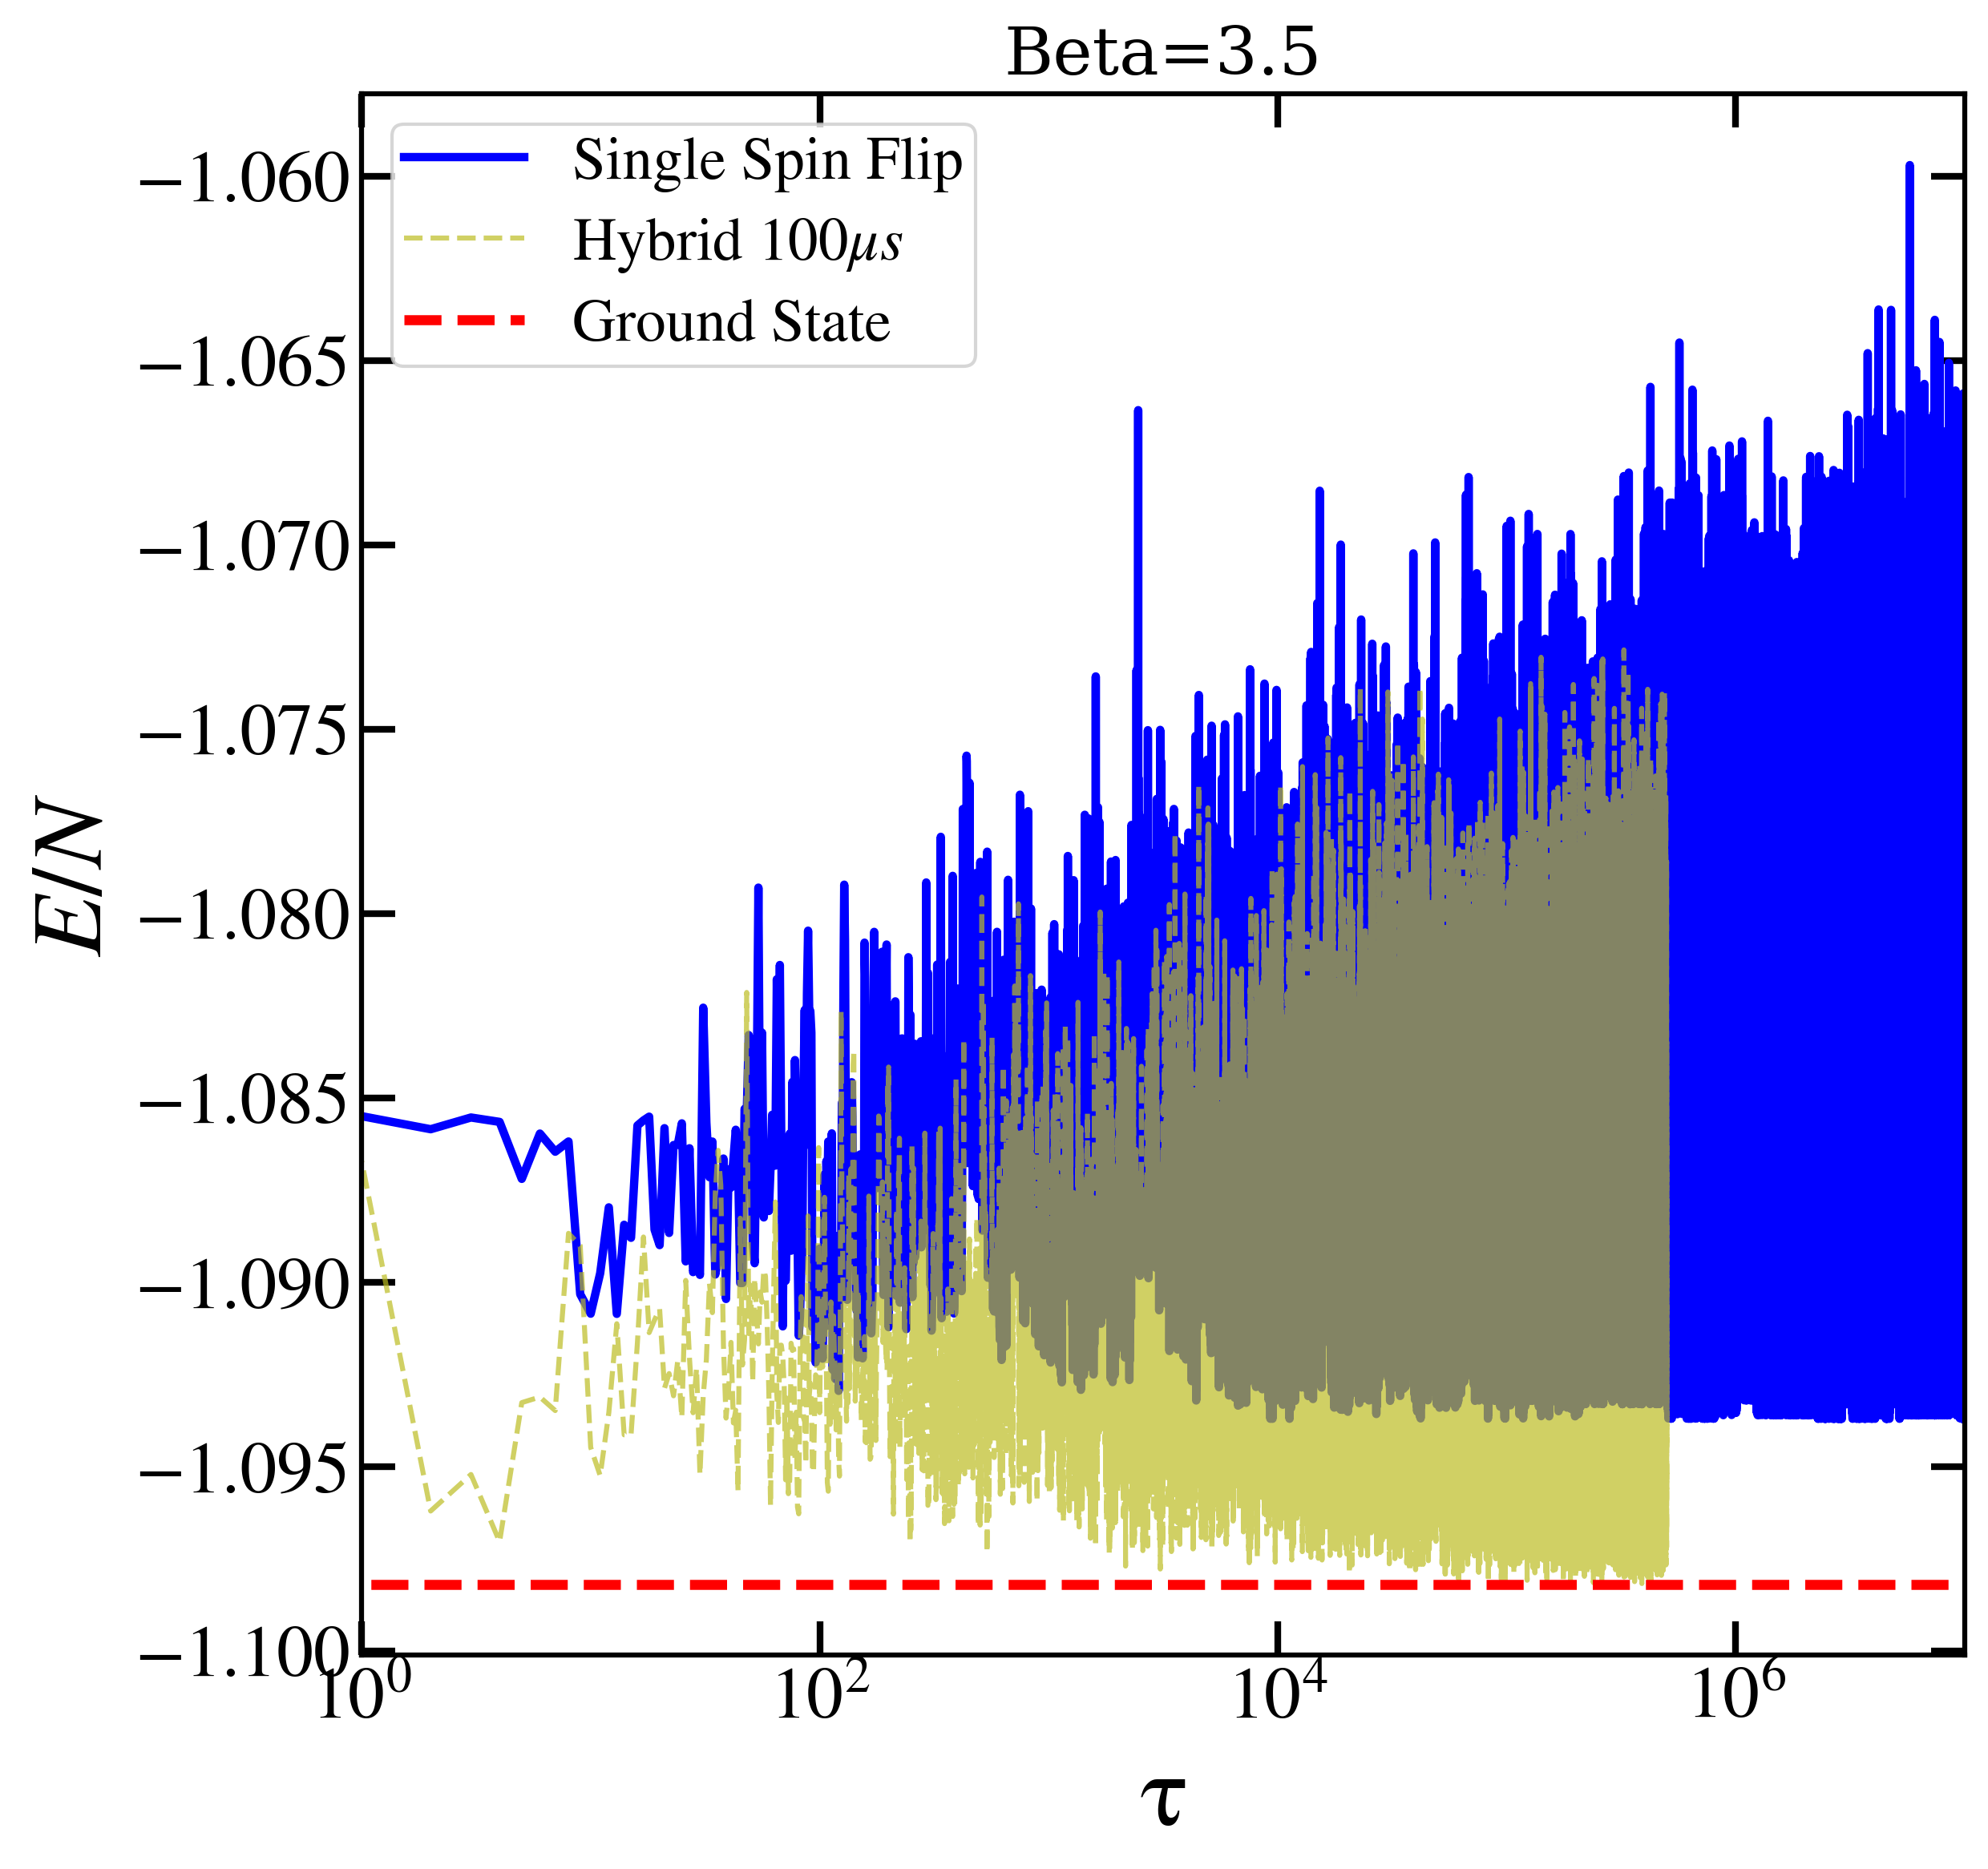

(500000,)


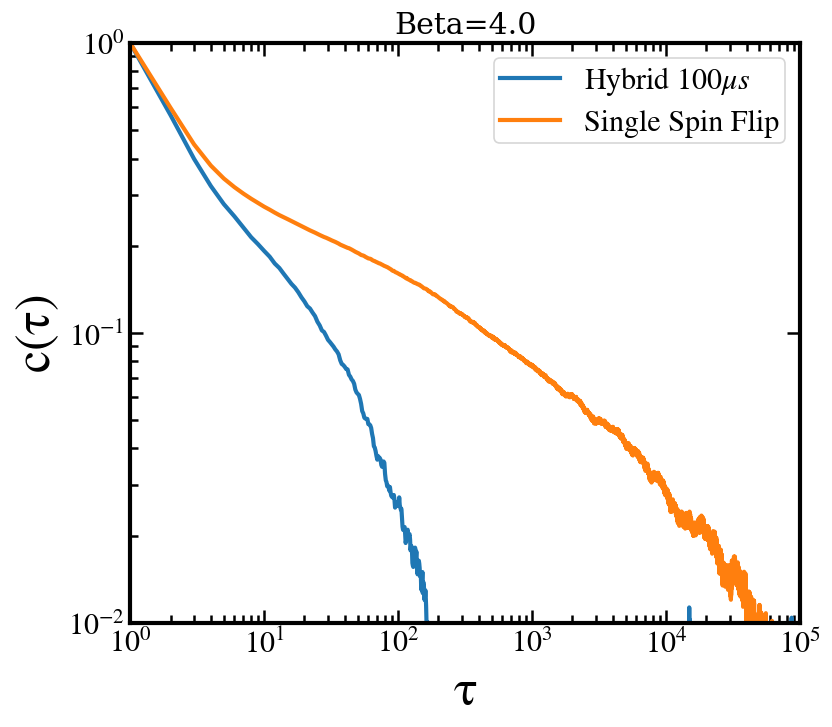

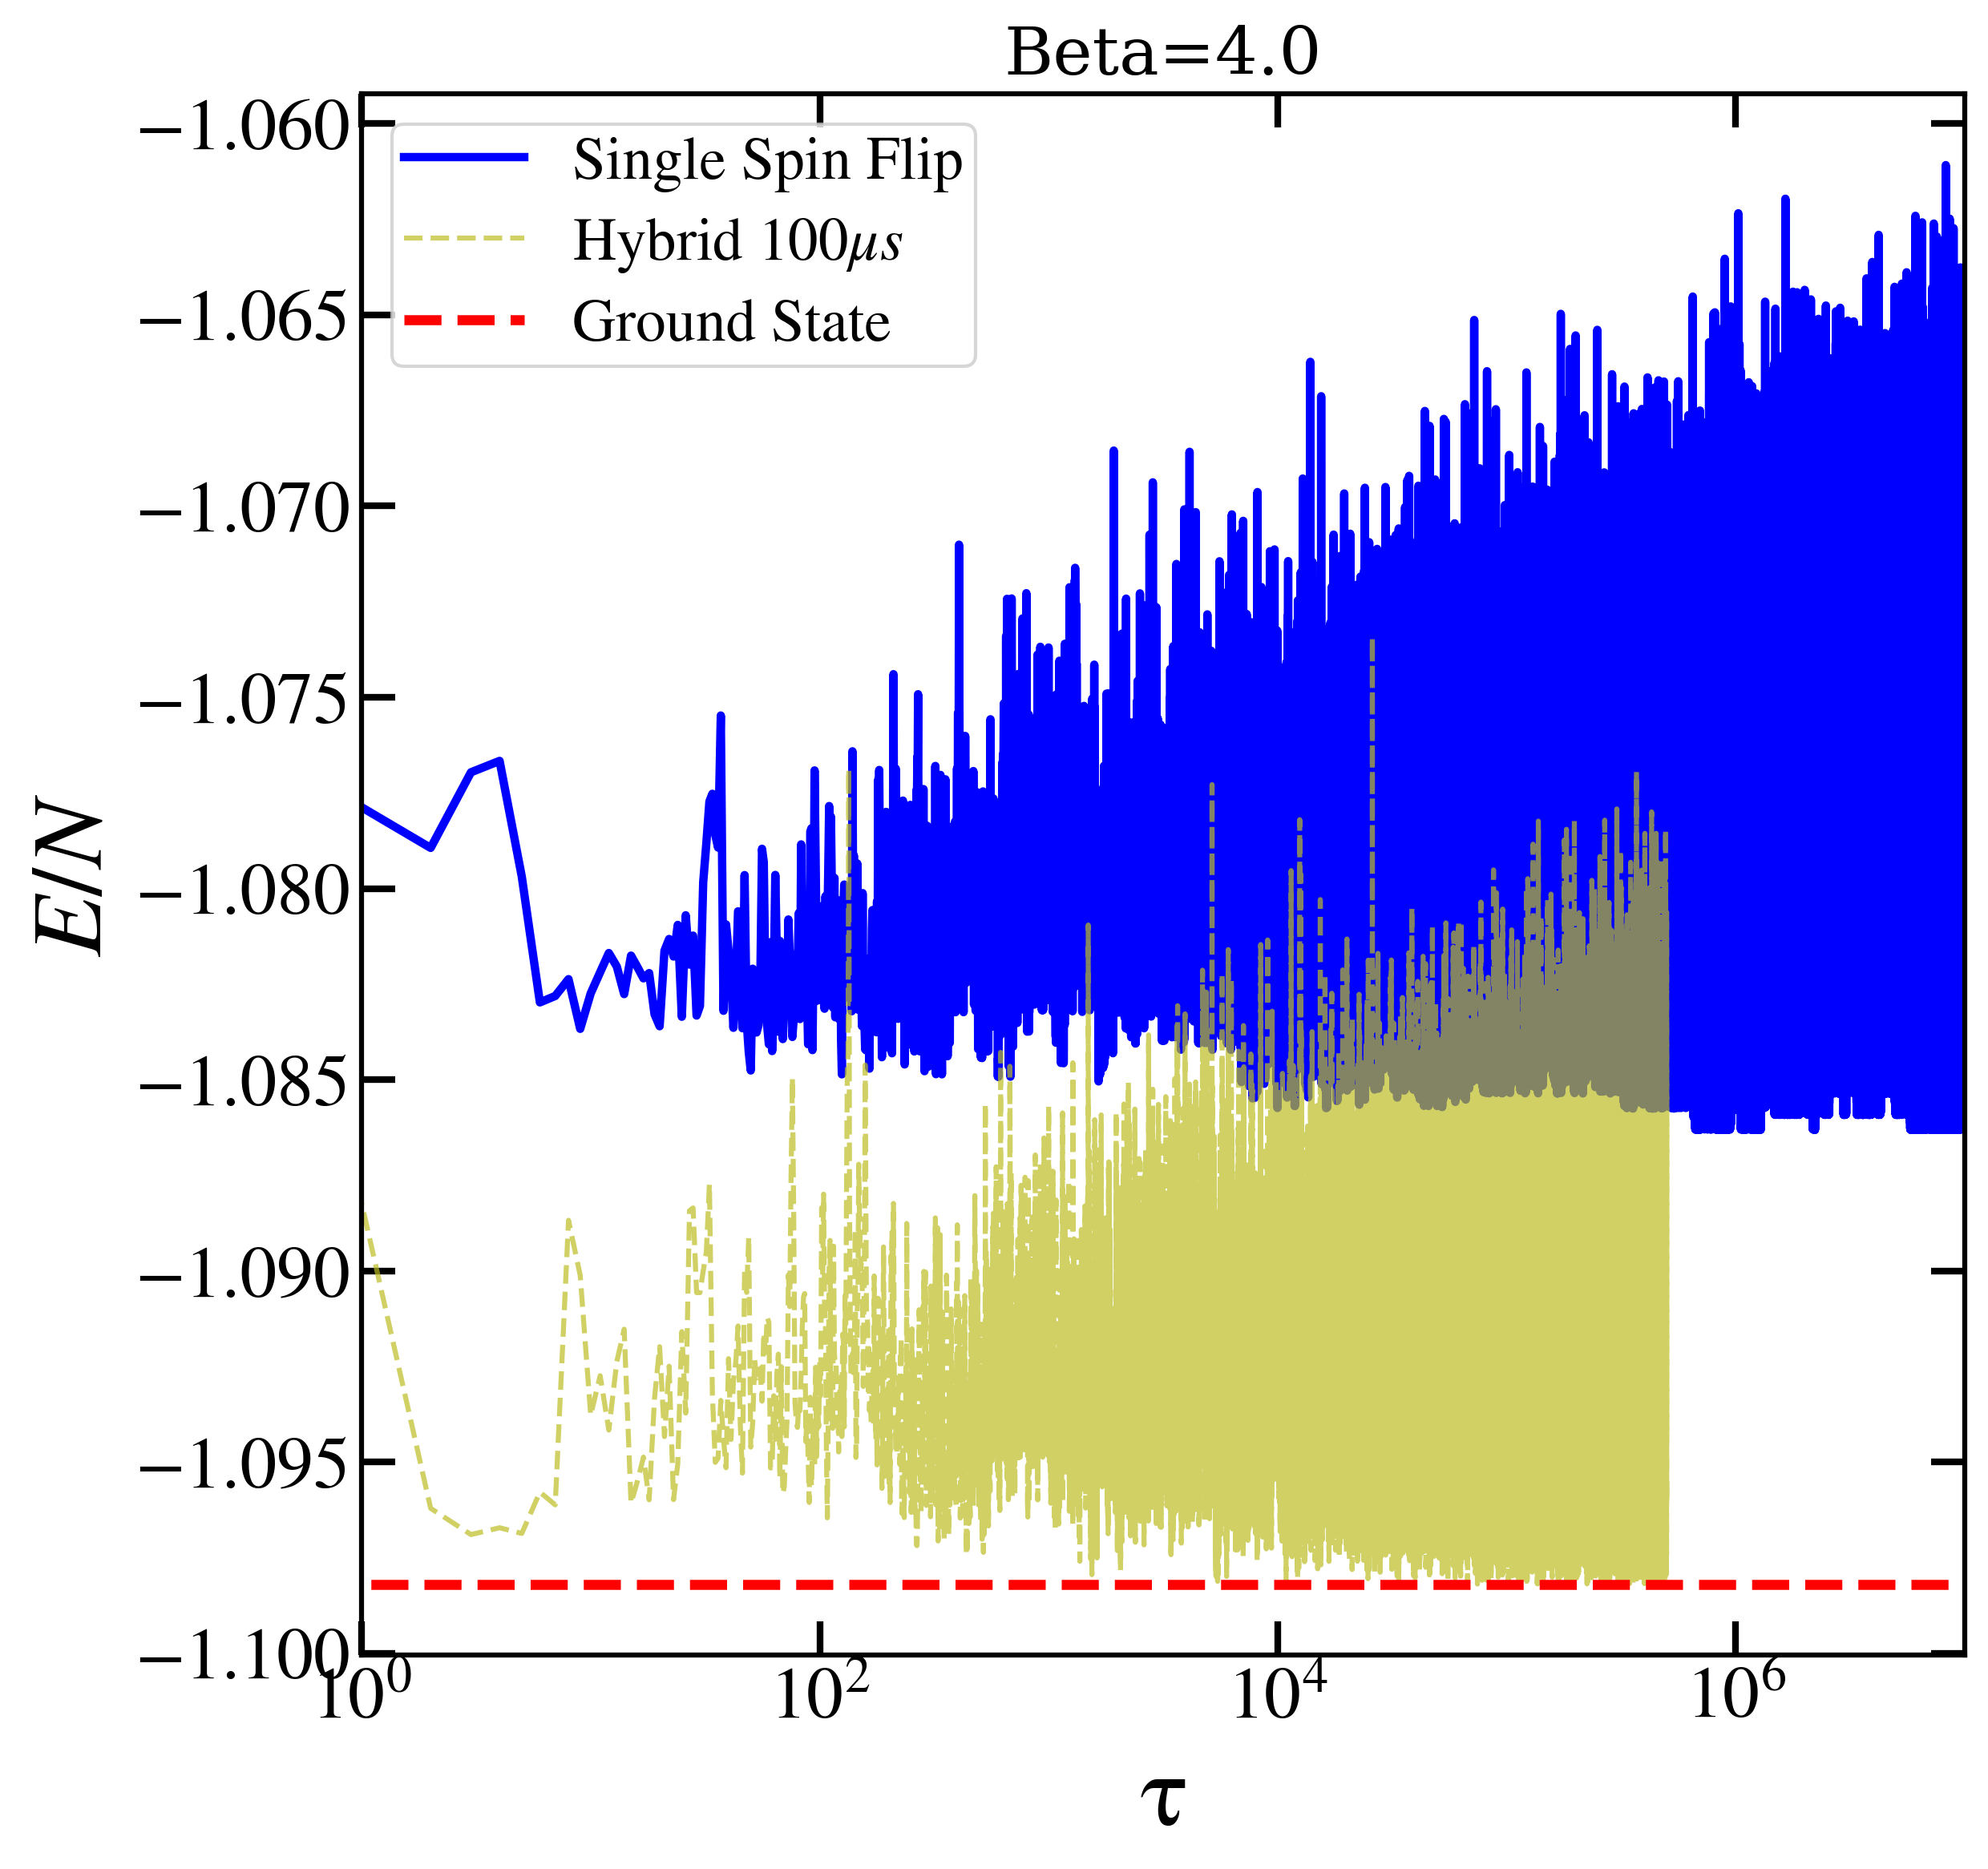

In [15]:
betas = np.linspace(1, 4, num=7)

for i, eng_hybrid in enumerate(eng_seq_hybrid_3nn):
    print(eng_hybrid.shape)
    ac_hybrid = acf(eng_hybrid, nlags=100000, fft=True)
    plt_acf([np.insert(ac_hybrid, 0, 1), np.insert(ac_betas[i], 0, 1)], [r"Hybrid $100\mu s$", "Single Spin Flip"], ylim=(0.01, 1), xlim=(1, 100000), title=f"Beta={betas[i]}")
    plt_eng_step(single_engs[i], eng_hybrid, "Single Spin Flip", r"Hybrid $100\mu s$", ground_state=ground_state,
        xlim=(1,10000000), title=f"Beta={betas[i]}")


## Compare Network Hist

Here we compare the histogram of the generated data by NADE, MADE and PixelCNN.

#TODO: Modify the plt_hist function

In [74]:
from typing import List, Optional, Tuple
import math

from src.utils.utils import compute_energy, get_couplings

def plot_hist(
    paths: List[str],
    couplings_path: str,
    truth_path: str = "/home/scriva/pixel-cnn/data/100-v1/train_100_lattice_2d_ising_spins.npy",
    ground_state: Optional[float] = None,
    colors: Optional[List[str]] = None,
    labels: Optional[List[str]] = None,
    density: Optional[bool] = False,
    save: bool = False,
) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    if labels is None:
        labels = [f"Dataset {i}" for i, _ in enumerate(paths)]
        labels.append("Truth")
    if colors is None:
        colors = [None for _ in paths]

    assert len(labels) - 1 == len(colors) == len(paths)

    truth = np.load(truth_path)
    try:
        truth = truth["sample"]
    except:
        truth = truth

    min_len_sample = truth.shape[0]
    truth = np.reshape(truth, (min_len_sample, -1))
    spins = truth.shape[-1]

    # laod couplings
    # TODO Adjancecy should wotk with spins, not spin side
    neighbours, couplings, len_neighbours = get_couplings(
        int(math.sqrt(spins)), couplings_path
    )

    eng_truth = []
    for t in truth:
        eng_truth.append(compute_energy(t, neighbours, couplings, len_neighbours))
    eng_truth = np.asarray(eng_truth) / spins

    min_eng, max_eng = eng_truth.min(), eng_truth.max()

    engs = []
    for path in paths:
        data = np.load(path)
        try:
            sample = data["sample"]
        except:
            sample = data

        sample = sample.squeeze()
        min_len_sample = min(min_len_sample, sample.shape[0])
        sample = np.reshape(sample, (-1, spins))

        eng = []
        for s in sample:
            eng.append(compute_energy(s, neighbours, couplings, len_neighbours))
        eng = np.asarray(eng) / spins

        min_eng = min(min_eng, eng.min())
        max_eng = max(max_eng, eng.max())
        engs.append(eng)

    # fig, ax = plt.subplots(figsize=(7.8, 7.8), dpi=128, facecolor="white")
    fig, ax = plt.subplots(figsize=(8.6, 8.6), dpi=300, facecolor="white")


    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["axes.linewidth"] = 2.5

    stringfont = "serif"

    ax.tick_params(
        axis="y",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=2.5,
        length=8,
        direction="in",
        labelsize=24,
    )
    ax.tick_params(
        axis="y",
        which="minor",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=2.5,
        length=4,
        direction="in",
        labelsize=24,
    )
    ax.tick_params(
        axis="x",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=2.5,
        length=8,
        direction="in",
        labelsize=24,
    )

    ax.set_yscale("log")

    plt.ylabel(r"$N$", fontsize=30, fontfamily=stringfont)
    plt.xlabel(r"$E/N$", fontsize=30, fontfamily=stringfont)

    plt.xlim(ground_state - 0.02, -0.40)

    bins = np.linspace(min_eng, max_eng, num=100).tolist()

    for i, eng in enumerate(engs):
        _ = plt.hist(
            eng[:min_len_sample],
            bins=bins,
            # log=True,
            label=f"{labels[i]}",
            histtype="bar",
            alpha=0.9 - i * 0.1,
            color=colors[i],
            density=density,
        )
        print(
            f"\n{labels[i]}\nE: {eng.mean()} \u00B1 {eng.std(ddof=1) / math.sqrt(eng.shape[0])}\nmin: {eng.min()} ({np.sum(eng==eng.min())} occurance(s))                                                                    (s))"
        )
    _ = plt.hist(
        eng_truth[:min_len_sample],
        bins=bins,
        # log=True,
        label=f"{labels[i+1]}",
        histtype="bar",
        edgecolor="k",
        color=["lightgrey"],
        alpha=0.5,
        density=density,
    )

    if density:
        min_len_sample = 200

    if ground_state is not None:
        plt.vlines(
            ground_state,
            1,
            min_len_sample * 0.5,
            linewidth=4.0,
            colors="red",
            linestyles="dashed",
            alpha=0.7,
            label="Ground State",
        )

    print(
        f"\n{labels[i+1]} eng\nE: {eng_truth.mean()} \u00B1 {eng_truth.std(ddof=1) / math.sqrt(eng_truth.shape[0])}\nmin: {eng_truth.min()}  ({np.sum(eng_truth==eng_truth.min())} occurance(s))"
    )

    plt.ylim(1, min_len_sample * 0.5)

    plt.legend(
        loc="upper right", labelspacing=0.4, fontsize=22, borderpad=0.2, fancybox=True
    )

    if save:
        plt.savefig(
            "images/hist.eps",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            # transparent=True,
            bbox_inches="tight",
            format="eps",
        )
        plt.savefig(
            "images/hist.png",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            # transparent=True,
            bbox_inches="tight",
        )

    return engs, eng_truth


PixelCNN
E: -0.9822175931674327 ± 0.00033342118254824543
min: -1.2135701871929978 (1 occurance(s))                                                                    (s))

NADE
E: -1.0408173191487722 ± 0.0002343607548935933
min: -1.2202445994349982 (1 occurance(s))                                                                    (s))

MADE
E: -1.048799481295052 ± 0.00021112991495102925
min: -1.2171280293869977 (2 occurance(s))                                                                    (s))

D-Wave 100$\mu$s eng
E: -1.0514303330793644 ± 0.00019710815464982863
min: -1.2165612158029981  (1 occurance(s))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


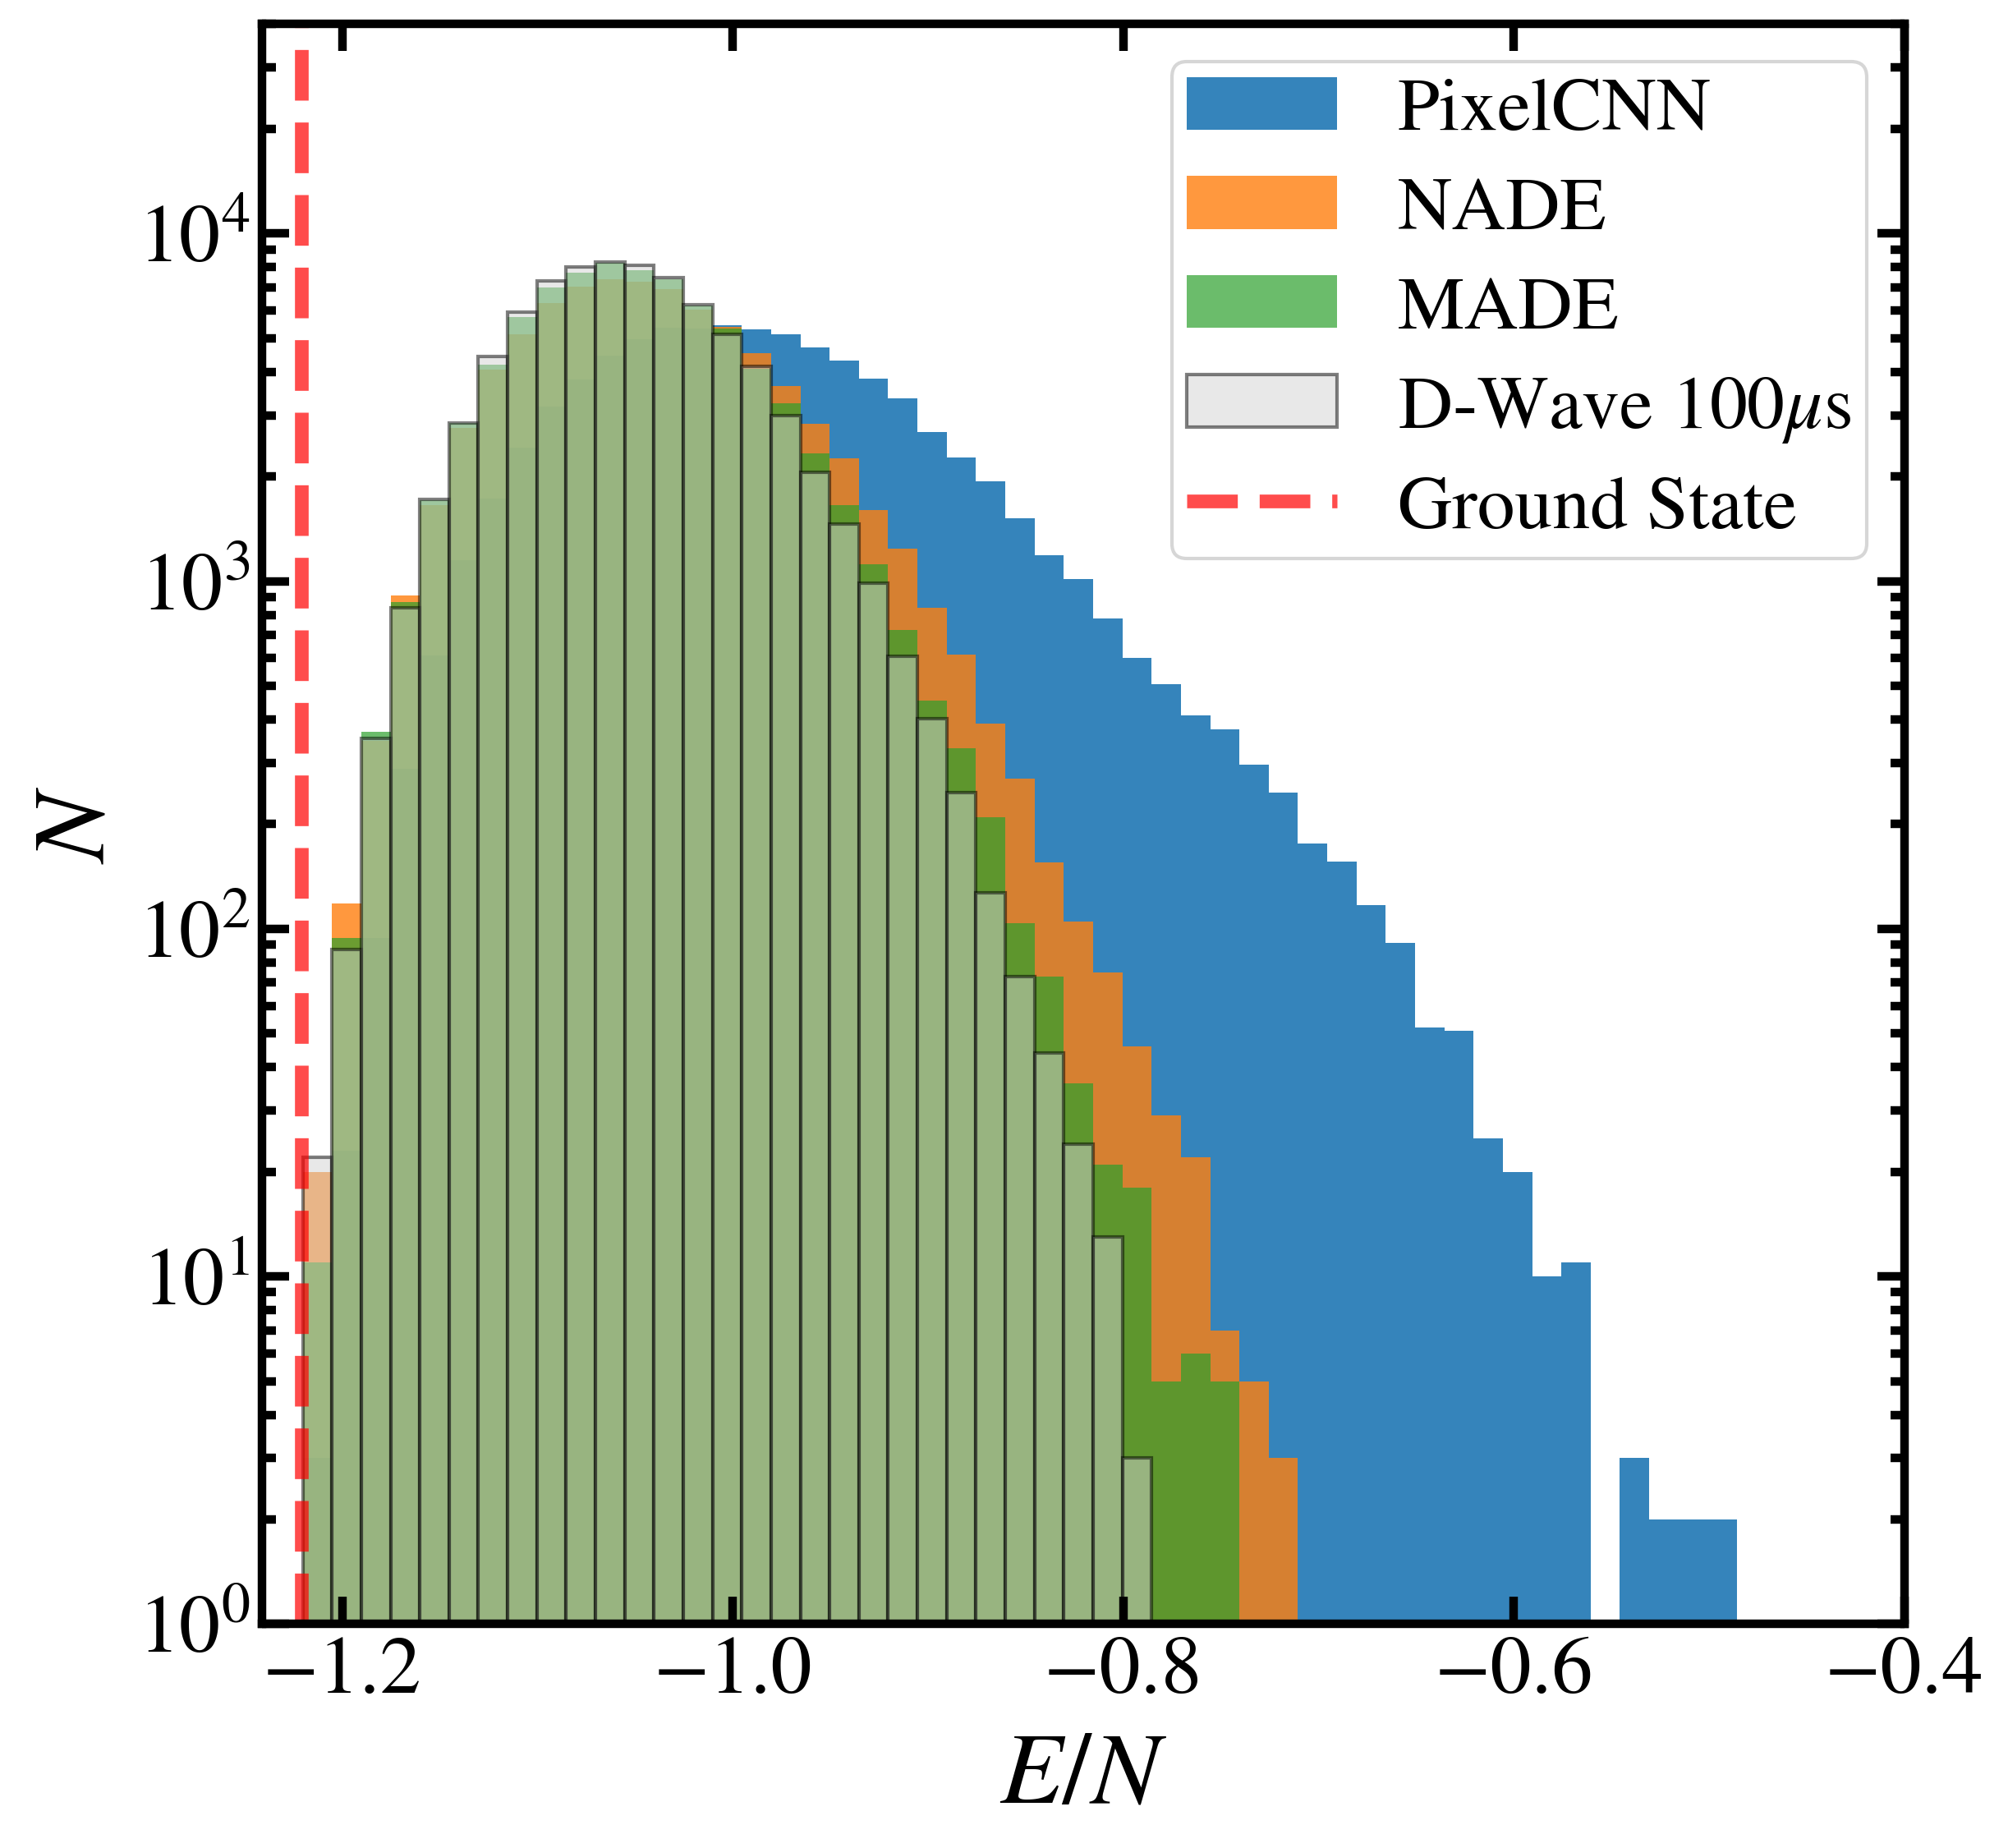

In [76]:
path = ["sample-80001_size-10_2022-03-30_19-39-52.npz", "size-10_sample-80001_nade.npz", "sample-80001_size-100_2022-03-30_19-32-34.npz"] # nade, pixel, made
truth = "train-100spins-1nn-100.npy"

labels = ["PixelCNN", "NADE", "MADE", r"D-Wave 100$\mu$s"]
ground_state = -1.2210371388 # 100 spin open

couplings_path="data/couplings/100spins_open-1nn.txt"

engs, eng_truth = plot_hist(path, couplings_path, truth, ground_state=ground_state, labels=labels, save=True)

## Comparison between energies

Comparison between energies for 484 spins 1 NN.

In [23]:
couplings_path="data/couplings/484spins-uniform-1nn.txt"

seq_hybrid = ["data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.0_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.1_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.2_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.3_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.4_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.5_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.6_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.7_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.8_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.9_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.0_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.1_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.2_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.3_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.4_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.5_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.6_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.7_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.8_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.9_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.0_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.1_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.2_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.3_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.4_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.5_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.6_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.7_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.8_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.9_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta4.0_200000hybrid-mcmc_single_len100.npz",
]

# for path in seq_hybrid:
# engs = get_energy(22, seq_hybrid, couplings_path)

eng_seq_hybrid = [np.load(eng)['energy'] / 484 for eng in seq_hybrid] 

In [24]:
single12345 = np.load("data/MCMC_single/eng_longMCMC/eng_single12345.npy")
single23451 = np.load("data/MCMC_single/eng_longMCMC/eng_single23451.npy")
single34512 = np.load("data/MCMC_single/eng_longMCMC/eng_single34512.npy")
single45123 = np.load("data/MCMC_single/eng_longMCMC/eng_single45123.npy")
single51234 = np.load("data/MCMC_single/eng_longMCMC/eng_single51234.npy")


single_all = np.concatenate((single12345[None, ...], single23451[None, ...], single34512[None, ...], single45123[None, ...], single51234[None, ...]), axis=0)
single_all.shape

(5, 21, 200000)

In [34]:
betas = np.linspace(2,4,num=21)
betas

In [37]:
auto_corrs = []
for i in range(single_all.shape[1]):
    auto_corrs.append(acf(single_all[0,i], nlags=single_all.shape[-1] // 4 , fft=True))

In [44]:
auto_corrs[0][:3]

array([1.        , 0.06697095, 0.0471056 ])

In [38]:
def block_std(engs, len_block: int, skip: int = 0) -> float:
    """Compute the block std of a list of arrays.
    See http://chimera.roma1.infn.it/SP/doc/estratti/dataAnalysis.pdf

    Args:
        engs (List[np.ndarray]): List of energies arrays.
        len_block (int): Block lenght to compute std.
        skip (int, optional): Number of initial sample to skip. Defaults to 0.

    Returns:
        float: Block std.
    """
    std_engs = []
    for eng in engs:
        if isinstance(eng, list):
            eng = np.asarray(eng)
        eng = eng[skip:].copy()
        rest_len = eng.size % len_block
        if rest_len != 0:
            eng = eng[:-rest_len]
        eng = eng.reshape(-1, len_block)
        new_len = eng.shape[0]
        error = np.std(eng.mean(axis=1), ddof=0) / np.sqrt(new_len - 1)
        std_engs.append(error)
    return std_engs

/tmp/ipykernel_854327/3553302366.py:25: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,50000)


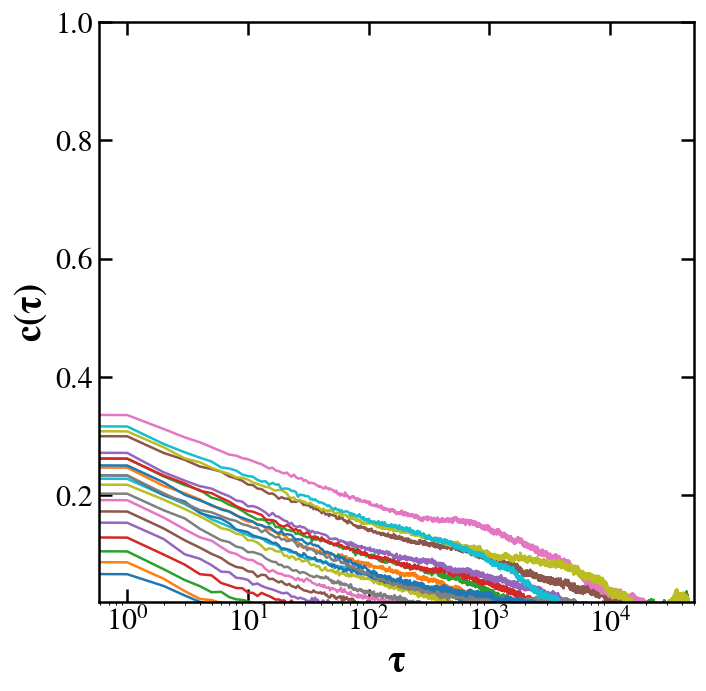

In [41]:
fig, ax = plt.subplots(figsize=(6.4, 6.4), dpi=120, facecolor='white')

plt.rcParams['mathtext.fontset']= "stix"
plt.rcParams['font.family']= 'STIXGeneral'
plt.rcParams['axes.linewidth'] = 2.5

stringfont = 'serif'

ax.tick_params(axis='y', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)
ax.tick_params(axis='x', top=True, right=True, labeltop=False, labelright=False, width=1.5, length=8, direction='in', labelsize=18)

plt.rcParams['axes.linewidth'] = 1.5

for i, corr in enumerate(auto_corrs):
    plt.plot(np.insert(corr, 1., 0), label=f"{str(betas[i])}")

ax.set_xscale("log")
# ax.set_xticks((10, 1000, 100000))
# ax.set_xticklabels((r'$10^6$', r'$10^8$', r'$10^{10}$'))#, fontsize=12, fontfamily=stringfont)

plt.ylabel(r"$\bf{c(\tau)}$", fontsize=22, fontweight='bold')
plt.xlabel(r"$\bf{\tau}$", fontsize=22, fontweight='bold')

plt.ylim(0.02, 1)
plt.xlim(1,50000)

#plt.title(f"Sweeps 10000", fontsize=12, fontfamily=stringfont, fontweight='bold')

#plt.legend(loc='best', fontsize=18, labelspacing=0.4, borderpad=0.2)

plt.savefig("images/correlation.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')